## FINAL

In [1]:
## CARGAR LIBRERIAS

In [2]:
#Ignorar los warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from numpy import vectorize


# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, f_regression, chi2, mutual_info_regression, SelectPercentile, SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect
from sklearn.feature_selection import VarianceThreshold

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline



In [3]:
## FUNCIÓN PARA DESFASE

In [4]:
# Función para transformar datos crudos en datos para el aprendizaje de una serie de tiempo
def desfasar(data, n_atras=1, n_adelante=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dfd = pd.DataFrame(data)
    cols, names = list(), list()
    aux=dfd.columns.values
    # Secuencia de entrada (t-n, ... t-1)
    for i in range(n_atras, 0, -1):
        cols.append(dfd.shift(i))
        names += [f'{aux[j]}(t-{i})' for j in range(n_vars)]
    # Secuencia de pronostico (t, t+1, ... t+n)
    for i in range(0, n_adelante+1):
        cols.append(dfd.shift(-i))
        if i == 0:
            names += [f'{aux[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{aux[j]}(t+{i})' for j in range(n_vars)]
    # Juntar toda la informacion
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Eliminar los registros con valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
## FUNCION PARA ESCALADO

In [6]:

#Función para escalar los datos, recibe dato a escalar (vector), minimo y maximo 
def escala(x,mi,ma):
    return (x-mi)/(ma-mi)

escalador = vectorize(escala)

#Ejemplo de uso
#   values[:,0]=escalador(values[:,0],0,300)

def Reescala(x,mi,ma):
    return x*(ma-mi)+mi

Reescalador = vectorize(Reescala)


In [7]:
## FUNCION PARA SELECCION DE CARACTERISTICAS

In [8]:

def seleccion(param,n):
    plt.figure(1,figsize=(10,5))
    plt.clf()

    X_indices = np.arange(X.shape[-1])

    # #############################################################################
    # Univariate feature selection with F-test for feature scoring
    # We use the default selection function to select the four
    # most significant features
    selector = SelectKBest(param, k=n)
    selector.fit(x_train, y_train)
    #print("p_values: ",selector.pvalues_)
    scores = selector.scores_
    mask = selector.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature,score in zip(mask, feature_names,scores):
        if bool:
            new_features.append([feature,score])

    #print('caracteristicas: ',sorted(new_features, key = lambda x: x[1], reverse=True))
    # #############################################################################
    # Compare to the weights of an SVM
    clf = make_pipeline(MinMaxScaler(), SVR(kernel='linear'))
    clf.fit(x_train, y_train)
    print('Classification accuracy without selecting features: {}'
          .format(clf.score(x_test, y_test)))

    svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
    svm_weights /= svm_weights.sum()

    plt.bar(X_indices , svm_weights, width=.5, label='SVM weight')#- .25

    clf_selected = make_pipeline(
            SelectKBest(param, k=n), MinMaxScaler(), SVR( kernel='linear')
    )
    clf_selected.fit(x_train, y_train)
    
    print('Classification accuracy after univariate feature selection: {}'
          .format(clf_selected.score(x_test, y_test)))
    aux = clf_selected.score(x_test, y_test) # para retornar valor 
    svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
    svm_weights_selected /= svm_weights_selected.sum()

    plt.bar(X_indices[selector.get_support()], svm_weights_selected,
            width=.5, label='SVM weights after selection') # - .05


    plt.title("Comparing feature selection")
    plt.xlabel('Feature number')
    #plt.yticks(())
    plt.grid()
    plt.axis('tight')
    plt.legend(loc='upper right')
    plt.show()
    return aux
    

In [9]:
## LECTURA DE DATOS Y DEFINICIÓN DE PARAMETROS

In [10]:
Ciudad = 'CALI/'
DATA = 'barranquilla_consolidado_2013_2020.csv'
PATH_I = 'D:/DENGUE_CODIGO/'
PATH_O = PATH_I + Ciudad + 'RESULTADOS/CLIMA/'



FILE = PATH_I + 'DATOS_BASE/' + DATA 

#Lectura de datos diarios
df1 = pd.read_csv(FILE, index_col=None, parse_dates=True)
df1 = df1.interpolate()

# Variables globales
desfase = 23
n_semanas = 53
title_string = 'Variables climaticas'
nombre_a = 'caracteristicas_24.csv'
nombre_g = 'rendimiento_24.jpg'
df1

FECHA  COD_DPTO  COD_MUNICIPIO  POBLACION     ANO  SEMANA  \
0    14/04/2013       8.0         8001.0  1206946.0  2013.0    16.0   
1    21/04/2013       8.0         8001.0  1206946.0  2013.0    17.0   
2    28/04/2013       8.0         8001.0  1206946.0  2013.0    18.0   
3    05/05/2013       8.0         8001.0  1206946.0  2013.0    19.0   
4    12/05/2013       8.0         8001.0  1206946.0  2013.0    20.0   
..          ...       ...            ...        ...     ...     ...   
361         NaN       8.0         8001.0  1232462.0  2018.0    52.0   
362         NaN       8.0         8001.0  1232462.0  2018.0    52.0   
363         NaN       8.0         8001.0  1232462.0  2018.0    52.0   
364         NaN       8.0         8001.0  1232462.0  2018.0    52.0   
365         NaN       8.0         8001.0  1232462.0  2018.0    52.0   

     PRECIPITATION  DRY_DAYS  TEMPERATURE_AMAX  REL_HUMIDITY_AMAX  ...  \
0              3.2       5.0         32.921712               93.0  ...   
1              0.0       7.0         32.506878               93.0  ...   
2             32.2       6.0         31.859918               94.0  ...   
3             12.6       6.0         34.700000               98.0  ...   
4              0.0       7.0         32.900000               99.0  ...   
..             ...       ...               ...                ...  ...   
361            0.0       7.0         31.600000               88.0  ...   
362            0.0       7.0         31.600000               88.0  ...   
363            0.0       7.0         31.600000               88.0  ...   
364            0.0       7.0         31.600000               88.0  ...   
365            0.0       7.0         31.600000               88.0  ...   

          MEI       ONI     SST1+2       SST3       SST4     SST3.4       TNI  \
0   -0.370000 -0.210000  24.740000  27.350000  28.470000  27.680000 -1.528000   
1   -0.370000 -0.210000  24.740000  27.350000  28.470000  27.680000 -1.528000   
2   -0.564286 -0.244286  23.682857  26.801429  28.607143  27.617143 -1.757143   
3   -0.710000 -0.270000  22.890000  26.390000  28.710000  27.570000 -1.929000   
4   -0.710000 -0.270000  22.890000  26.390000  28.710000  27.570000 -1.929000   
..        ...       ...        ...        ...        ...        ...       ...   
361  0.130000  0.810000  23.600000  26.120000  29.520000  27.530000 -1.700000   
362  0.130000  0.810000  23.600000  26.120000  29.520000  27.530000 -1.700000   
363  0.130000  0.810000  23.600000  26.120000  29.520000  27.530000 -1.700000   
364  0.130000  0.810000  23.600000  26.120000  29.520000  27.530000 -1.700000   
365  0.130000  0.810000  23.600000  26.120000  29.520000  27.530000 -1.700000   

     DENGUE  DENGUE GRAVE  MORTALIDAD POR DENGUE  
0      91.0           1.0                    0.0  
1      99.0           1.0                    0.0  
2      81.0           0.0                    0.0  
3      92.0           2.0                    0.0  
4      81.0           1.0                    0.0  
..      ...           ...                    ...  
361    42.0           0.0                    0.0  
362    42.0           0.0                    0.0  
363    42.0           0.0                    0.0  
364    42.0           0.0                    0.0  
365    42.0           0.0                    0.0  

[366 rows x 25 columns]

In [11]:
## EXTRACCION DE LOS DATOS A SER USADOS

In [12]:
#Extraer los datos climaticos y del niño
#XS=df1[['PRECIPITATION', 'DRY_DAY', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX', 'TEMPERATURE_AMIN', 'REL_HUMIDITY_AMIN', 'TEMPERATURE_MEAN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'DENGUE']]
XS=df1[['PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX', 'TEMPERATURE_AMIN', 'REL_HUMIDITY_AMIN', 'TEMPERATURE_MEAN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_MEAN', 'DENGUE']]


# #Extraer la columna con el numero de las semanas
Semanas = df1['SEMANA']

#Extraer el numero de casos de Dengue y generar las salidas para los datos desfasados
out = XS['DENGUE']
out = out[desfase+1:].values

# #Extraer los numeros de semana con el desfase y calacualr las señales seno y coseno
Semanas = Semanas.iloc[desfase:].values
S_s = np.sin(Semanas*2*np.pi/n_semanas)
S_c = np.cos(Semanas*2*np.pi/n_semanas)

#Hallar los datos desfasados
XS = desfasar(XS, 0, desfase)

# #Insertar las columnas con las señales seno y cos y con el numero de la semana
XS.insert(0,"Semana_cos",S_c)
XS.insert(0,"Semana_sin",S_s)
XS.insert(0,"Semana",Semanas)
XS = XS.drop(XS.index[len(XS)-1])

#Insertar la salida, para formar el conjunto de datos
XS.insert(XS.shape[1],'DENGUE_ESPERADO',out)
print(XS.shape)

#Guardar el archivo de datos desfasados con toda la informacion generada
XS.to_csv(PATH_O + 'datos_semana_desfase_23_todos.csv', index=True)

#Extraer solo los datos requeridos para el entrenamiento

# , 'DENGUE(t+15)', 'DENGUE(t+14)', 'DENGUE(t+13)', 'DENGUE(t+12)', 'DENGUE(t+11)', 'DENGUE(t+10)', 'DENGUE(t+9)', 'DENGUE(t+8)', 'DENGUE(t+7)', 'DENGUE(t+6)', 'DENGUE(t+5)', 'DENGUE(t+4)', 'DENGUE(t+3)', 'DENGUE(t+2)', 'DENGUE(t+1)', 'DENGUE(t)',

XS_REAL = XS[['Semana', 'Semana_sin', 'Semana_cos', 'PRECIPITATION(t)', 'DRY_DAYS(t)', 'TEMPERATURE_AMAX(t)', 'REL_HUMIDITY_AMAX(t)', 'TEMPERATURE_AMIN(t)', 'REL_HUMIDITY_AMIN(t)', 'TEMPERATURE_MEAN(t)', 'TEMPERATURE_RANGE(t)', 'REL_HUMIDITY_MEAN(t)', 'PRECIPITATION(t+1)', 'DRY_DAYS(t+1)', 'TEMPERATURE_AMAX(t+1)', 'REL_HUMIDITY_AMAX(t+1)', 'TEMPERATURE_AMIN(t+1)', 'REL_HUMIDITY_AMIN(t+1)', 'TEMPERATURE_MEAN(t+1)', 'TEMPERATURE_RANGE(t+1)', 'REL_HUMIDITY_MEAN(t+1)', 'PRECIPITATION(t+2)', 'DRY_DAYS(t+2)', 'TEMPERATURE_AMAX(t+2)', 'REL_HUMIDITY_AMAX(t+2)', 'TEMPERATURE_AMIN(t+2)', 'REL_HUMIDITY_AMIN(t+2)', 'TEMPERATURE_MEAN(t+2)', 'TEMPERATURE_RANGE(t+2)', 'REL_HUMIDITY_MEAN(t+2)', 'PRECIPITATION(t+3)', 'DRY_DAYS(t+3)', 'TEMPERATURE_AMAX(t+3)', 'REL_HUMIDITY_AMAX(t+3)', 'TEMPERATURE_AMIN(t+3)', 'REL_HUMIDITY_AMIN(t+3)', 'TEMPERATURE_MEAN(t+3)', 'TEMPERATURE_RANGE(t+3)', 'REL_HUMIDITY_MEAN(t+3)', 'PRECIPITATION(t+4)', 'DRY_DAYS(t+4)', 'TEMPERATURE_AMAX(t+4)', 'REL_HUMIDITY_AMAX(t+4)', 'TEMPERATURE_AMIN(t+4)', 'REL_HUMIDITY_AMIN(t+4)', 'TEMPERATURE_MEAN(t+4)', 'TEMPERATURE_RANGE(t+4)', 'REL_HUMIDITY_MEAN(t+4)', 'PRECIPITATION(t+5)', 'DRY_DAYS(t+5)', 'TEMPERATURE_AMAX(t+5)', 'REL_HUMIDITY_AMAX(t+5)', 'TEMPERATURE_AMIN(t+5)', 'REL_HUMIDITY_AMIN(t+5)', 'TEMPERATURE_MEAN(t+5)', 'TEMPERATURE_RANGE(t+5)', 'REL_HUMIDITY_MEAN(t+5)', 'PRECIPITATION(t+6)', 'DRY_DAYS(t+6)', 'TEMPERATURE_AMAX(t+6)', 'REL_HUMIDITY_AMAX(t+6)', 'TEMPERATURE_AMIN(t+6)', 'REL_HUMIDITY_AMIN(t+6)', 'TEMPERATURE_MEAN(t+6)', 'TEMPERATURE_RANGE(t+6)', 'REL_HUMIDITY_MEAN(t+6)', 'PRECIPITATION(t+7)', 'DRY_DAYS(t+7)', 'TEMPERATURE_AMAX(t+7)', 'REL_HUMIDITY_AMAX(t+7)', 'TEMPERATURE_AMIN(t+7)', 'REL_HUMIDITY_AMIN(t+7)', 'TEMPERATURE_MEAN(t+7)', 'TEMPERATURE_RANGE(t+7)', 'REL_HUMIDITY_MEAN(t+7)', 'PRECIPITATION(t+8)', 'DRY_DAYS(t+8)', 'TEMPERATURE_AMAX(t+8)', 'REL_HUMIDITY_AMAX(t+8)', 'TEMPERATURE_AMIN(t+8)', 'REL_HUMIDITY_AMIN(t+8)', 'TEMPERATURE_MEAN(t+8)', 'TEMPERATURE_RANGE(t+8)', 'REL_HUMIDITY_MEAN(t+8)', 'PRECIPITATION(t+9)', 'DRY_DAYS(t+9)', 'TEMPERATURE_AMAX(t+9)', 'REL_HUMIDITY_AMAX(t+9)', 'TEMPERATURE_AMIN(t+9)', 'REL_HUMIDITY_AMIN(t+9)', 'TEMPERATURE_MEAN(t+9)',  'TEMPERATURE_RANGE(t+9)', 'REL_HUMIDITY_MEAN(t+9)', 'PRECIPITATION(t+10)', 'DRY_DAYS(t+10)', 'TEMPERATURE_AMAX(t+10)', 'REL_HUMIDITY_AMAX(t+10)', 'TEMPERATURE_AMIN(t+10)', 'REL_HUMIDITY_AMIN(t+10)', 'TEMPERATURE_MEAN(t+10)', 'TEMPERATURE_RANGE(t+10)', 'REL_HUMIDITY_MEAN(t+10)', 'PRECIPITATION(t+11)', 'DRY_DAYS(t+11)', 'TEMPERATURE_AMAX(t+11)', 'REL_HUMIDITY_AMAX(t+11)', 'TEMPERATURE_AMIN(t+11)', 'REL_HUMIDITY_AMIN(t+11)', 'TEMPERATURE_MEAN(t+11)', 'TEMPERATURE_RANGE(t+11)', 'REL_HUMIDITY_MEAN(t+11)', 'PRECIPITATION(t+12)', 'DRY_DAYS(t+12)', 'TEMPERATURE_AMAX(t+12)', 'REL_HUMIDITY_AMAX(t+12)', 'TEMPERATURE_AMIN(t+12)', 'REL_HUMIDITY_AMIN(t+12)', 'TEMPERATURE_MEAN(t+12)', 'TEMPERATURE_RANGE(t+12)', 'REL_HUMIDITY_MEAN(t+12)', 'PRECIPITATION(t+13)', 'DRY_DAYS(t+13)', 'TEMPERATURE_AMAX(t+13)', 'REL_HUMIDITY_AMAX(t+13)', 'TEMPERATURE_AMIN(t+13)', 'REL_HUMIDITY_AMIN(t+13)', 'TEMPERATURE_MEAN(t+13)', 'TEMPERATURE_RANGE(t+13)', 'REL_HUMIDITY_MEAN(t+13)', 'PRECIPITATION(t+14)', 'DRY_DAYS(t+14)', 'TEMPERATURE_AMAX(t+14)', 'REL_HUMIDITY_AMAX(t+14)', 'TEMPERATURE_AMIN(t+14)', 'REL_HUMIDITY_AMIN(t+14)', 'TEMPERATURE_MEAN(t+14)', 'TEMPERATURE_RANGE(t+14)', 'REL_HUMIDITY_MEAN(t+14)', 'PRECIPITATION(t+15)', 'DRY_DAYS(t+15)', 'TEMPERATURE_AMAX(t+15)', 'REL_HUMIDITY_AMAX(t+15)', 'TEMPERATURE_AMIN(t+15)', 'REL_HUMIDITY_AMIN(t+15)', 'TEMPERATURE_MEAN(t+15)', 'TEMPERATURE_RANGE(t+15)', 'REL_HUMIDITY_MEAN(t+15)', 'PRECIPITATION(t+16)', 'DRY_DAYS(t+16)', 'TEMPERATURE_AMAX(t+16)', 'REL_HUMIDITY_AMAX(t+16)', 'TEMPERATURE_AMIN(t+16)', 'REL_HUMIDITY_AMIN(t+16)', 'TEMPERATURE_MEAN(t+16)', 'TEMPERATURE_RANGE(t+16)', 'REL_HUMIDITY_MEAN(t+16)', 'PRECIPITATION(t+17)', 'DRY_DAYS(t+17)', 'TEMPERATURE_AMAX(t+17)', 'REL_HUMIDITY_AMAX(t+17)', 'TEMPERATURE_AMIN(t+17)', 'REL_HUMIDITY_AMIN(t+17)', 'TEMPERATURE_MEAN(t+17)', 'TEMPERATURE_RANGE(t+17)', 'REL_HUMIDITY_MEAN(t+17)', 'PRECIPITATION(t+18)', 'DRY_DAYS(t+18)', 'TEMPERATURE_AMAX(t+18)', 'REL_HUMIDITY_AMAX(t+18)', 'TEMPERATURE_AMIN(t+18)', 'REL_HUMIDITY_AMIN(t+18)', 'TEMPERATURE_MEAN(t+18)', 'TEMPERATURE_RANGE(t+18)', 'REL_HUMIDITY_MEAN(t+18)',  'PRECIPITATION(t+19)', 'DRY_DAYS(t+19)', 'TEMPERATURE_AMAX(t+19)', 'REL_HUMIDITY_AMAX(t+19)', 'TEMPERATURE_AMIN(t+19)', 'REL_HUMIDITY_AMIN(t+19)', 'TEMPERATURE_MEAN(t+19)', 'TEMPERATURE_RANGE(t+19)', 'REL_HUMIDITY_MEAN(t+19)', 'PRECIPITATION(t+20)', 'DRY_DAYS(t+20)', 'TEMPERATURE_AMAX(t+20)', 'REL_HUMIDITY_AMAX(t+20)', 'TEMPERATURE_AMIN(t+20)', 'REL_HUMIDITY_AMIN(t+20)', 'TEMPERATURE_MEAN(t+20)', 'TEMPERATURE_RANGE(t+20)', 'REL_HUMIDITY_MEAN(t+20)', 'PRECIPITATION(t+21)', 'DRY_DAYS(t+21)', 'TEMPERATURE_AMAX(t+21)', 'REL_HUMIDITY_AMAX(t+21)', 'TEMPERATURE_AMIN(t+21)', 'REL_HUMIDITY_AMIN(t+21)', 'TEMPERATURE_MEAN(t+21)', 'TEMPERATURE_RANGE(t+21)', 'REL_HUMIDITY_MEAN(t+21)', 'PRECIPITATION(t+22)', 'DRY_DAYS(t+22)', 'TEMPERATURE_AMAX(t+22)', 'REL_HUMIDITY_AMAX(t+22)', 'TEMPERATURE_AMIN(t+22)', 'REL_HUMIDITY_AMIN(t+22)', 'TEMPERATURE_MEAN(t+22)', 'TEMPERATURE_RANGE(t+22)', 'REL_HUMIDITY_MEAN(t+22)', 'PRECIPITATION(t+23)', 'DRY_DAYS(t+23)', 'TEMPERATURE_AMAX(t+23)', 'REL_HUMIDITY_AMAX(t+23)', 'TEMPERATURE_AMIN(t+23)', 'REL_HUMIDITY_AMIN(t+23)', 'TEMPERATURE_MEAN(t+23)', 'TEMPERATURE_RANGE(t+23)', 'REL_HUMIDITY_MEAN(t+23)',  'DENGUE_ESPERADO']]

# XS_REAL = XS[['MEI(t)', 'ONI(t)', 'SST1+2(t)', 'SST3(t)', 'SST4(t)', 'SST3.4(t)', 'TNI(t)', 'MEI(t+4)', 'ONI(t+4)', 'SST1+2(t+4)', 'SST3(t+4)', 'SST4(t+4)', 'SST3.4(t+4)', 'TNI(t+4)', 'MEI(t+8)', 'ONI(t+8)', 'SST1+2(t+8)', 'SST3(t+8)', 'SST4(t+8)', 'SST3.4(t+8)', 'TNI(t+8)', 'MEI(t+12)', 'ONI(t+12)', 'SST1+2(t+12)', 'SST3(t+12)', 'SST4(t+12)', 'SST3.4(t+12)', 'TNI(t+12)', 'MEI(t+16)', 'ONI(t+16)', 'SST1+2(t+16)', 'SST3(t+16)', 'SST4(t+16)', 'SST3.4(t+16)', 'TNI(t+16)', 'MEI(t+20)', 'ONI(t+20)', 'SST1+2(t+20)', 'SST3(t+20)', 'SST4(t+20)', 'SST3.4(t+20)', 'TNI(t+20)', 'DENGUE_ESPERADO']]

print(XS_REAL.shape)
df = XS_REAL
df

(342, 244)
(342, 220)


Semana  Semana_sin  Semana_cos  PRECIPITATION(t)  DRY_DAYS(t)  \
0      39.0   -0.996050   -0.088796               3.2          5.0   
1      40.0   -0.999561    0.029633               0.0          7.0   
2      41.0   -0.989040    0.147647              32.2          6.0   
3      42.0   -0.964636    0.263587              12.6          6.0   
4      43.0   -0.926690    0.375828               0.0          7.0   
..      ...         ...         ...               ...          ...   
337    52.0   -0.118273    0.992981               0.0          7.0   
338    52.0   -0.118273    0.992981               0.0          7.0   
339    52.0   -0.118273    0.992981               0.0          7.0   
340    52.0   -0.118273    0.992981               0.0          7.0   
341    52.0   -0.118273    0.992981               0.0          7.0   

     TEMPERATURE_AMAX(t)  REL_HUMIDITY_AMAX(t)  TEMPERATURE_AMIN(t)  \
0              32.921712                  93.0            25.687329   
1              32.506878                  93.0            25.984924   
2              31.859918                  94.0            24.600000   
3              34.700000                  98.0            25.700000   
4              32.900000                  99.0            26.300000   
..                   ...                   ...                  ...   
337            31.600000                  88.0            24.200000   
338            31.600000                  88.0            24.200000   
339            31.600000                  88.0            24.200000   
340            31.600000                  88.0            24.200000   
341            31.600000                  88.0            24.200000   

     REL_HUMIDITY_AMIN(t)  TEMPERATURE_MEAN(t)  ...  PRECIPITATION(t+23)  \
0                    63.0            28.127031  ...                 31.6   
1                    64.0            28.280955  ...                 37.3   
2                    61.0            28.095863  ...                  8.1   
3                    55.0            28.563415  ...                 27.6   
4                    54.0            28.358248  ...                 26.9   
..                    ...                  ...  ...                  ...   
337                  60.0            26.989286  ...                  0.0   
338                  60.0            26.989286  ...                  0.0   
339                  60.0            26.989286  ...                  0.0   
340                  60.0            26.989286  ...                  0.0   
341                  60.0            26.989286  ...                  0.0   

     DRY_DAYS(t+23)  TEMPERATURE_AMAX(t+23)  REL_HUMIDITY_AMAX(t+23)  \
0               5.0                    35.3                    100.0   
1               2.0                    33.9                    100.0   
2               4.0                    35.6                    100.0   
3               4.0                    35.6                    100.0   
4               3.0                    34.3                    100.0   
..              ...                     ...                      ...   
337             7.0                    31.6                     88.0   
338             7.0                    31.6                     88.0   
339             7.0                    31.6                     88.0   
340             7.0                    31.6                     88.0   
341             7.0                    31.6                     88.0   

     TEMPERATURE_AMIN(t+23)  REL_HUMIDITY_AMIN(t+23)  TEMPERATURE_MEAN(t+23)  \
0                      22.9                     62.0               28.479167   
1                      21.9                     61.0               27.213095   
2                      25.1                     58.0               28.704788   
3                      22.7                     53.0               27.855621   
4                      24.4                     60.0               27.892857   
..                      ...                      ... 

In [13]:
## GENERAR DATOS DE ENTRENAMIENTO, EVALUACIÓN Y PRONOSTICO

In [14]:
#Separacion de entradas y salidas
XS_REAL = XS_REAL.values
X = XS_REAL[:,:-1]
Y = XS_REAL[:,-1]

#Numero de datos para el entrenamiento
n_train = int(0.75*len(Y))

#Numero de datos para test
n_test = len(Y) - n_train

#print("Cantidad total de datos = ",len(endog_y),"\nNumero de datos para pronostico = ", n_pronostico,"\nNumero de datos para entrenamiento = ",n_train,"\nNumero de datos para test = ",n_test)

print(n_train,n_test)


x_train = X[0:n_train,:]
x_test = X[n_train:n_train+n_test,:]
y_train = Y[0:n_train]
y_test = Y[n_train:n_train+n_test]
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)



256 86
(256, 219) (86, 219) (256,) (86,)


In [15]:
#Crear una matriz con los limites para el esclalado de los datos
limites=np.array(([np.amin(XS_REAL[:,0])],[np.amax(XS_REAL[:,0])]))

for i in range(1,len(XS_REAL[1,:])):
    limites=np.insert(limites, limites.shape[1], [np.amin(XS_REAL[:,i]), np.amax(XS_REAL[:,i])], axis=1)

print(limites.shape)

(2, 220)


In [16]:

scaled = np.zeros((len(XS_REAL), len(XS_REAL[0])))
for i in range(0,len(XS_REAL[1,:])):
    scaled[:,i]=escalador(XS_REAL[:,i],limites[0][i],limites[1][i])
    
x, y = scaled[:, :-1], scaled[:, -1]
print(scaled.shape)


(342, 220)


In [17]:
# nombres de las columnas
feature_names = list(df.columns.values)
feature_names

['Semana',
 'Semana_sin',
 'Semana_cos',
 'PRECIPITATION(t)',
 'DRY_DAYS(t)',
 'TEMPERATURE_AMAX(t)',
 'REL_HUMIDITY_AMAX(t)',
 'TEMPERATURE_AMIN(t)',
 'REL_HUMIDITY_AMIN(t)',
 'TEMPERATURE_MEAN(t)',
 'TEMPERATURE_RANGE(t)',
 'REL_HUMIDITY_MEAN(t)',
 'PRECIPITATION(t+1)',
 'DRY_DAYS(t+1)',
 'TEMPERATURE_AMAX(t+1)',
 'REL_HUMIDITY_AMAX(t+1)',
 'TEMPERATURE_AMIN(t+1)',
 'REL_HUMIDITY_AMIN(t+1)',
 'TEMPERATURE_MEAN(t+1)',
 'TEMPERATURE_RANGE(t+1)',
 'REL_HUMIDITY_MEAN(t+1)',
 'PRECIPITATION(t+2)',
 'DRY_DAYS(t+2)',
 'TEMPERATURE_AMAX(t+2)',
 'REL_HUMIDITY_AMAX(t+2)',
 'TEMPERATURE_AMIN(t+2)',
 'REL_HUMIDITY_AMIN(t+2)',
 'TEMPERATURE_MEAN(t+2)',
 'TEMPERATURE_RANGE(t+2)',
 'REL_HUMIDITY_MEAN(t+2)',
 'PRECIPITATION(t+3)',
 'DRY_DAYS(t+3)',
 'TEMPERATURE_AMAX(t+3)',
 'REL_HUMIDITY_AMAX(t+3)',
 'TEMPERATURE_AMIN(t+3)',
 'REL_HUMIDITY_AMIN(t+3)',
 'TEMPERATURE_MEAN(t+3)',
 'TEMPERATURE_RANGE(t+3)',
 'REL_HUMIDITY_MEAN(t+3)',
 'PRECIPITATION(t+4)',
 'DRY_DAYS(t+4)',
 'TEMPERATURE_AMAX(t+4)',
 '

In [18]:
x_train_s = x[0:n_train,:]
x_test_s = x[n_train:n_train+n_test,:]
y_train_s = y[0:n_train]
y_test_s = y[n_train:n_train+n_test]
print(x_train_s.shape,x_test_s.shape,y_train_s.shape,y_test_s.shape)

(256, 219) (86, 219) (256,) (86,)


In [19]:
# ¿ESTO NO SE ESTA USANDO? ------------------------------------------------

V=np.var(x_train_s, axis=0)
print(V.shape)
sel = VarianceThreshold(threshold=0.05)    
X2 = sel.fit_transform(x_train_s)
print(X2.shape)
print(X2)

# sel_chi2 = SelectKBest (chi2, k = 4) # seleccionar 4 características 
# X_train_chi2 = sel_chi2.fit_transform (x_train_s, y_train_s) 
# print (sel_chi2.get_support ())

(219,)
(256, 25)
[[0.73076923 0.00175627 0.45512358 ... 0.28571429 0.28571429 0.42857143]
 [0.75       0.         0.51439023 ... 0.28571429 0.42857143 0.71428571]
 [0.76923077 0.00526264 0.57344871 ... 0.42857143 0.71428571 0.71428571]
 ...
 [0.57692308 0.24562273 0.06866035 ... 0.71428571 1.         1.        ]
 [0.59615385 0.19646663 0.10178403 ... 1.         1.         0.85714286]
 [0.61538462 0.15157147 0.14049161 ... 1.         0.85714286 0.57142857]]


220
caracteristicas:  1
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.9908122420348278


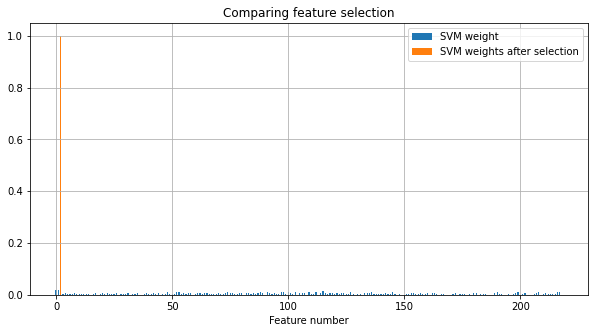

caracteristicas:  2
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.051775338401141


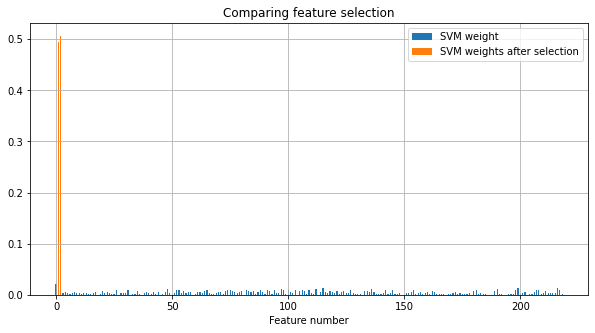

caracteristicas:  3
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.6179521093618225


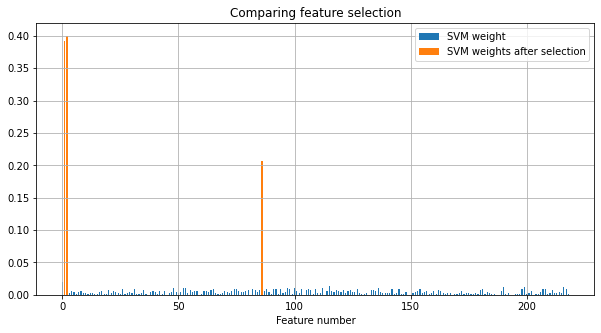

caracteristicas:  4
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -1.5481369680741195


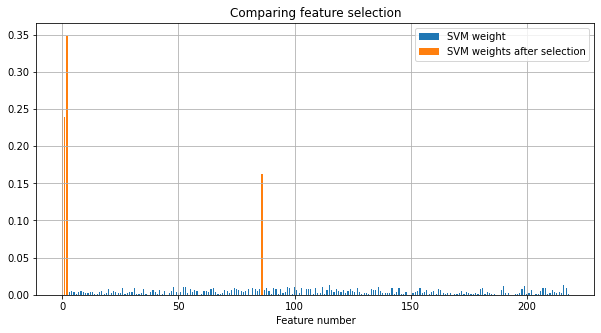

caracteristicas:  5
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -1.9994235704153178


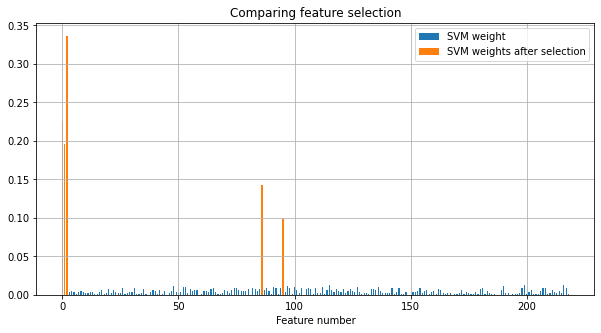

caracteristicas:  6
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -2.2983864065571806


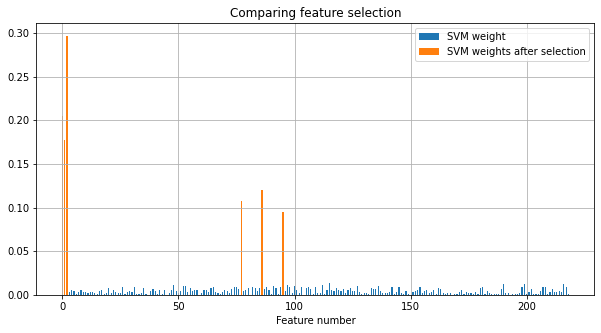

caracteristicas:  7
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -2.3915735383507317


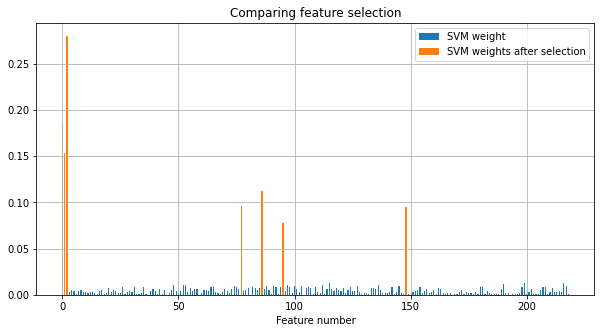

caracteristicas:  8
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -2.4699410335368395


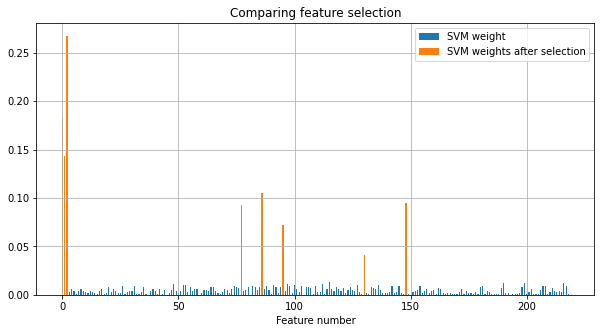

caracteristicas:  9
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -2.6508152791133757


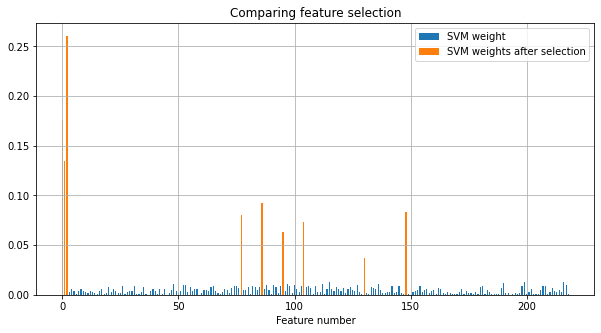

caracteristicas:  10
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.155281413976665


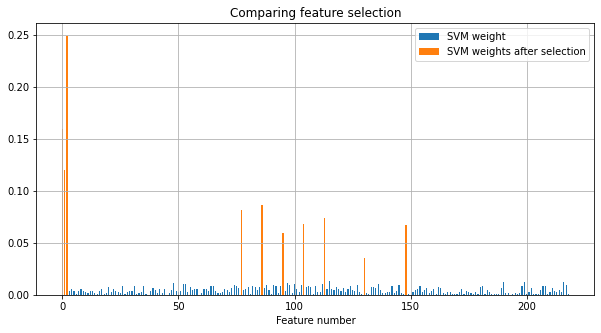

caracteristicas:  11
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.340976880232218


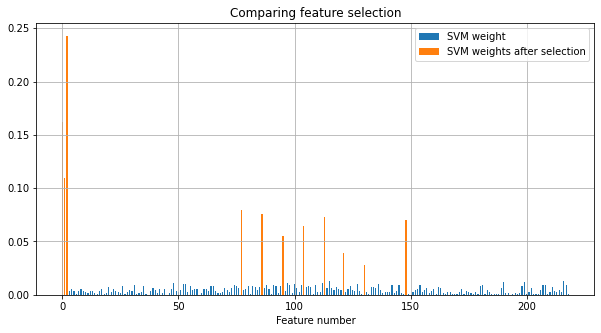

caracteristicas:  12
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.601079464170411


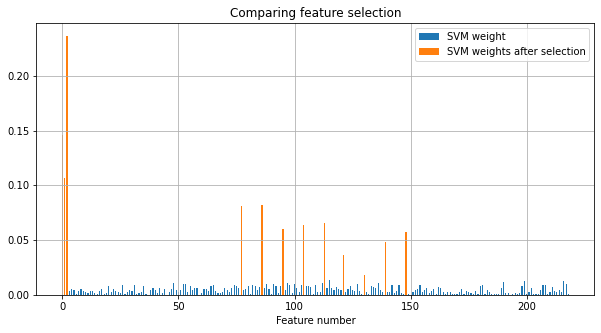

caracteristicas:  13
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.274353701898889


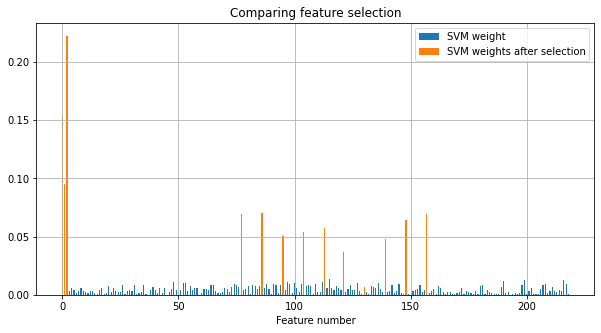

caracteristicas:  14
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.1890185692515223


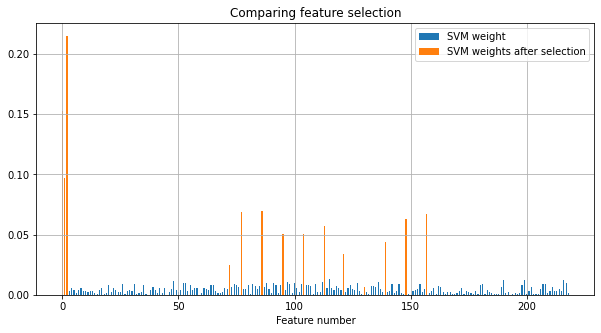

caracteristicas:  15
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.294270975812225


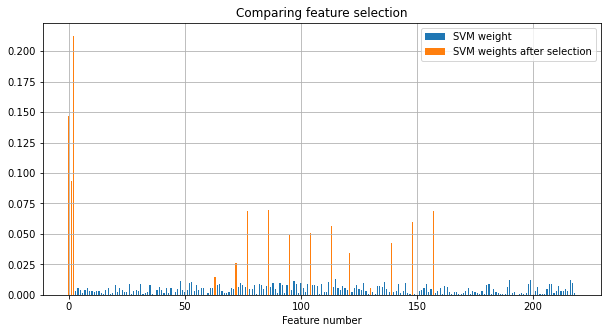

caracteristicas:  16
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.248087341217188


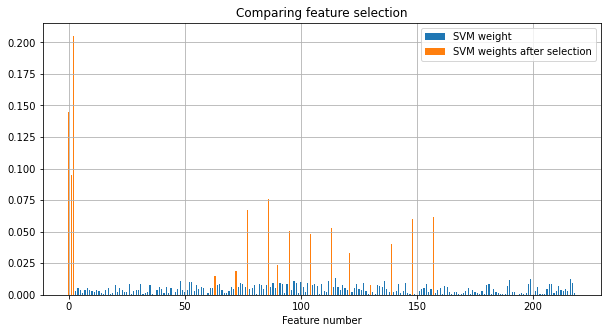

caracteristicas:  17
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.2181095784562777


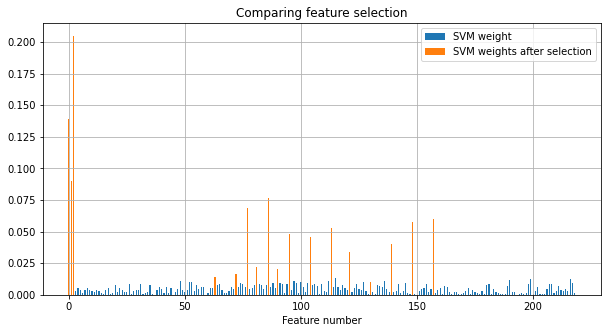

caracteristicas:  18
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.3293948076152233


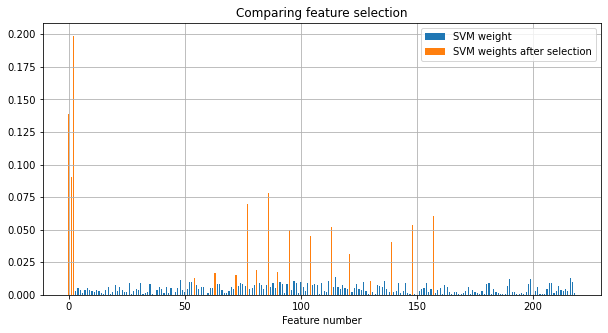

caracteristicas:  19
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.500246919601043


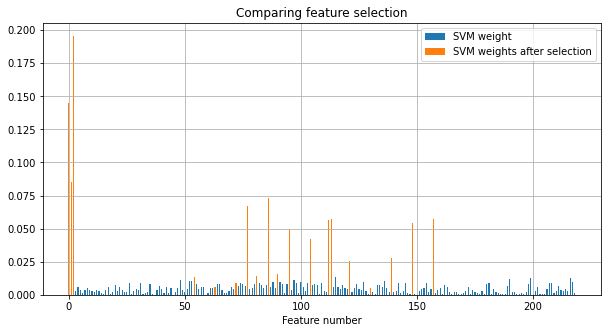

caracteristicas:  20
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.6710736996075513


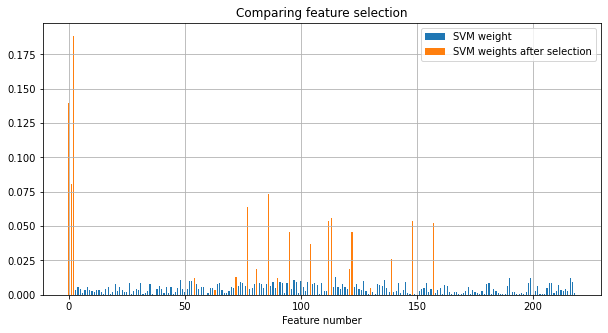

caracteristicas:  21
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.753400399092677


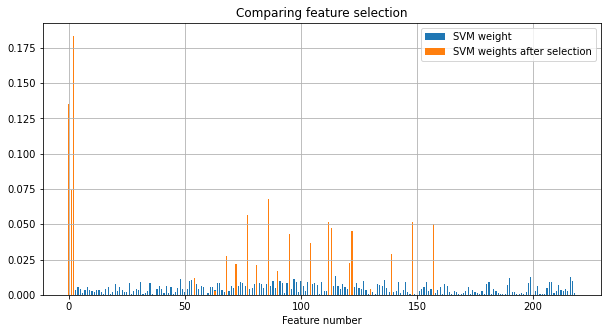

caracteristicas:  22
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.7043988885206325


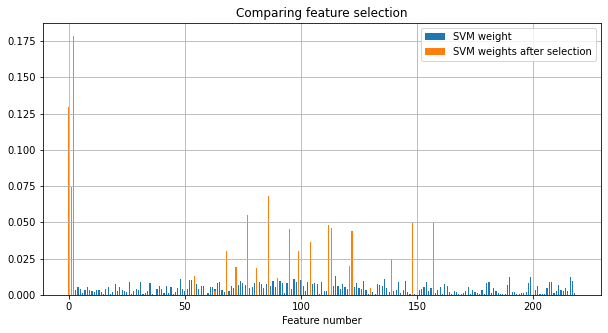

caracteristicas:  23
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.950937496444812


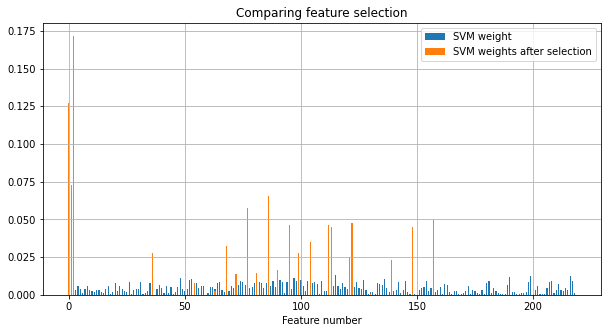

caracteristicas:  24
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.040308972507202


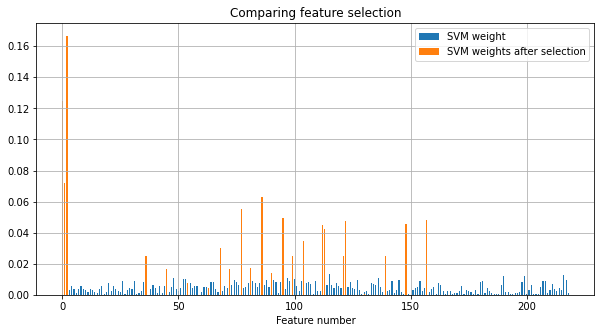

caracteristicas:  25
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.049686012725157


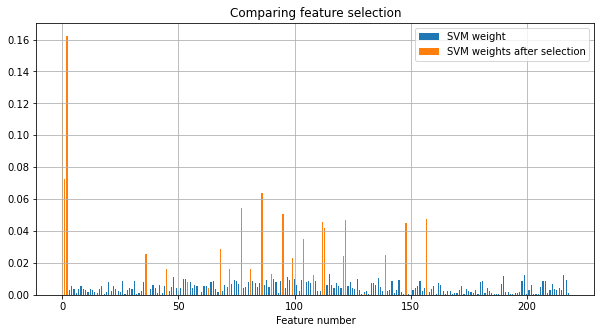

caracteristicas:  26
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.205380396354939


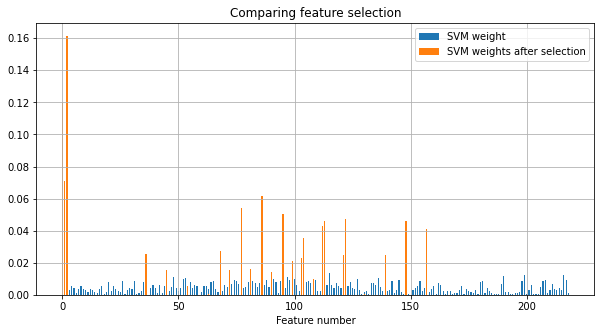

caracteristicas:  27
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.2639204506650126


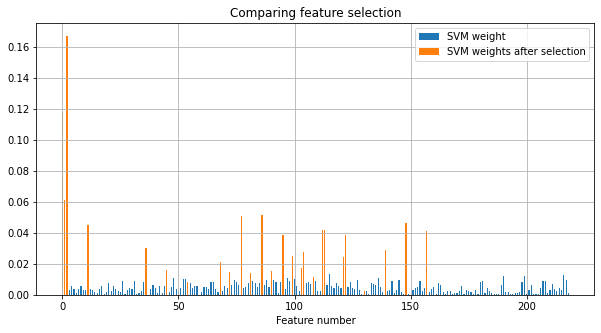

caracteristicas:  28
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.4393556736307325


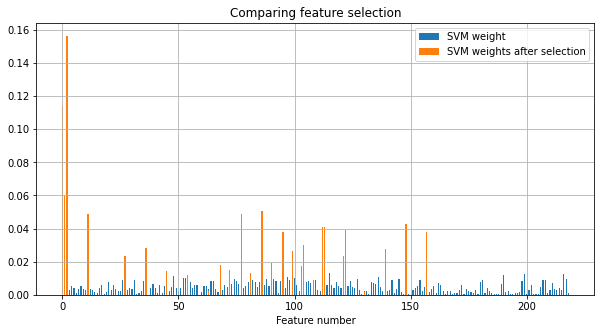

caracteristicas:  29
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.4834939411905568


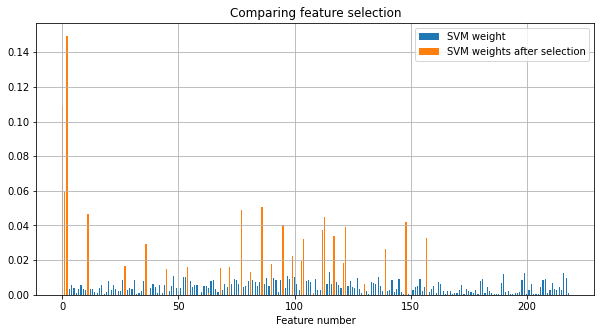

caracteristicas:  30
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.545574568823012


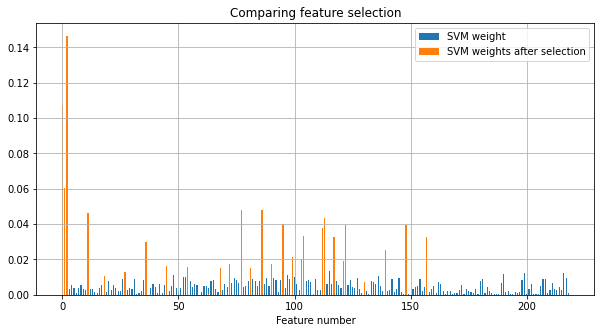

caracteristicas:  31
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.5412760775291297


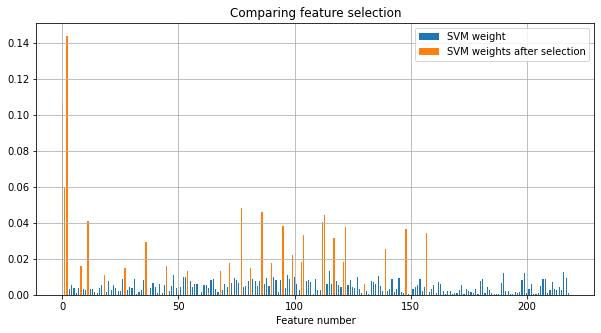

caracteristicas:  32
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.533325838412048


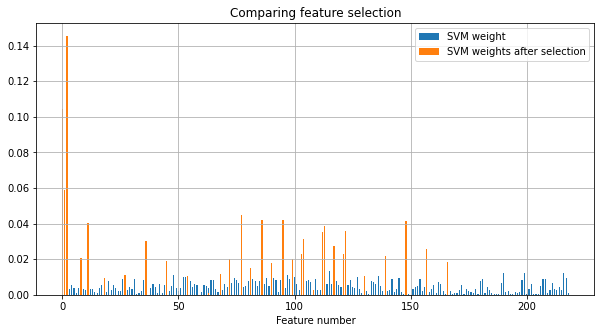

caracteristicas:  33
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.4573806900132222


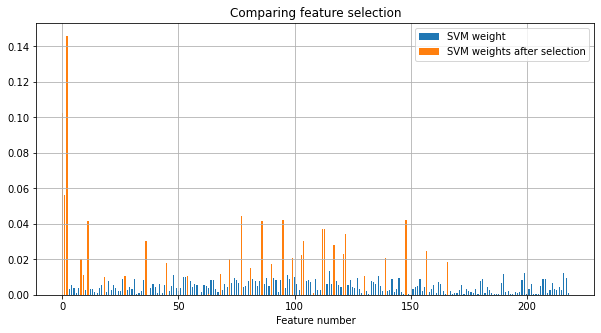

caracteristicas:  34
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.5976689726491617


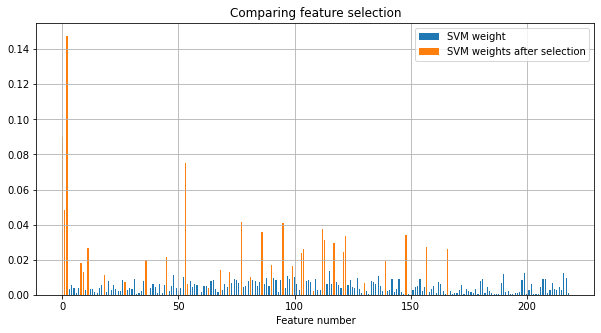

caracteristicas:  35
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.5459800704288265


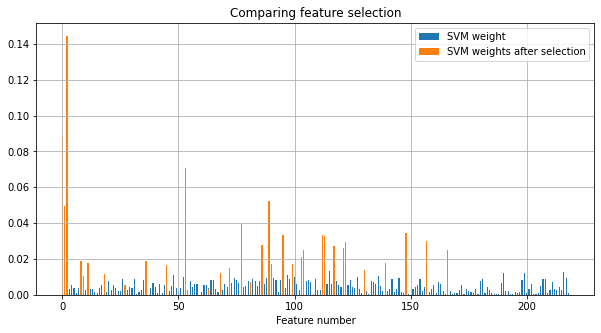

caracteristicas:  36
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.460236257365816


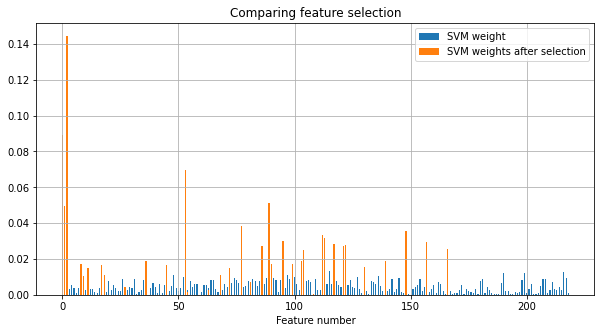

caracteristicas:  37
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.5729245075780867


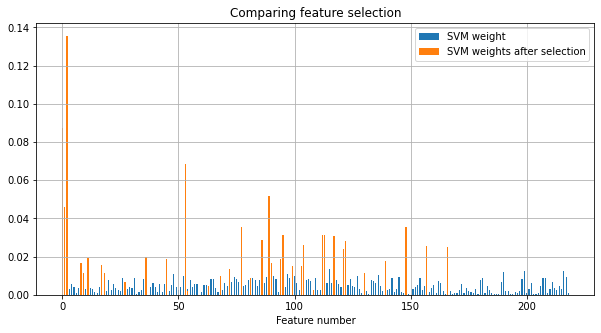

caracteristicas:  38
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.2336757816094854


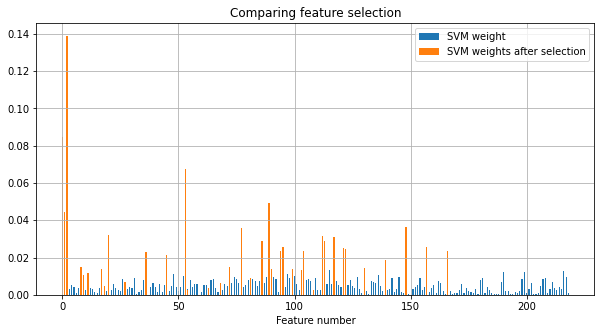

caracteristicas:  39
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.463669636852835


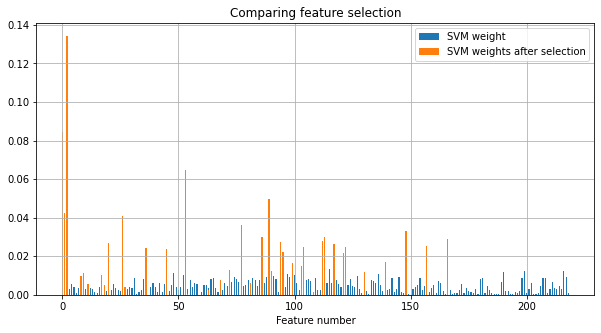

caracteristicas:  40
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.422015643049405


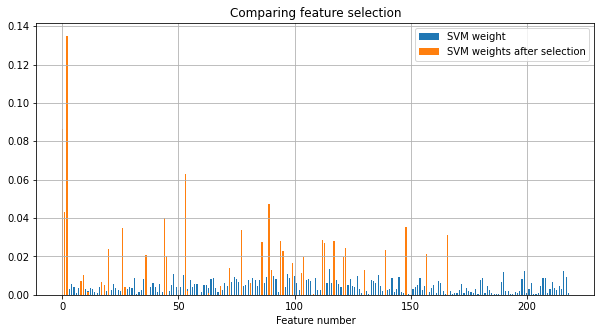

caracteristicas:  41
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.4345993881633907


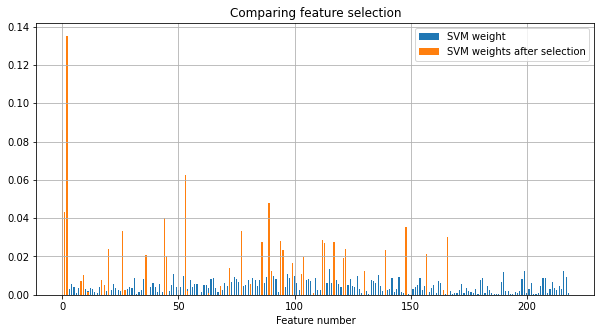

caracteristicas:  42
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.4811795689987006


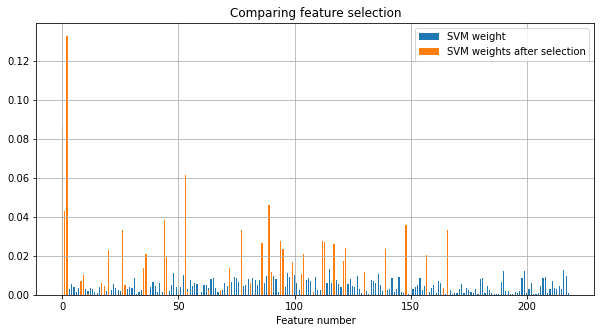

caracteristicas:  43
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.371283522487116


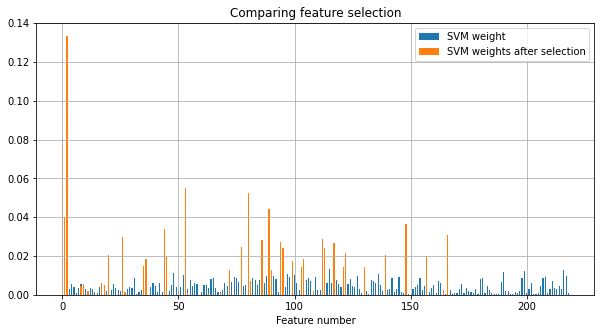

caracteristicas:  44
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.380750619229711


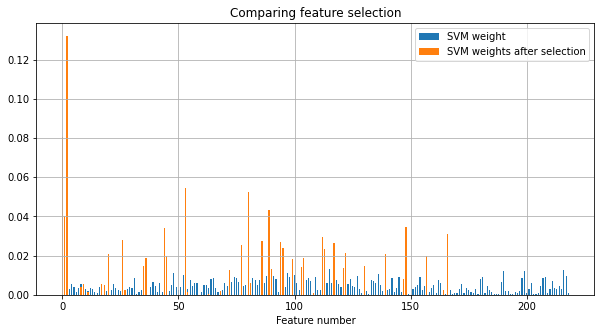

caracteristicas:  45
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -3.7653786391822806


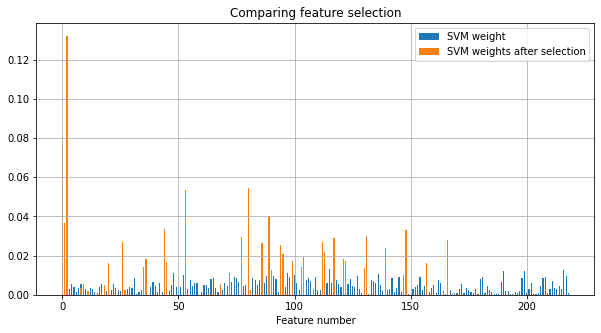

caracteristicas:  46
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.036616412752262


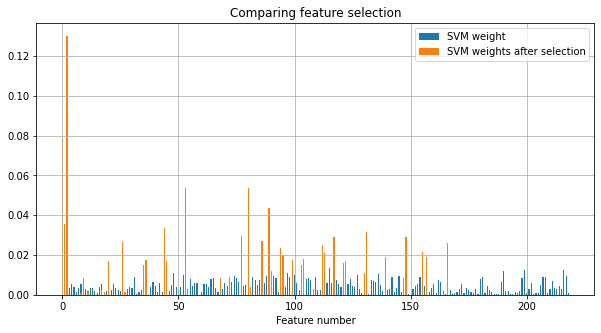

caracteristicas:  47
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.0937130557422705


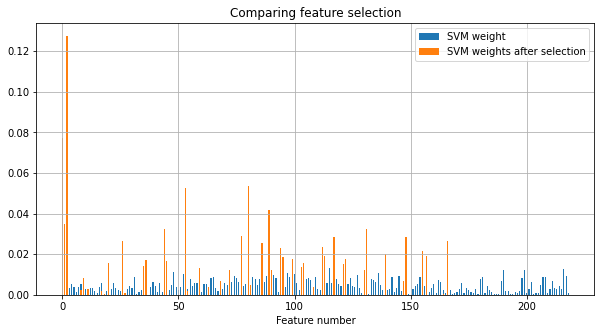

caracteristicas:  48
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.218272138322241


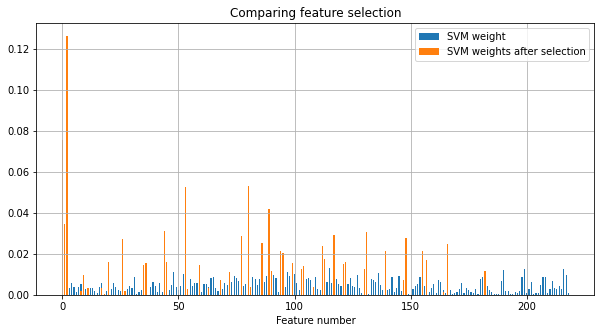

caracteristicas:  49
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.330364293816156


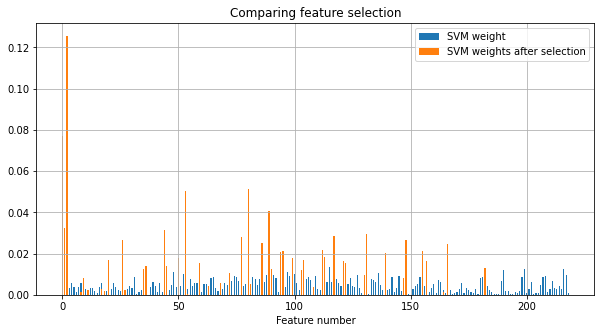

caracteristicas:  50
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.28084692710765


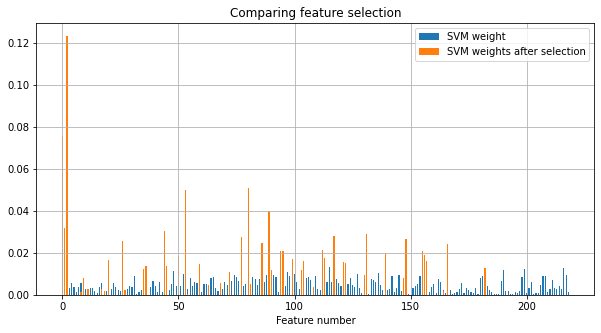

caracteristicas:  51
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.335460651109562


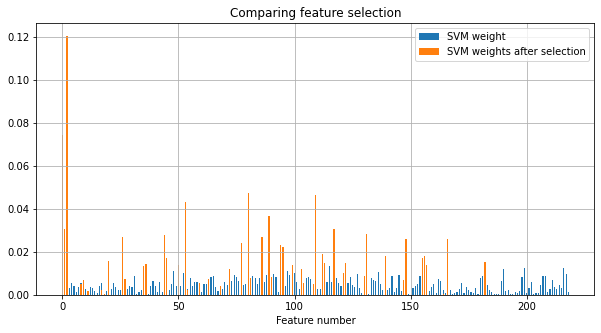

caracteristicas:  52
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.306960359870982


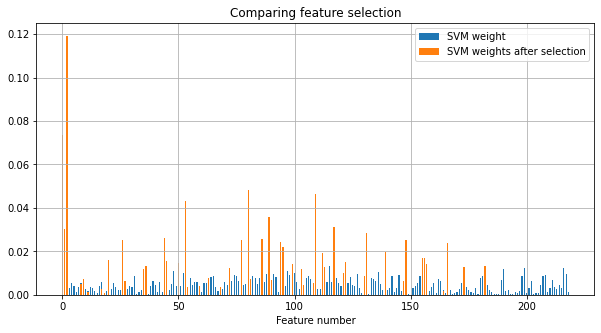

caracteristicas:  53
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.315579366895021


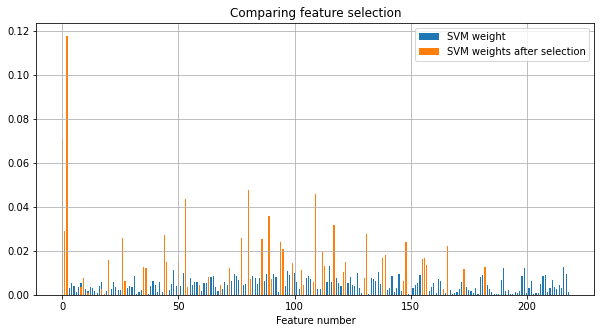

caracteristicas:  54
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.184196611873944


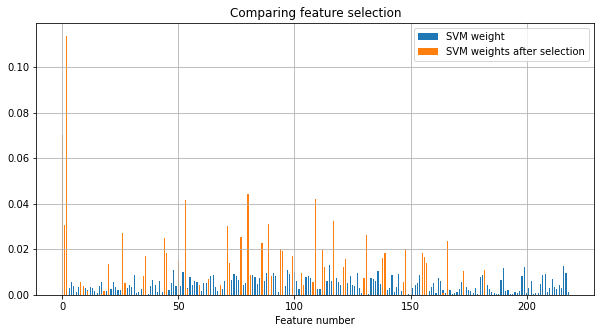

caracteristicas:  55
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.1563465037737


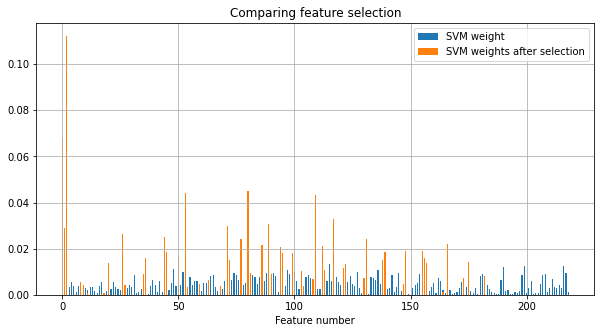

caracteristicas:  56
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.416225260650278


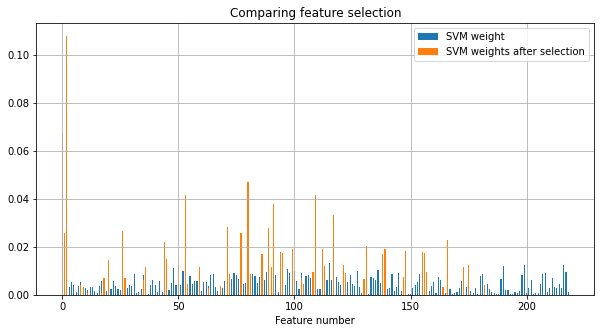

caracteristicas:  57
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.53240975147064


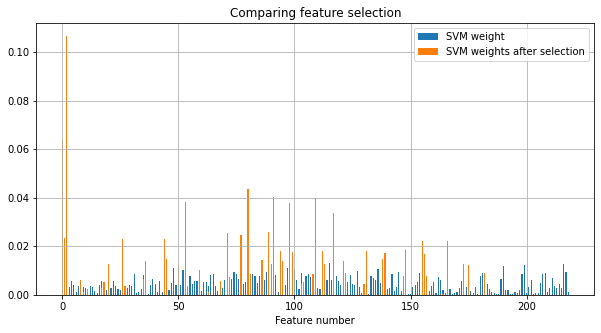

caracteristicas:  58
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.348800688282099


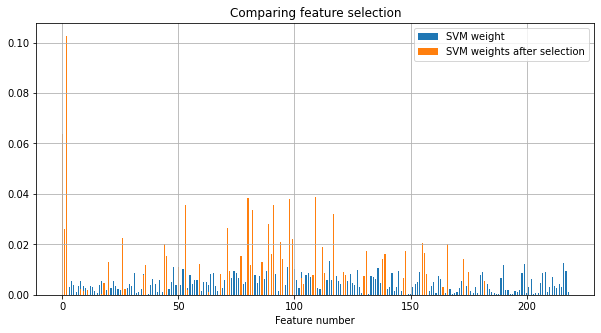

caracteristicas:  59
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.343006572076926


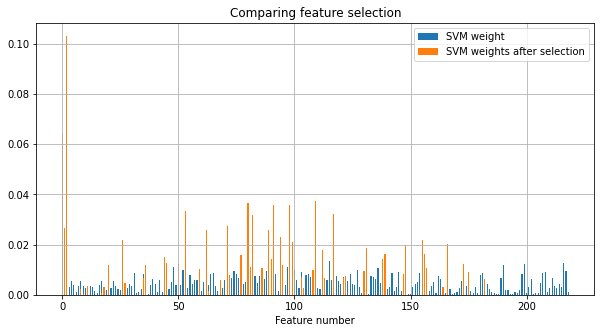

caracteristicas:  60
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.328821346660052


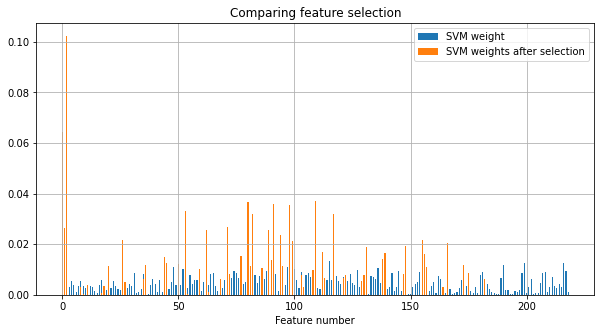

caracteristicas:  61
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.562446901282451


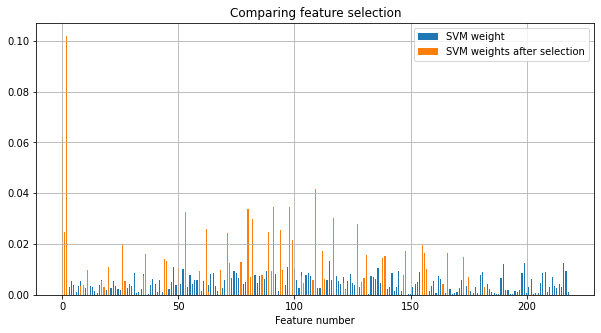

caracteristicas:  62
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.328064926334201


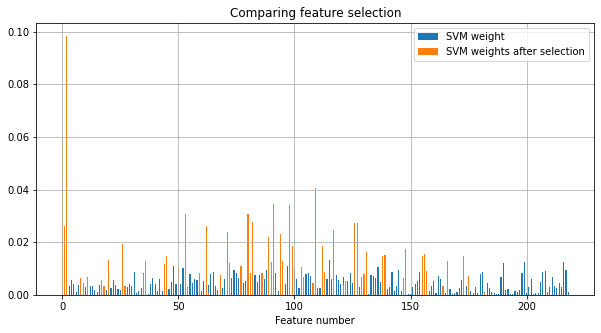

caracteristicas:  63
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.333185221623594


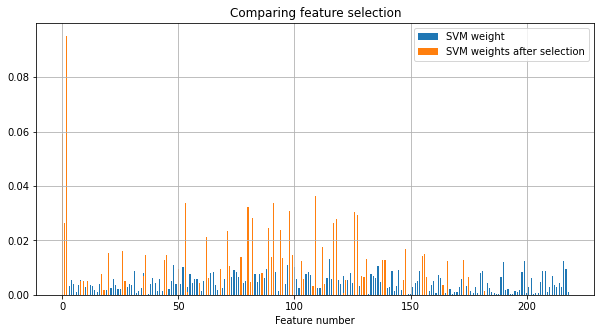

caracteristicas:  64
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.326792345287997


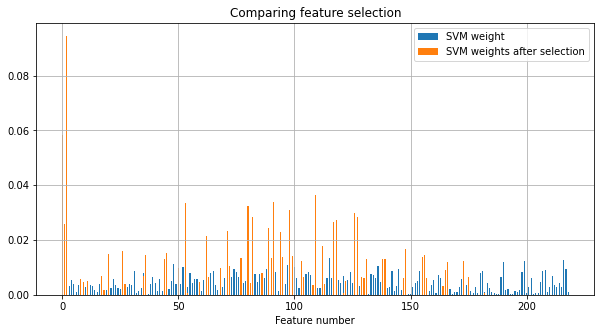

caracteristicas:  65
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.322196503154875


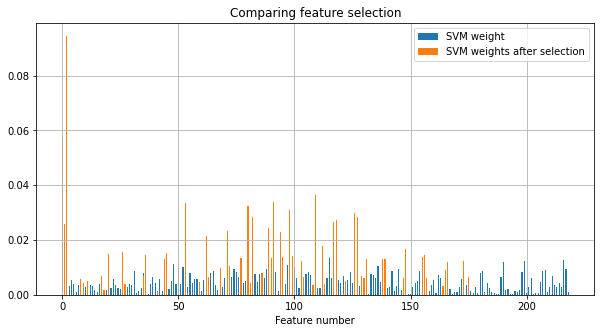

caracteristicas:  66
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.3153503193388945


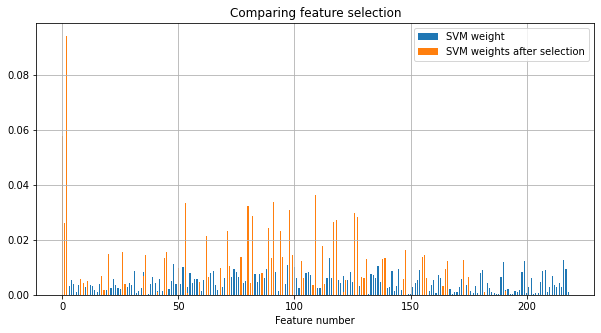

caracteristicas:  67
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.326115929097806


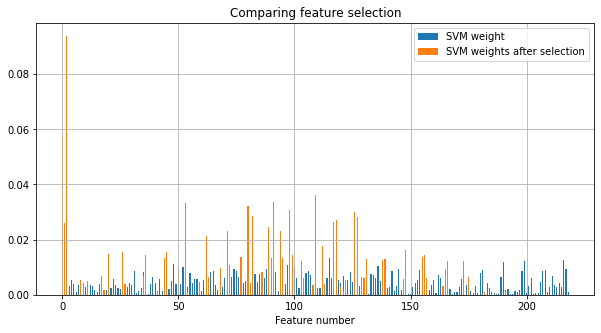

caracteristicas:  68
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.335340551830579


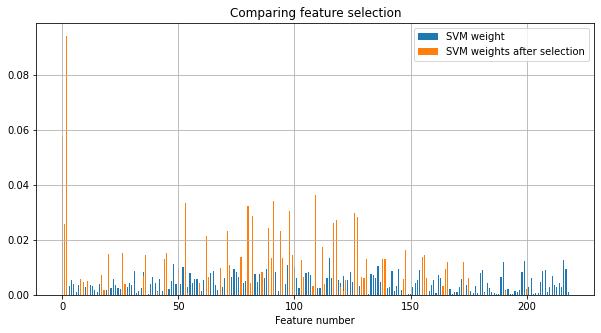

caracteristicas:  69
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.272143195049896


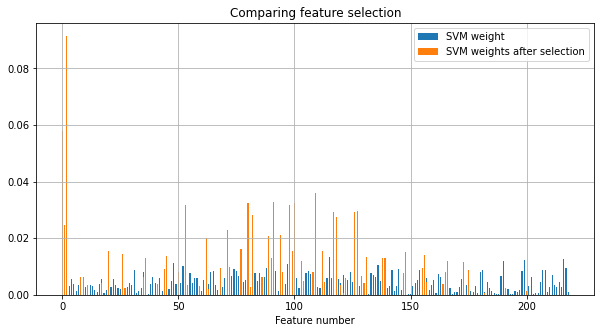

caracteristicas:  70
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.258329930661747


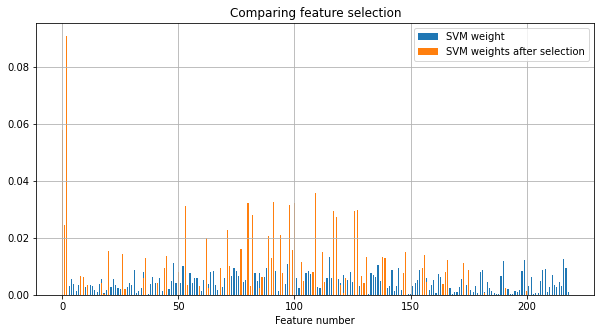

caracteristicas:  71
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.52118399509861


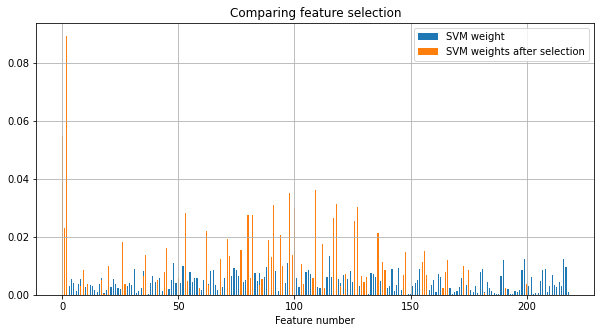

caracteristicas:  72
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.654387041942818


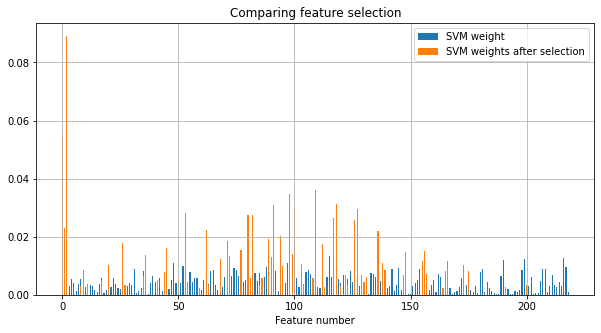

caracteristicas:  73
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.569919279119607


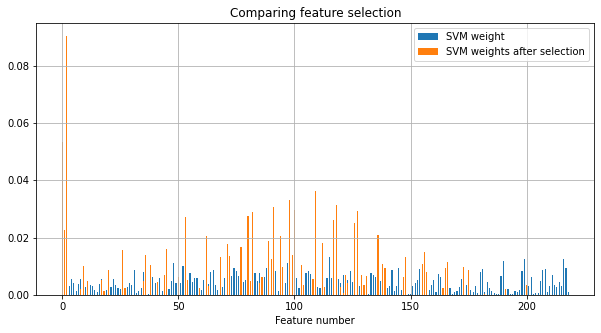

caracteristicas:  74
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.461013742289761


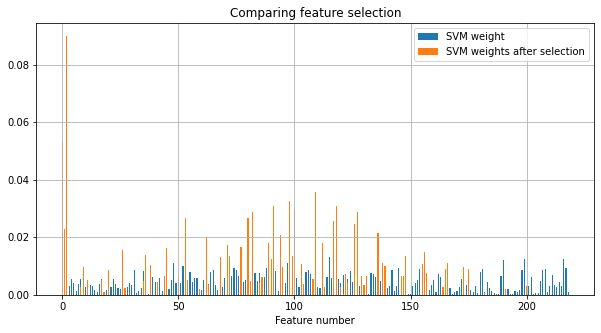

caracteristicas:  75
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.764886502100051


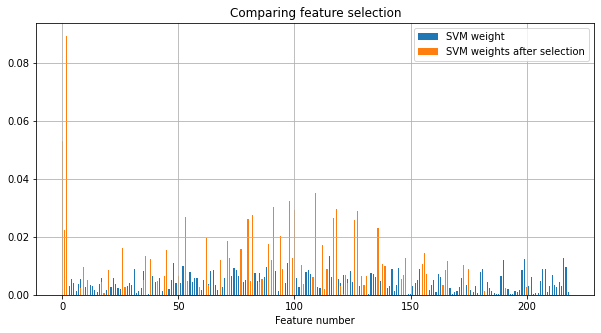

caracteristicas:  76
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.873852141994179


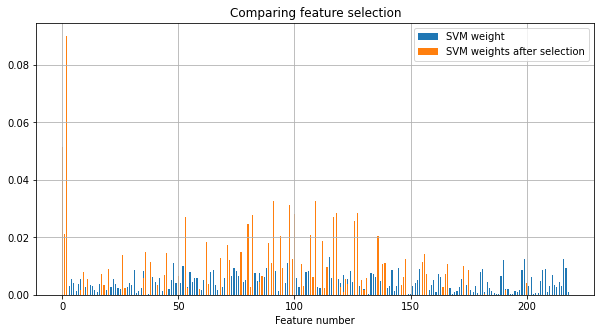

caracteristicas:  77
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.84686424713644


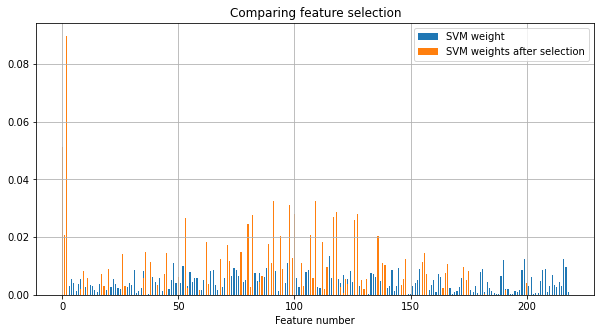

caracteristicas:  78
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.777101753381229


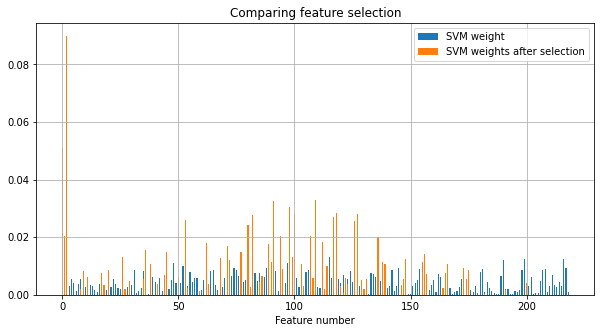

caracteristicas:  79
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.777925126948149


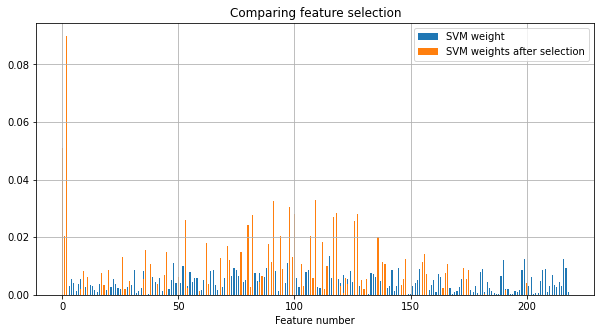

caracteristicas:  80
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.535345116019786


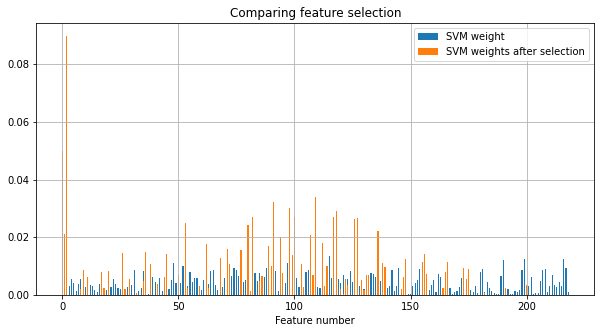

caracteristicas:  81
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.52189835156773


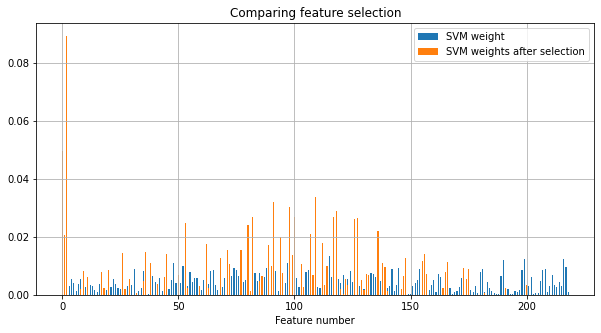

caracteristicas:  82
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.539220303743222


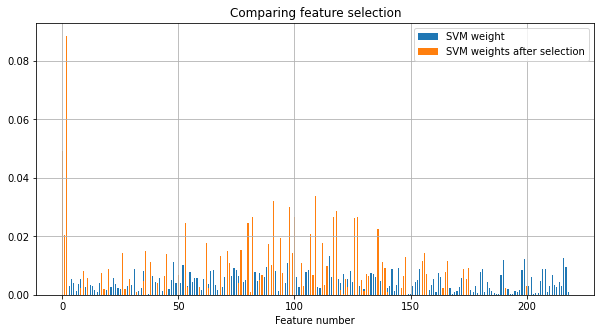

caracteristicas:  83
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.781985093744569


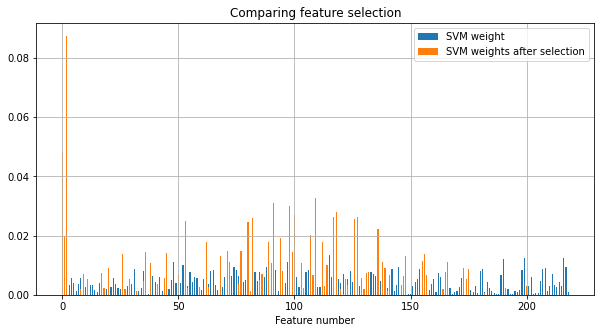

caracteristicas:  84
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.692998671410435


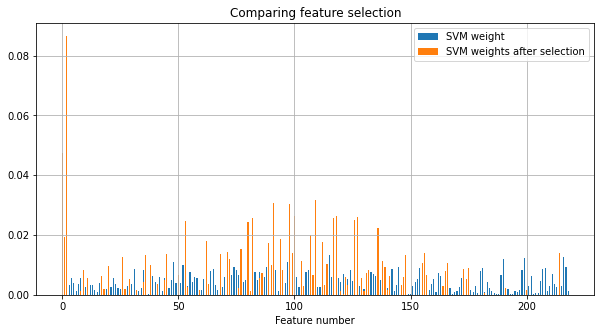

caracteristicas:  85
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -4.79220643211828


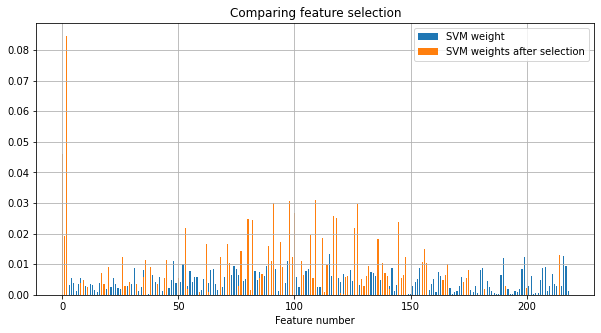

caracteristicas:  86
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.032193076830423


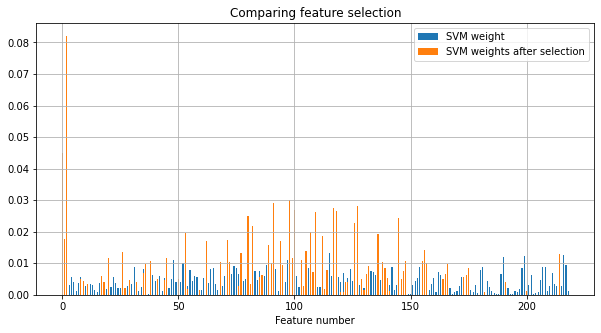

caracteristicas:  87
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.252478900430199


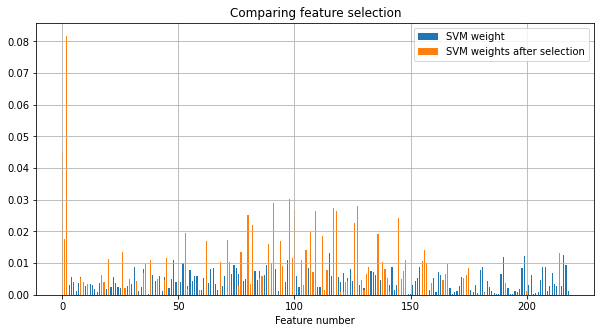

caracteristicas:  88
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.235245422131088


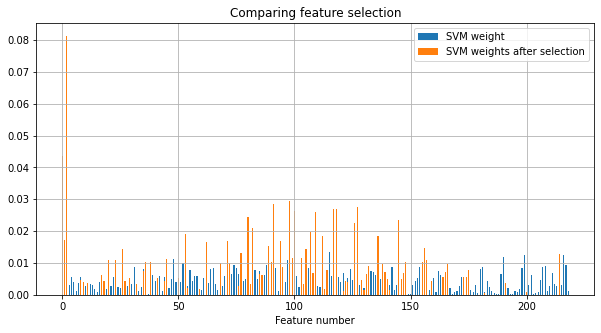

caracteristicas:  89
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.266709602681786


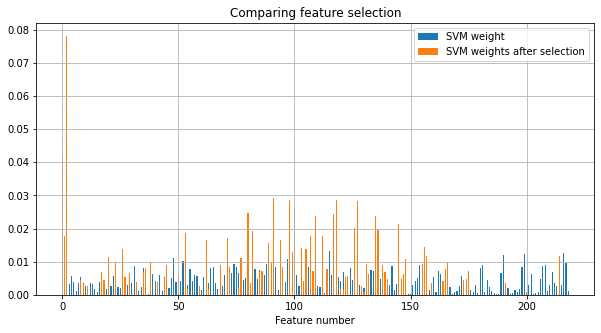

caracteristicas:  90
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.357723833934505


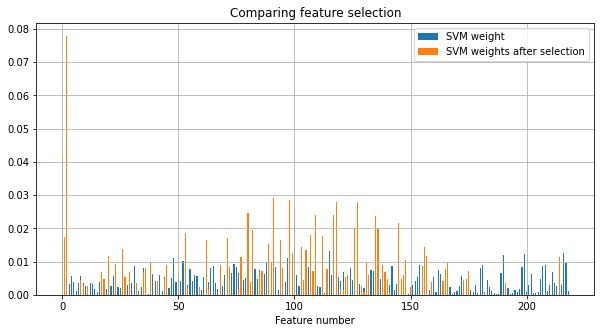

caracteristicas:  91
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.479418815758313


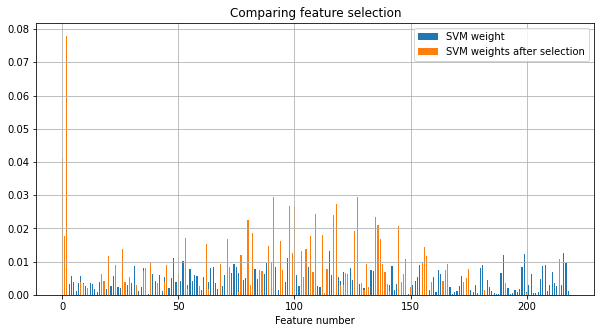

caracteristicas:  92
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.4131640595270385


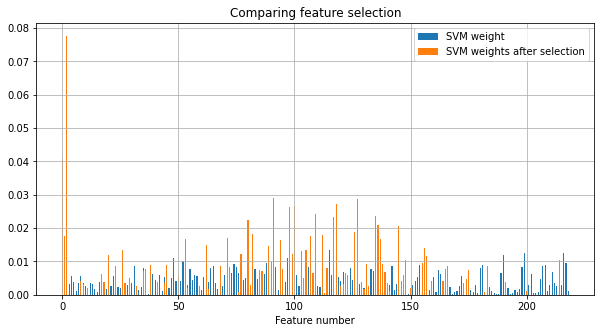

caracteristicas:  93
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.334160988870539


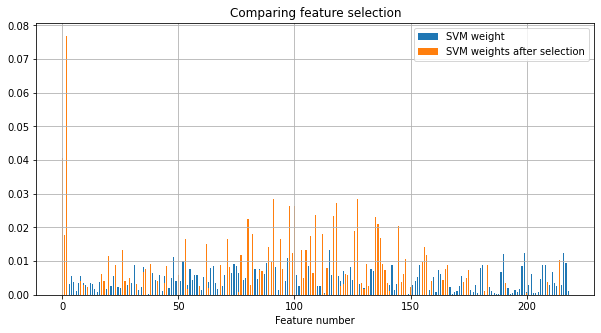

caracteristicas:  94
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.377560487279788


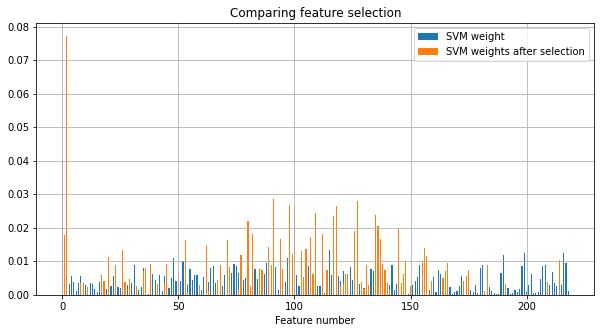

caracteristicas:  95
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.3617209447115615


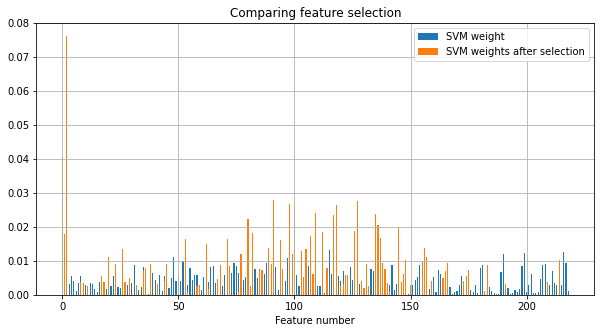

caracteristicas:  96
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.330189516937649


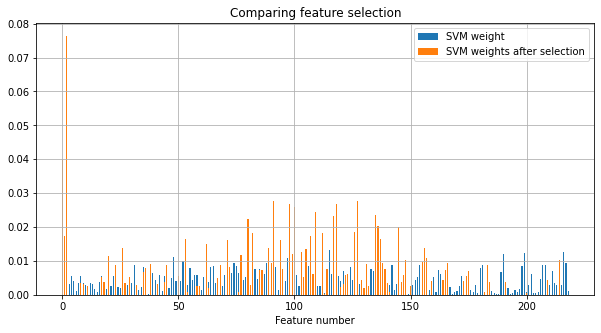

caracteristicas:  97
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.286811803735689


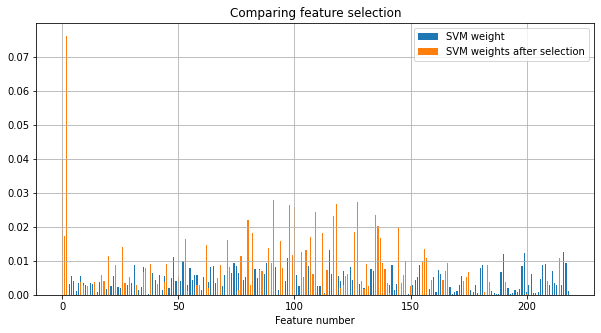

caracteristicas:  98
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.288488769531373


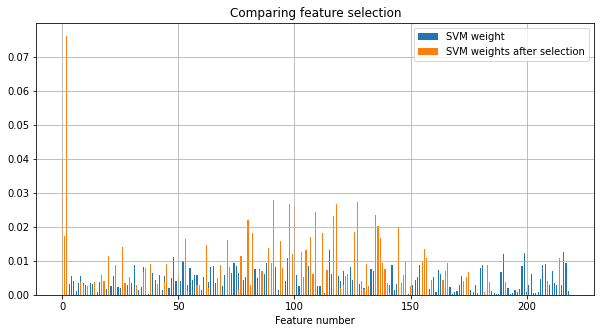

caracteristicas:  99
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.246763233261957


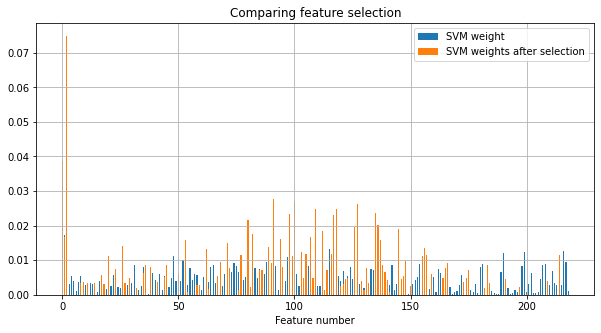

caracteristicas:  100
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.228096272870357


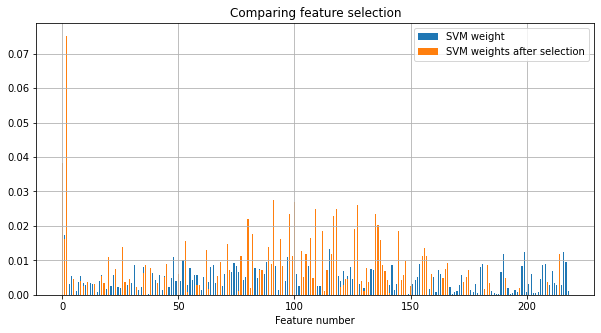

caracteristicas:  101
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.116866626990536


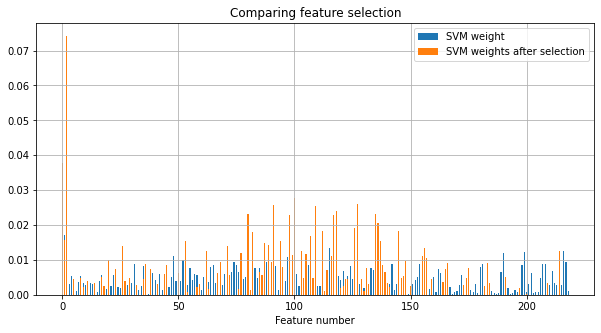

caracteristicas:  102
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.03081112246203


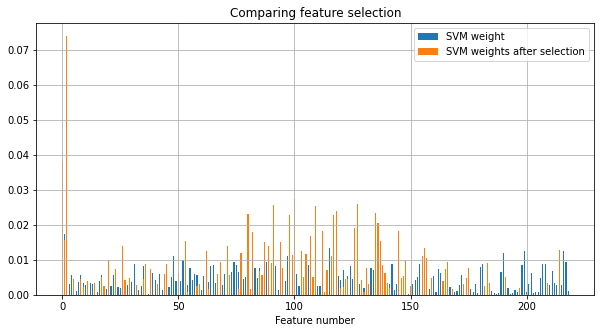

caracteristicas:  103
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.023138505028967


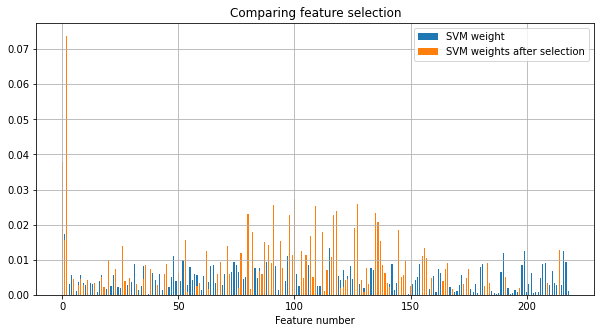

caracteristicas:  104
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.797875324502988


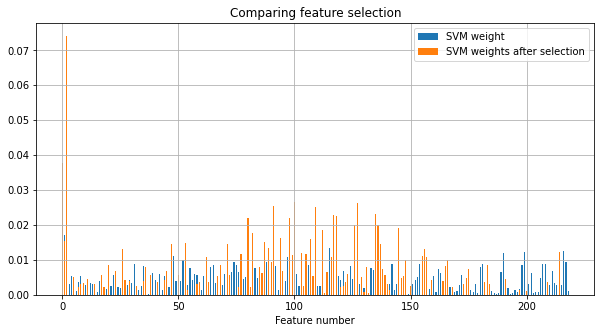

caracteristicas:  105
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.96707339586448


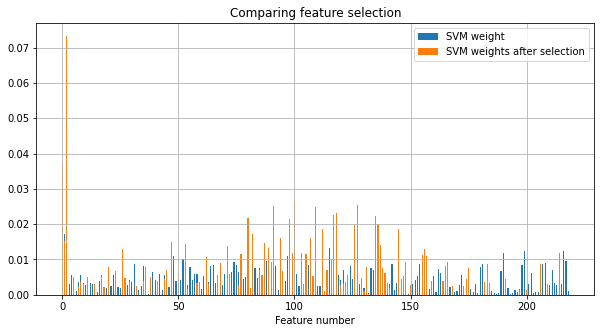

caracteristicas:  106
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.943694993125837


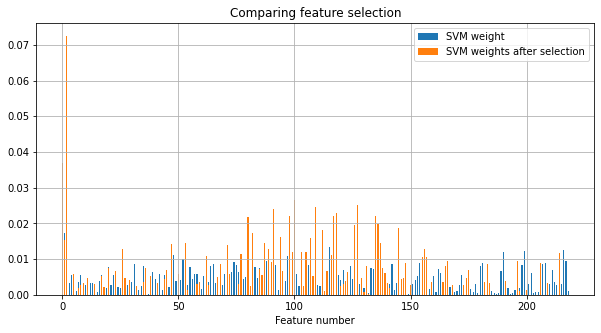

caracteristicas:  107
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.93991836353332


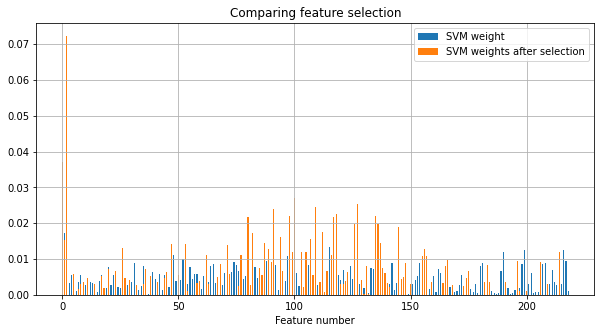

caracteristicas:  108
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.318466374400543


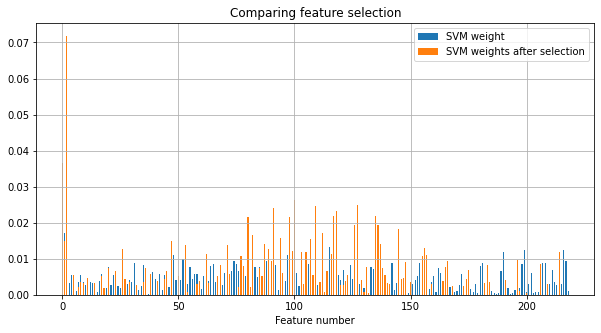

caracteristicas:  109
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.963900140287294


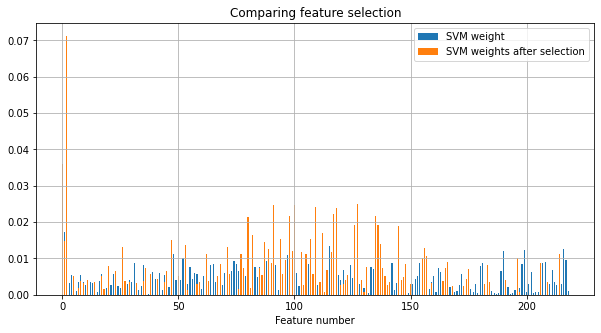

caracteristicas:  110
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.985366090856707


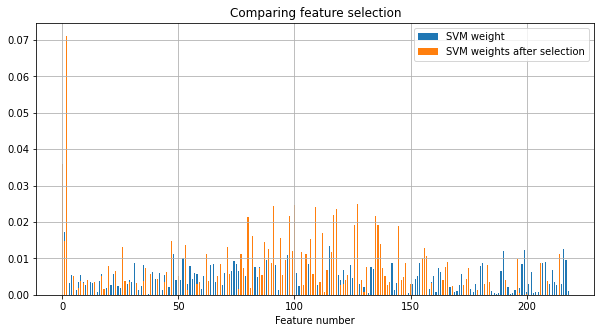

caracteristicas:  111
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.013578501203167


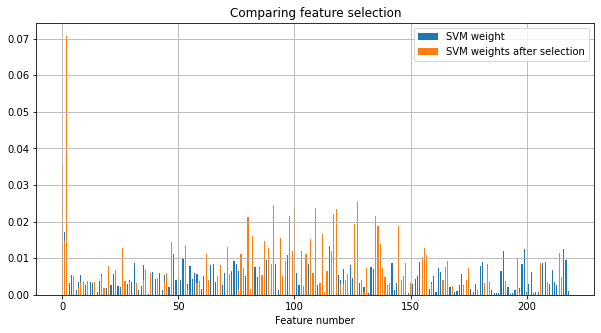

caracteristicas:  112
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.963882655078541


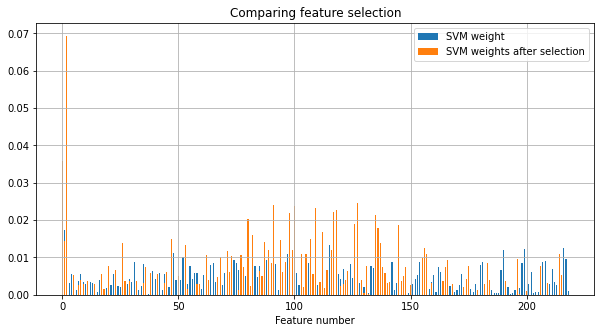

caracteristicas:  113
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.915244010551384


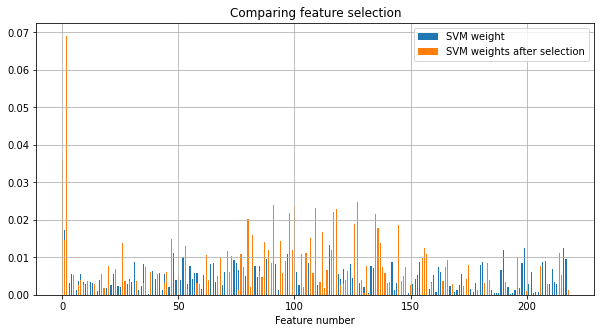

caracteristicas:  114
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.244292785090503


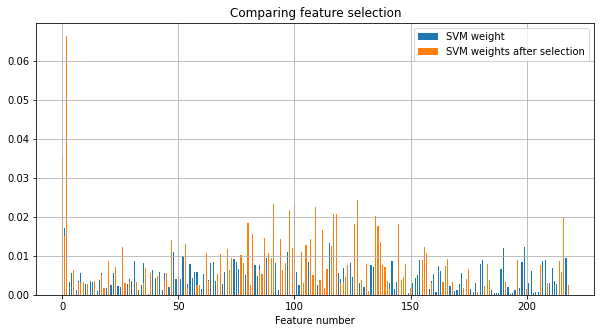

caracteristicas:  115
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.295940799052333


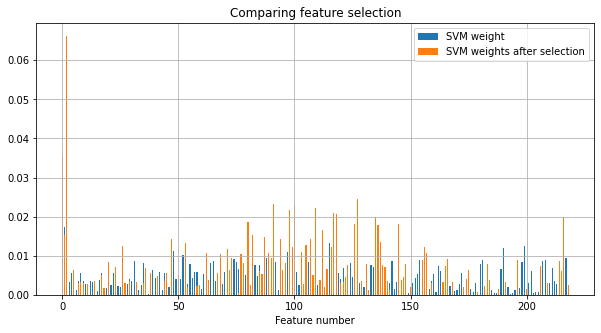

caracteristicas:  116
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.292084436100047


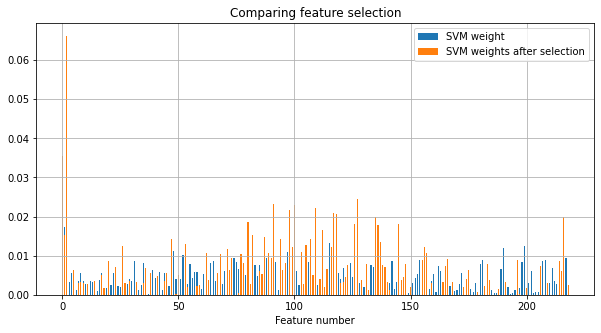

caracteristicas:  117
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.202668950516162


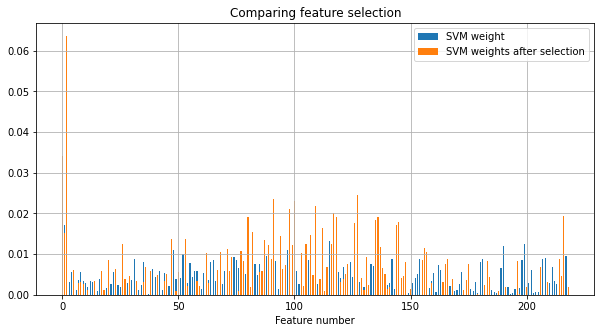

caracteristicas:  118
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.242633564672917


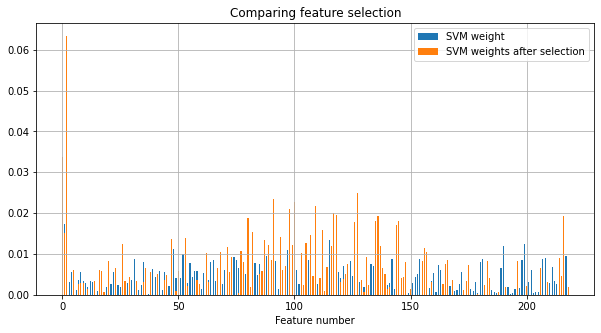

caracteristicas:  119
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.106673929173745


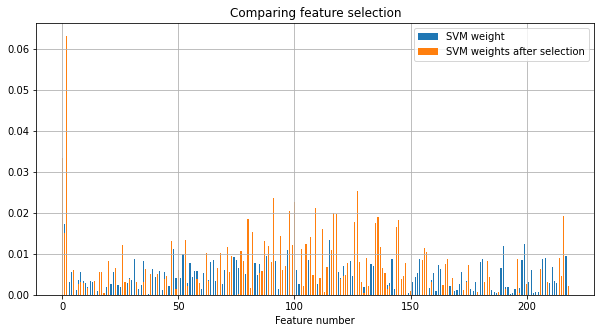

caracteristicas:  120
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.134361986198496


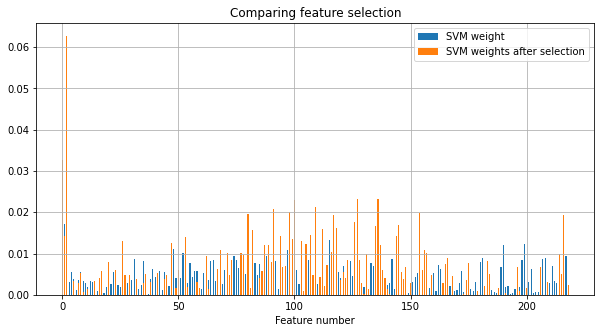

caracteristicas:  121
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.369458216437299


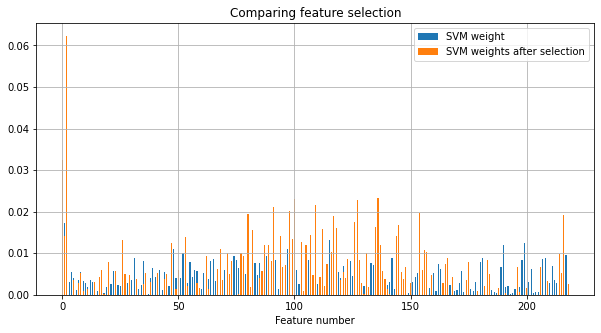

caracteristicas:  122
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.407865161939571


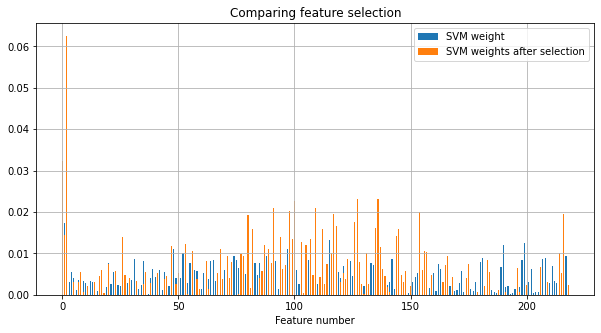

caracteristicas:  123
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.283291817679427


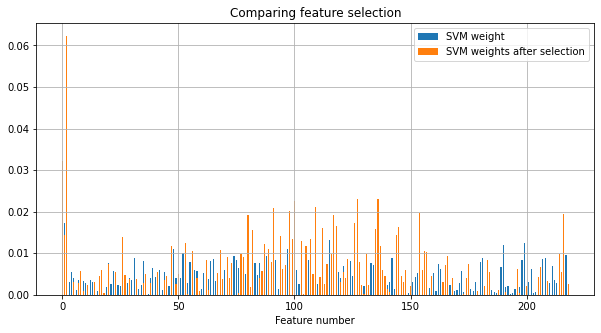

caracteristicas:  124
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.213054950228119


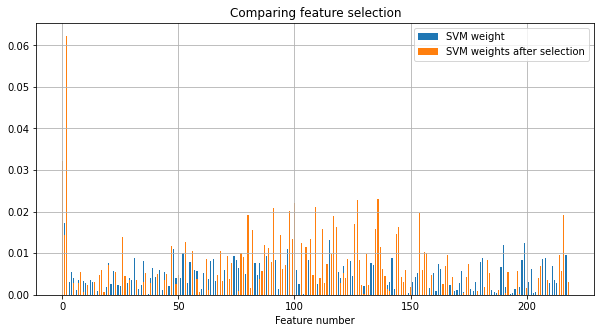

caracteristicas:  125
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.119410161028063


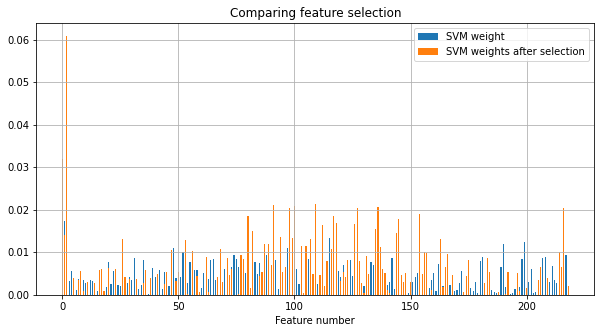

caracteristicas:  126
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.173591307563749


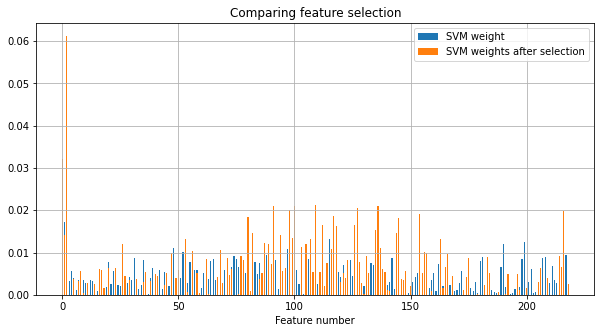

caracteristicas:  127
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.991380401655246


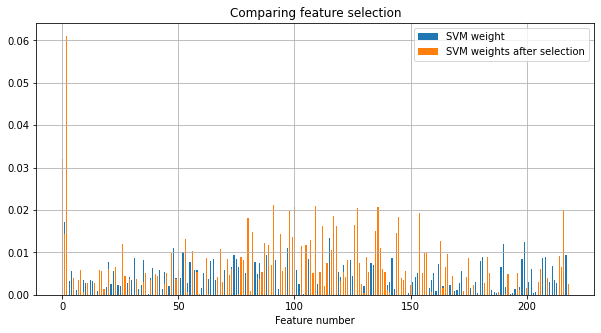

caracteristicas:  128
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.99932871355085


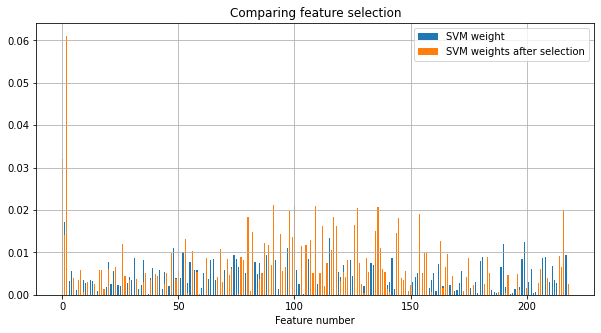

caracteristicas:  129
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.022184972059458


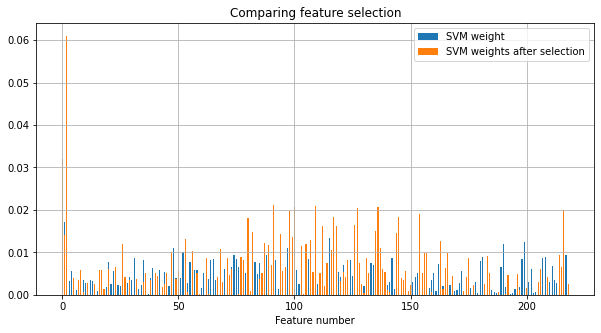

caracteristicas:  130
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.023637507641891


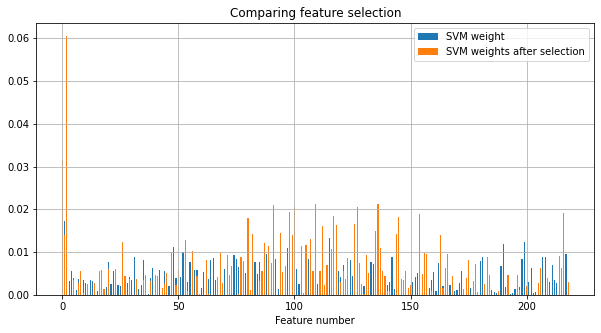

caracteristicas:  131
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.8519507434910585


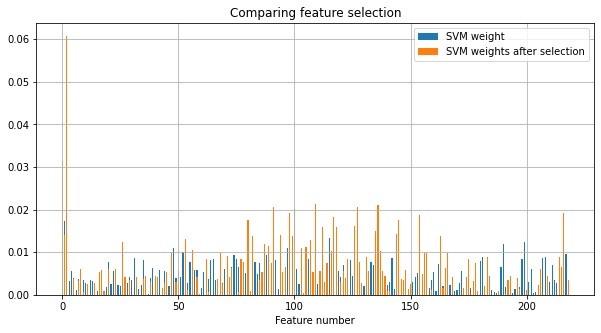

caracteristicas:  132
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.776772393596891


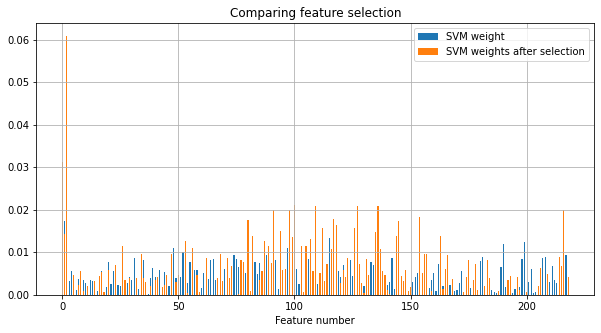

caracteristicas:  133
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.952268964638335


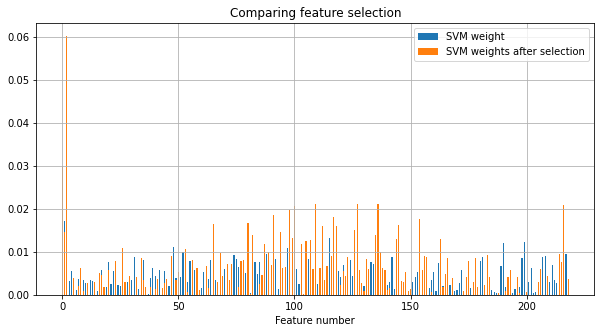

caracteristicas:  134
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.102434149844863


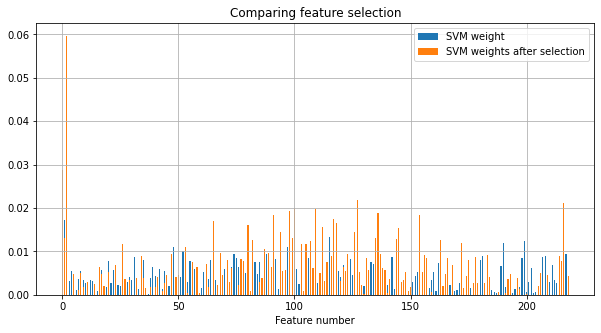

caracteristicas:  135
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.069599174080062


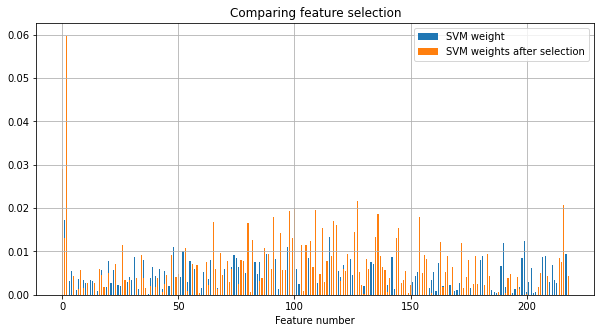

caracteristicas:  136
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.174756039424163


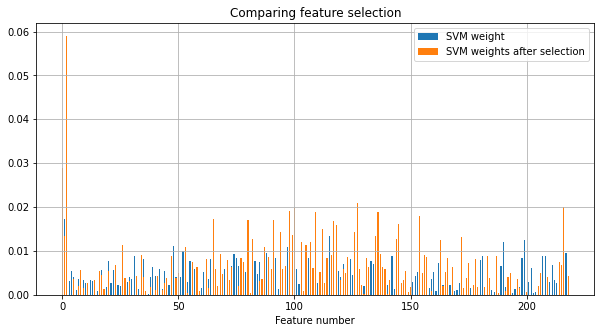

caracteristicas:  137
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.235562867976112


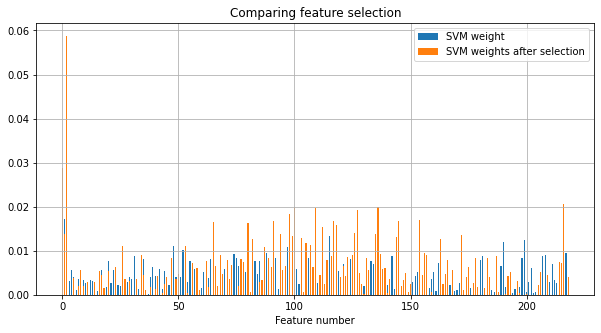

caracteristicas:  138
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.09440197225195


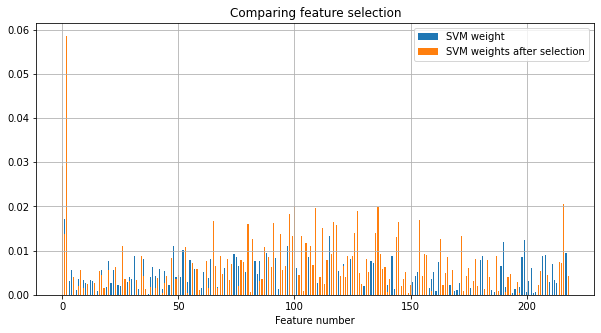

caracteristicas:  139
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.978060474178271


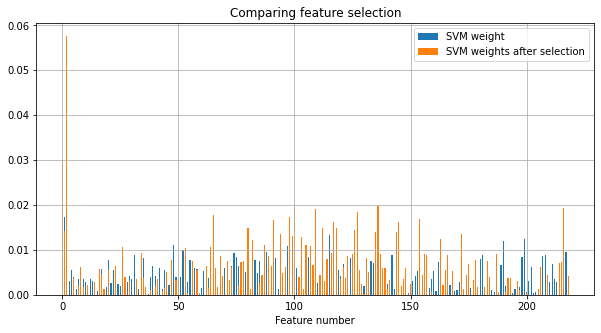

caracteristicas:  140
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.039100241270286


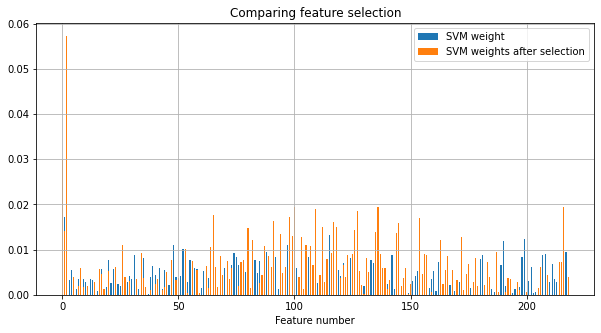

caracteristicas:  141
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.039343339933992


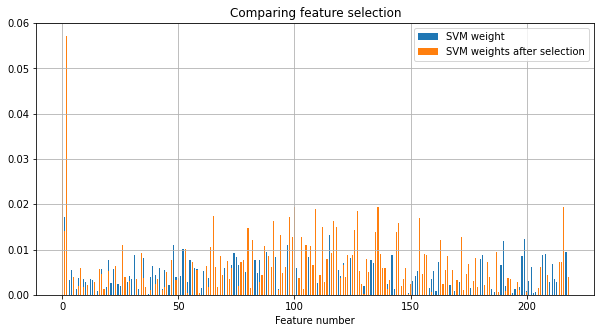

caracteristicas:  142
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.195708029537342


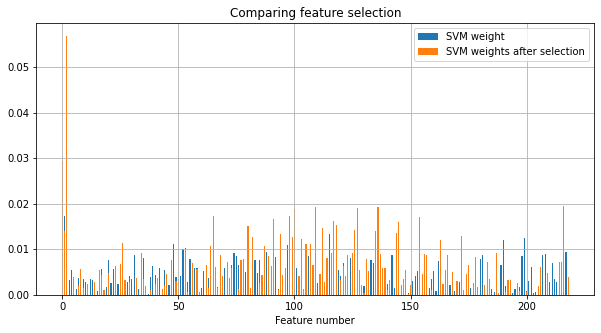

caracteristicas:  143
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.767866742710025


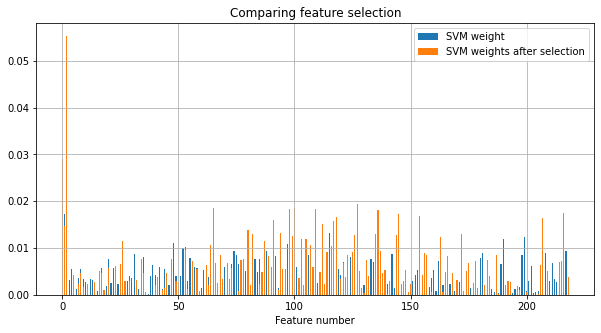

caracteristicas:  144
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -5.881208967413814


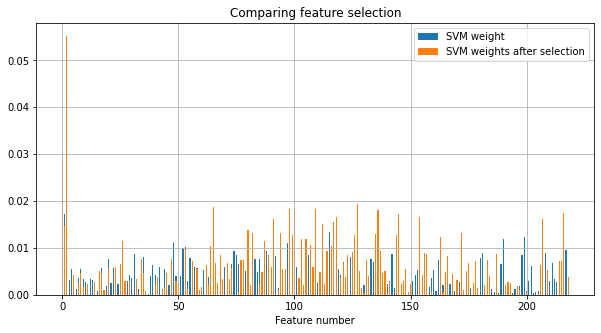

caracteristicas:  145
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.3773335462182414


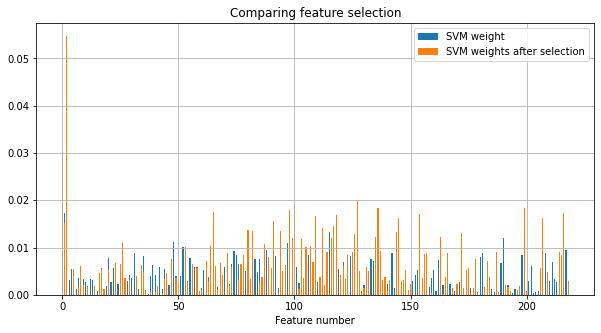

caracteristicas:  146
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.356798018538497


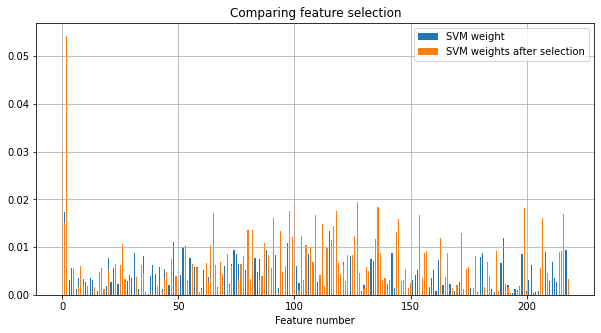

caracteristicas:  147
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.344290022238498


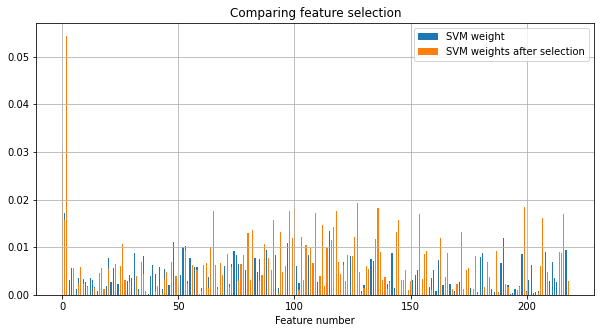

caracteristicas:  148
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.339781299490693


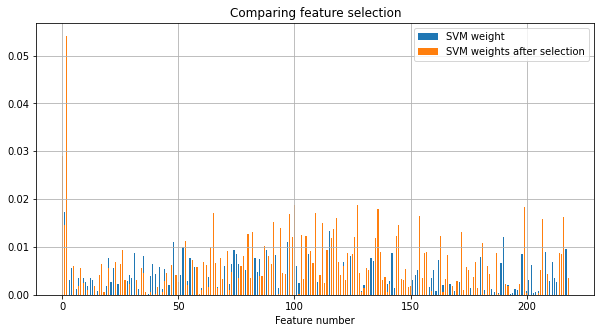

caracteristicas:  149
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.343409953259134


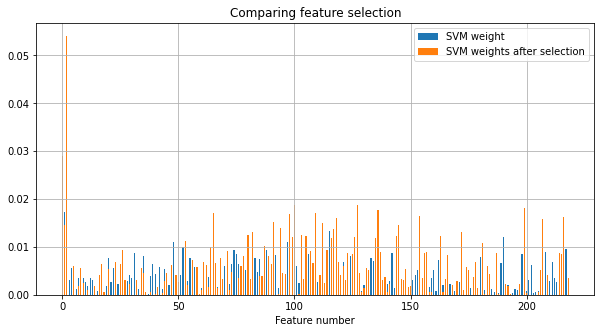

caracteristicas:  150
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.030948297381531


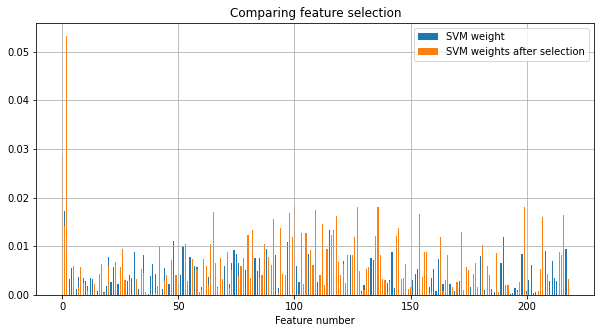

caracteristicas:  151
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.724780372776204


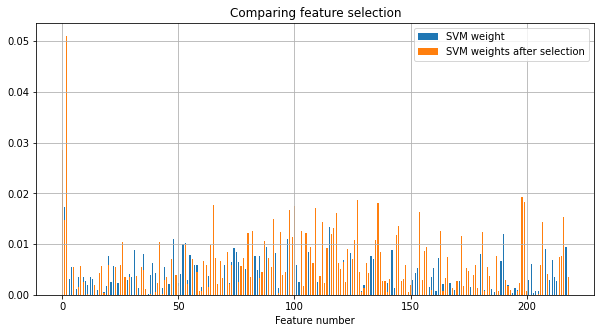

caracteristicas:  152
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.435305020722086


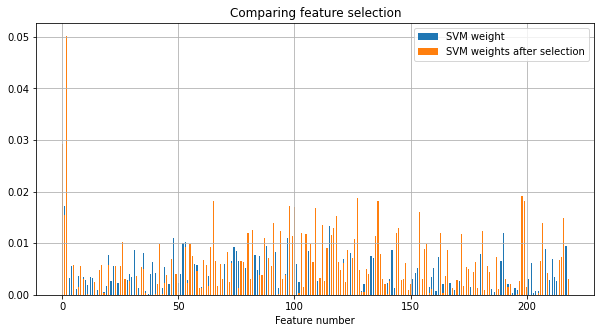

caracteristicas:  153
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.781478157946457


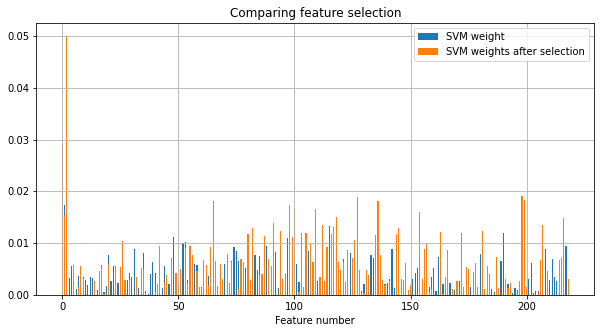

caracteristicas:  154
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.82660759795227


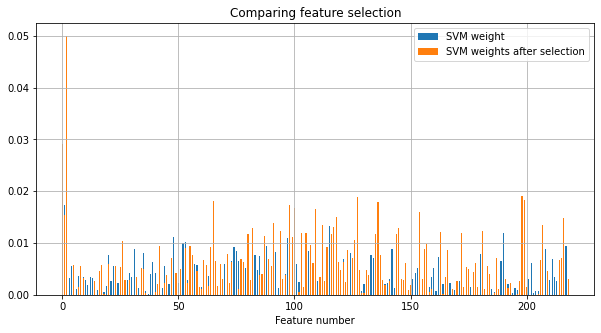

caracteristicas:  155
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.830854313500785


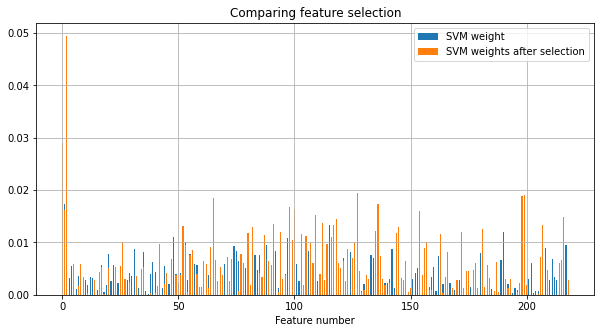

caracteristicas:  156
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.7156822034938735


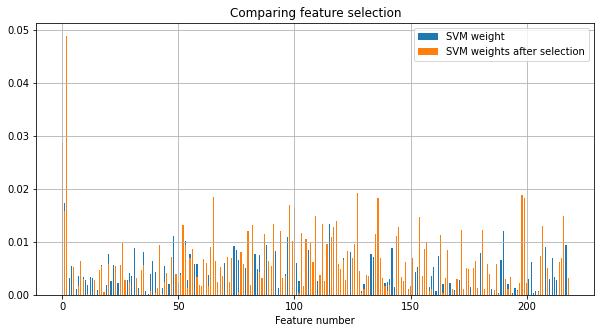

caracteristicas:  157
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.703154737036663


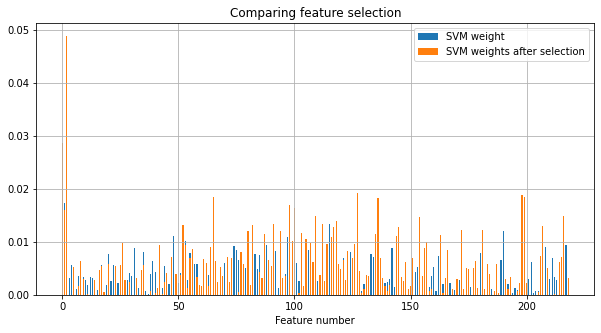

caracteristicas:  158
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.808985255031971


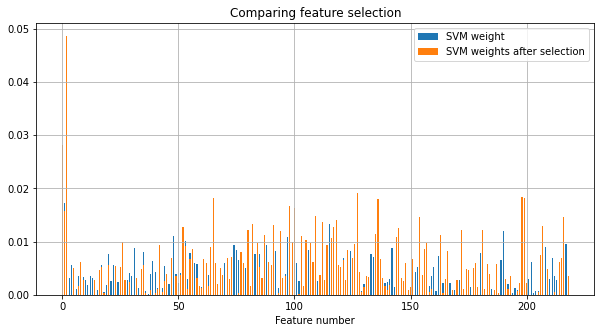

caracteristicas:  159
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.932588494505088


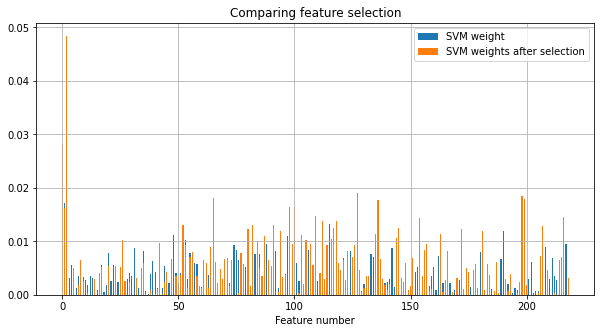

caracteristicas:  160
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.853565343741275


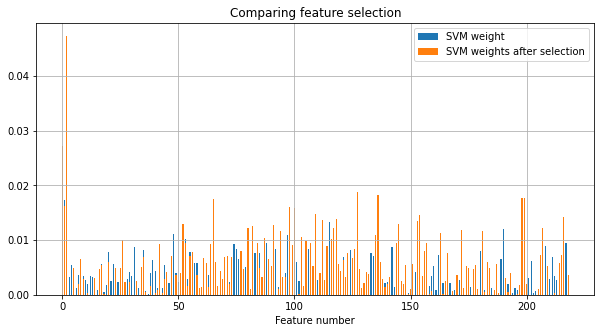

caracteristicas:  161
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.8393488807169875


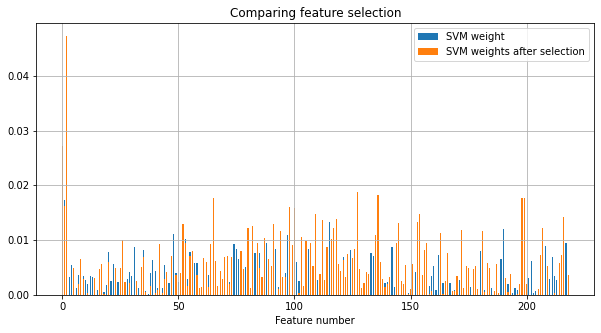

caracteristicas:  162
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.234131066917472


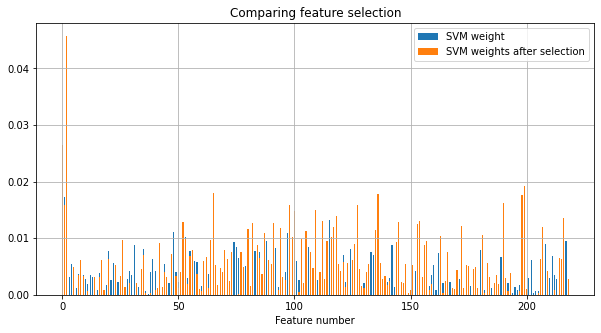

caracteristicas:  163
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.402884296780135


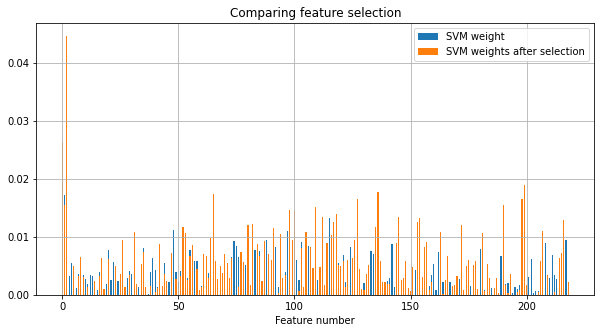

caracteristicas:  164
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.465881282329121


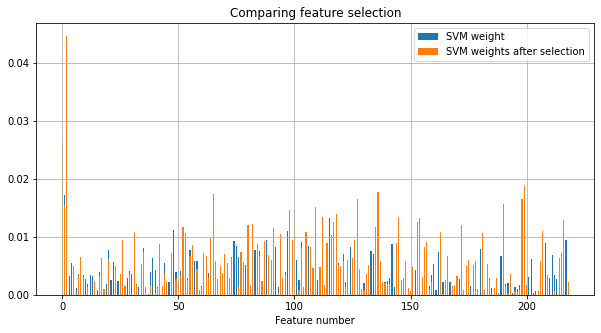

caracteristicas:  165
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.48574831816668


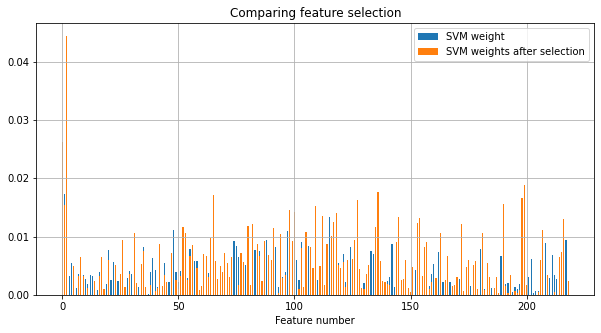

caracteristicas:  166
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.163789818598014


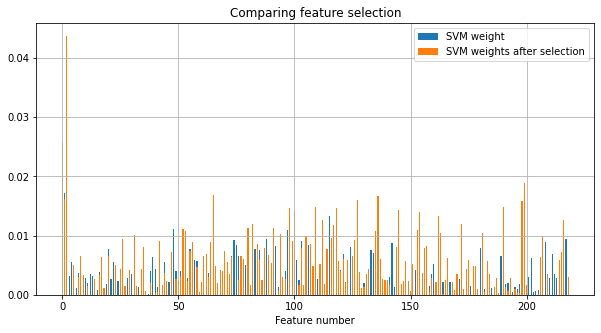

caracteristicas:  167
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -6.902448028995001


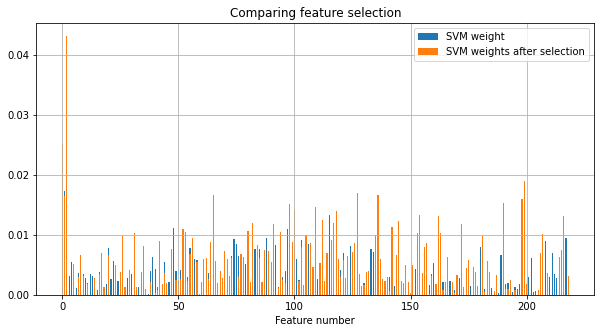

caracteristicas:  168
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.131840552748185


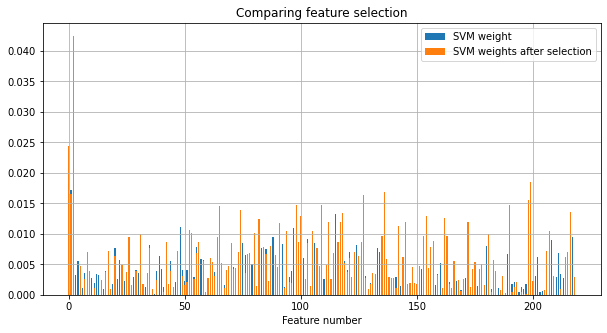

caracteristicas:  169
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.678976548461787


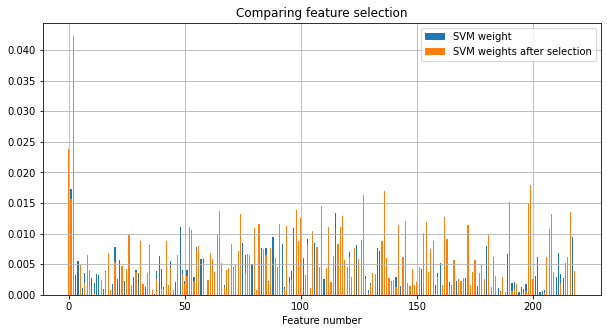

caracteristicas:  170
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.810425120093042


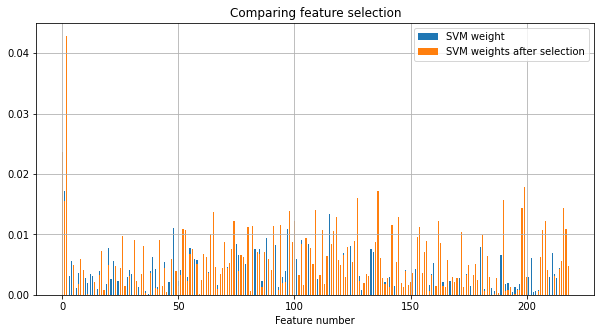

caracteristicas:  171
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.049649854770713


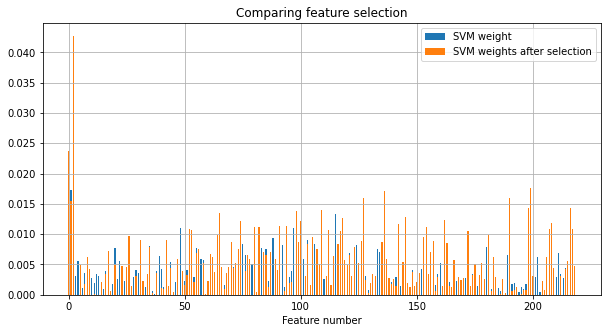

caracteristicas:  172
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.839492532278145


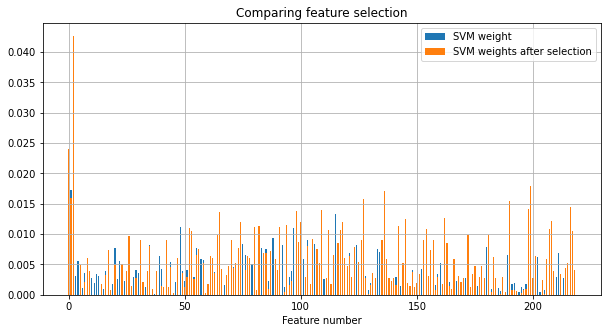

caracteristicas:  173
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.731882695219122


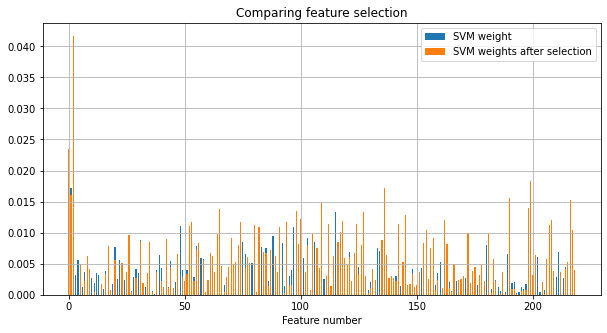

caracteristicas:  174
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.6730099011529


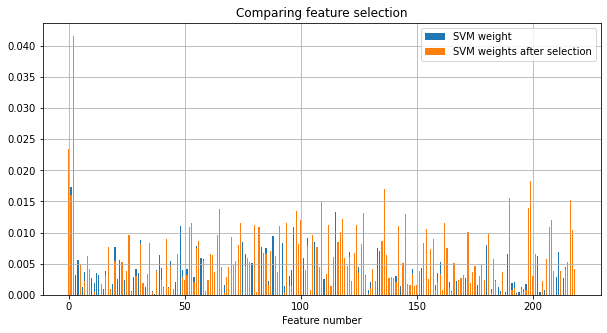

caracteristicas:  175
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.702972327443369


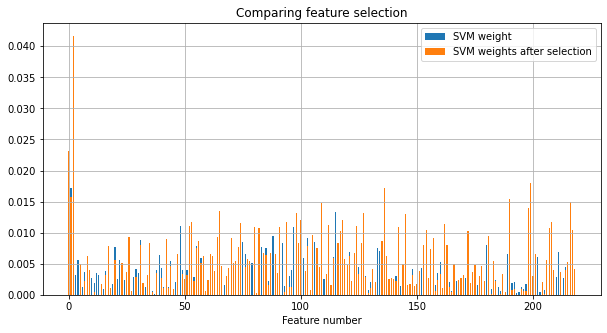

caracteristicas:  176
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.646792485091018


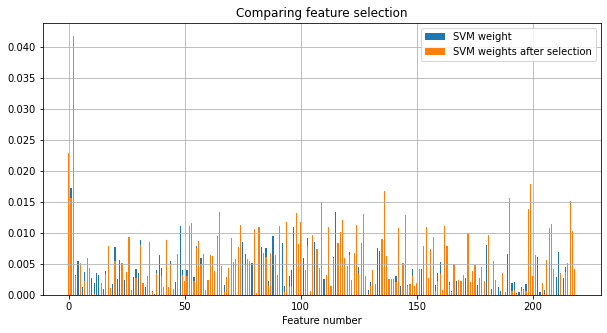

caracteristicas:  177
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.629175397432963


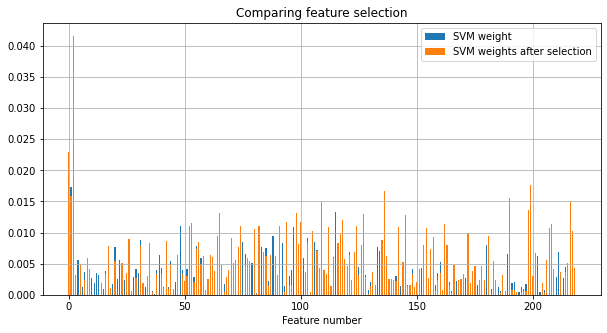

caracteristicas:  178
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.603625991428872


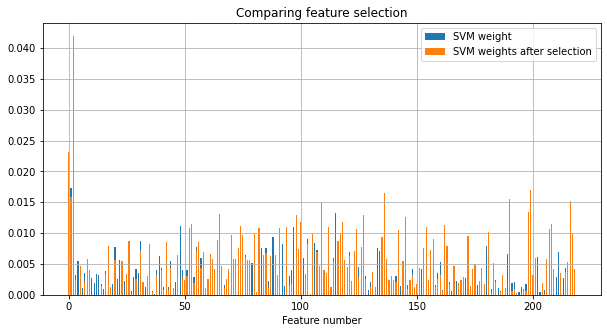

caracteristicas:  179
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.386969310833786


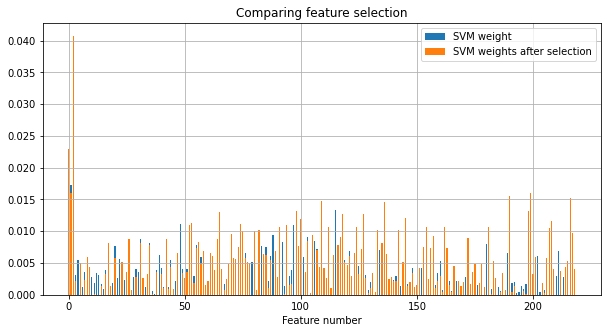

caracteristicas:  180
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.471834508289771


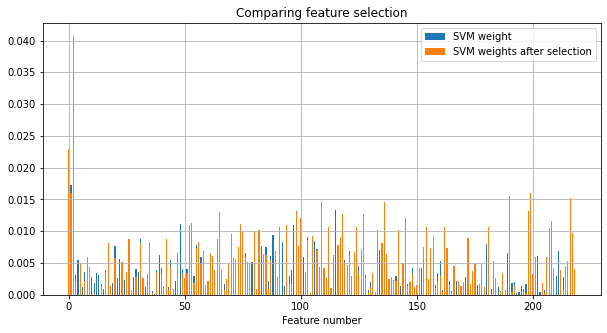

caracteristicas:  181
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.906003368754851


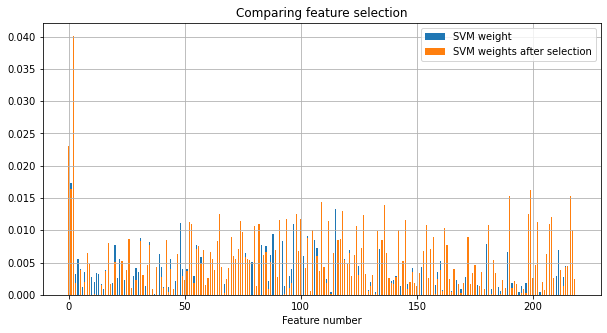

caracteristicas:  182
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -7.979528045198235


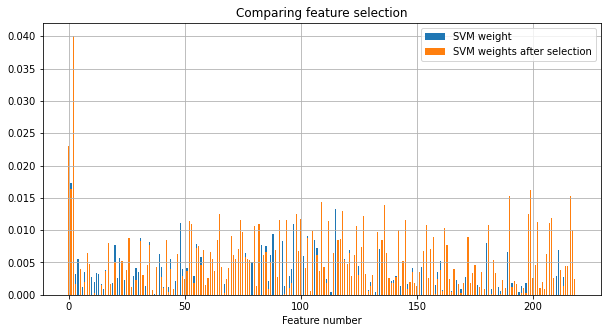

caracteristicas:  183
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.079067896191377


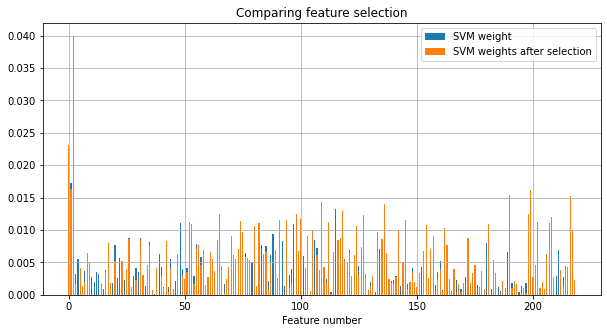

caracteristicas:  184
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.22579770402334


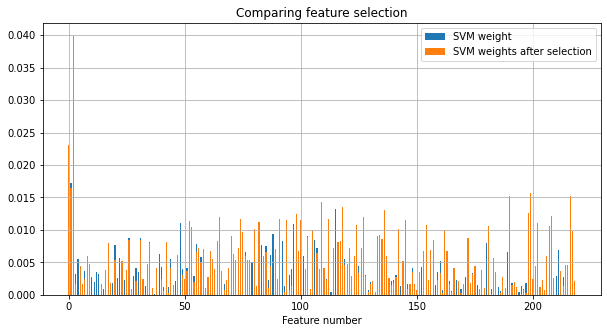

caracteristicas:  185
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.229594682490127


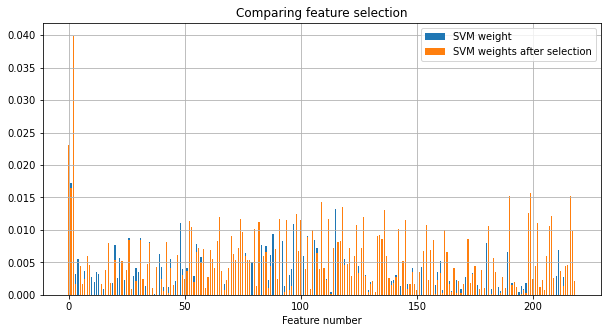

caracteristicas:  186
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.153367865244487


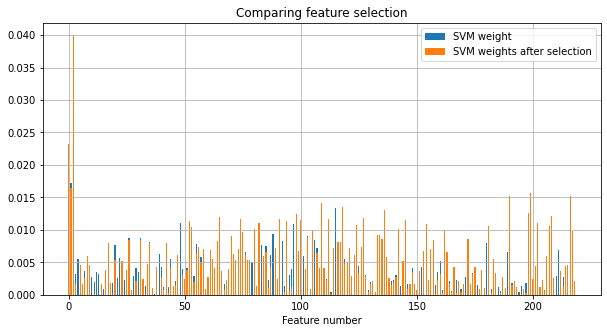

caracteristicas:  187
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.112996005683947


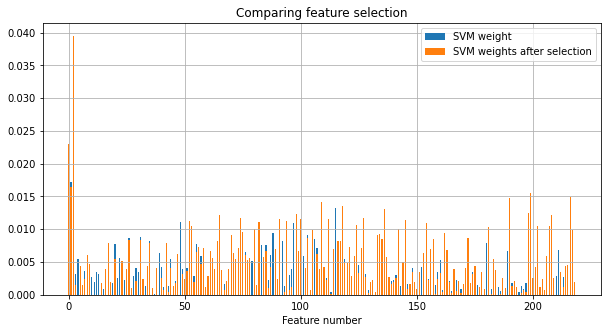

caracteristicas:  188
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.455783511511248


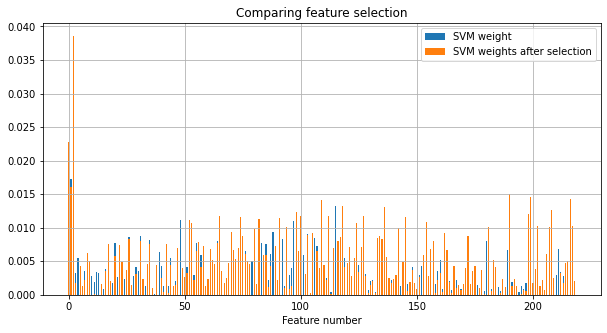

caracteristicas:  189
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.605273913043556


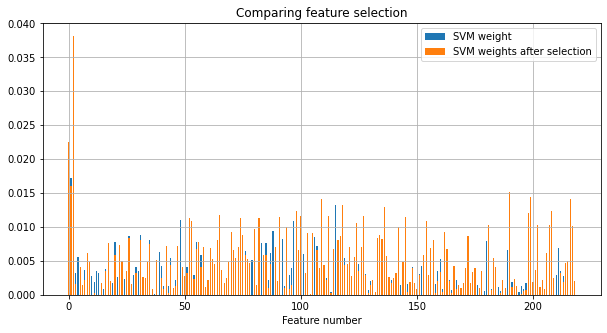

caracteristicas:  190
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.64081545649443


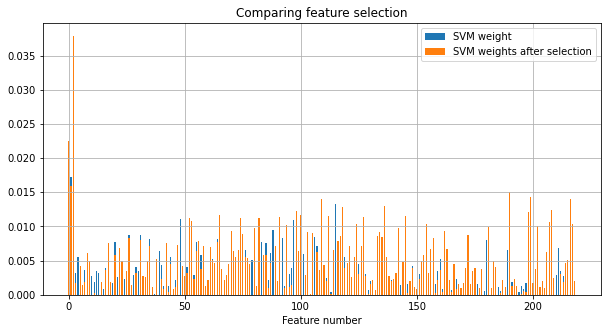

caracteristicas:  191
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.700118901958534


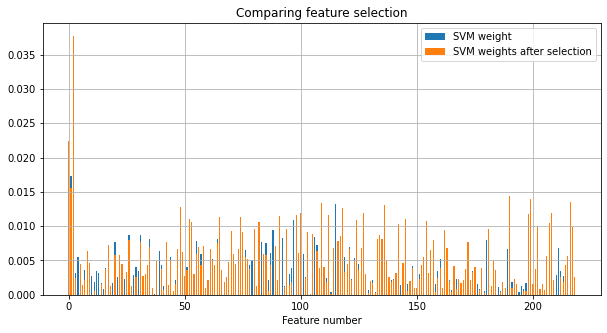

caracteristicas:  192
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.938208872271431


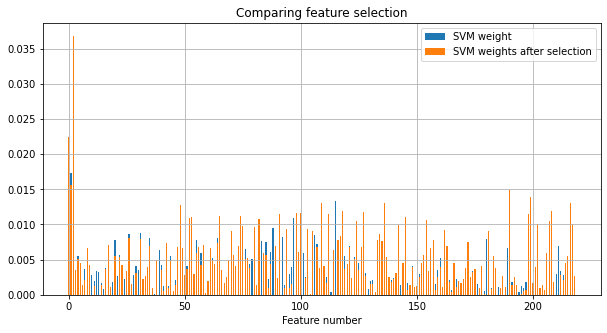

caracteristicas:  193
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.923676709677823


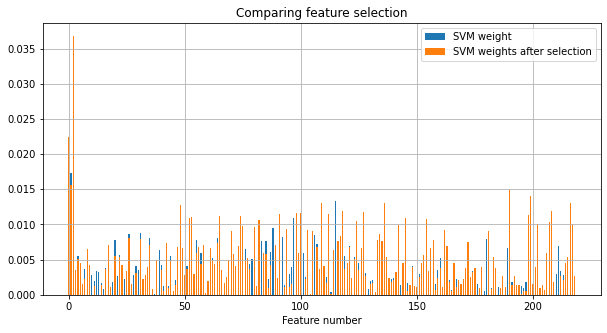

caracteristicas:  194
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.963948811622293


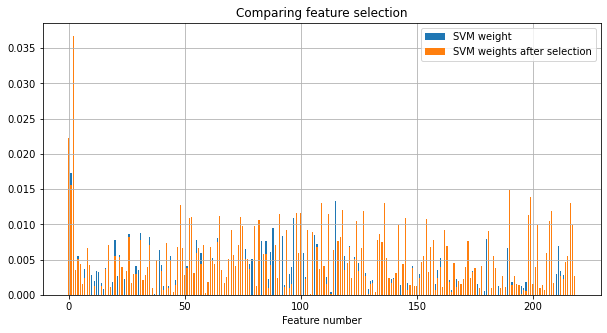

caracteristicas:  195
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.859348827036229


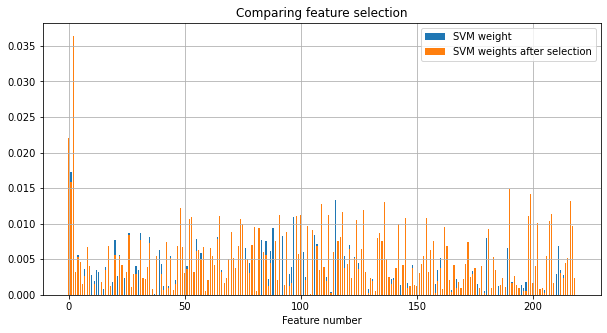

caracteristicas:  196
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.609529637330692


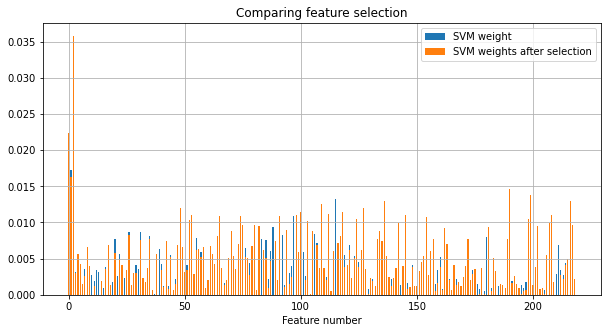

caracteristicas:  197
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.610839000425552


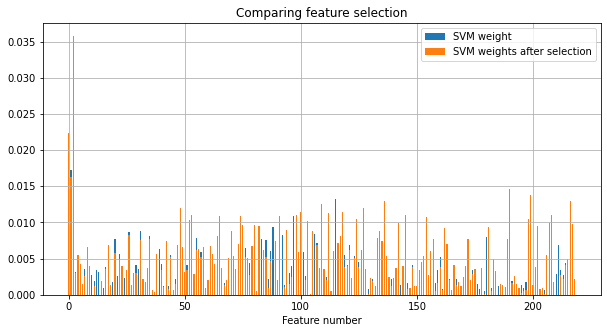

caracteristicas:  198
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.498884014003178


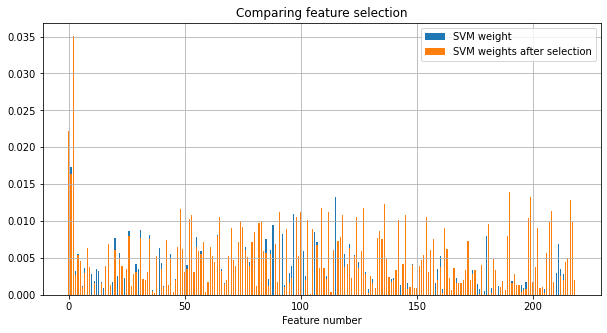

caracteristicas:  199
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.9215042741594


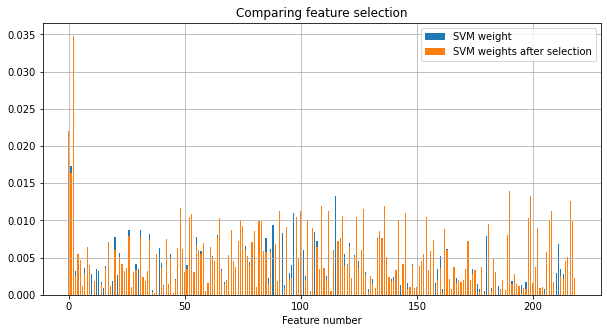

caracteristicas:  200
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.76838233728973


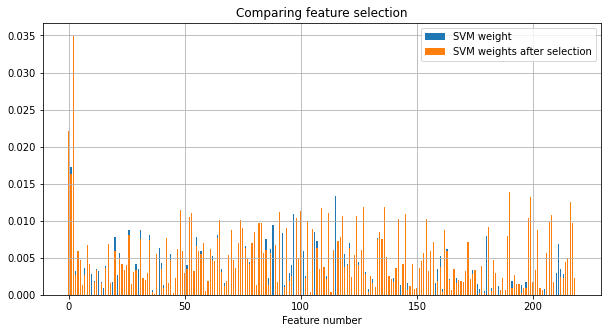

caracteristicas:  201
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.045215861461452


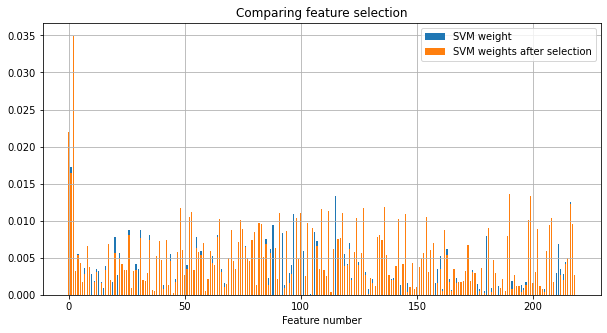

caracteristicas:  202
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.133929509778051


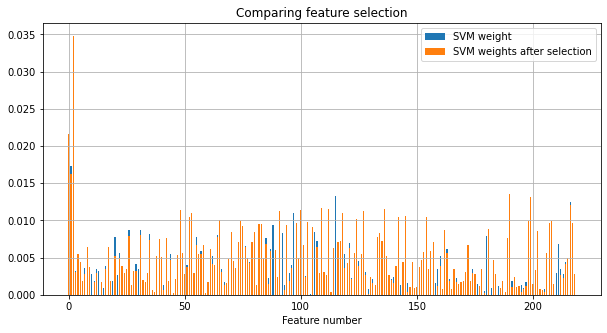

caracteristicas:  203
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.141275221800804


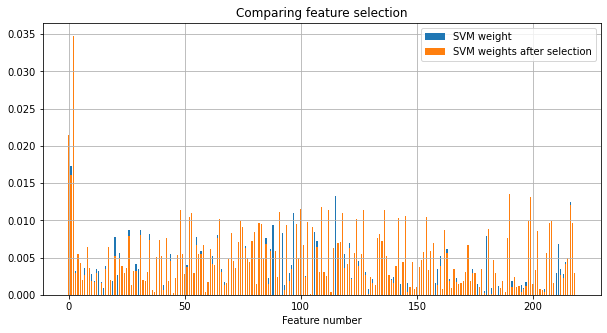

caracteristicas:  204
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.234792618878162


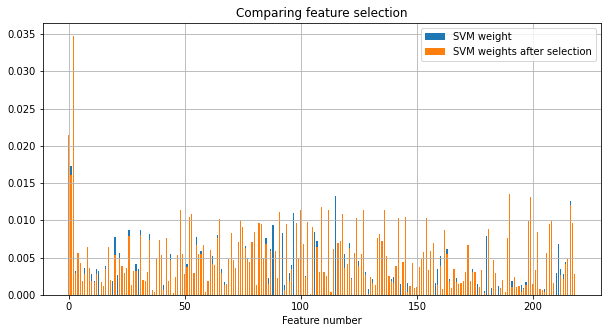

caracteristicas:  205
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.267924589659867


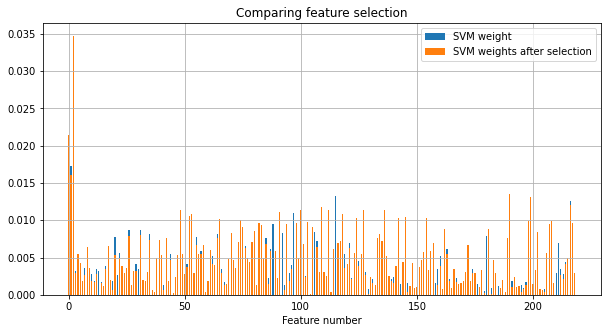

caracteristicas:  206
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.230792843309386


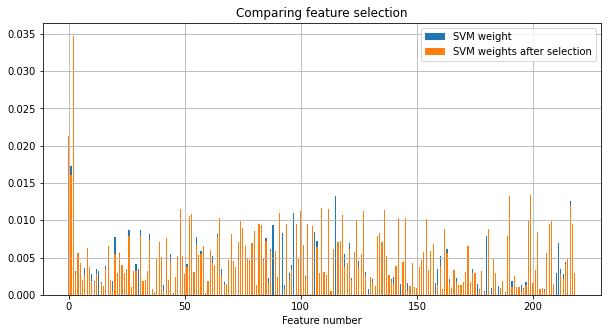

caracteristicas:  207
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.354009007007845


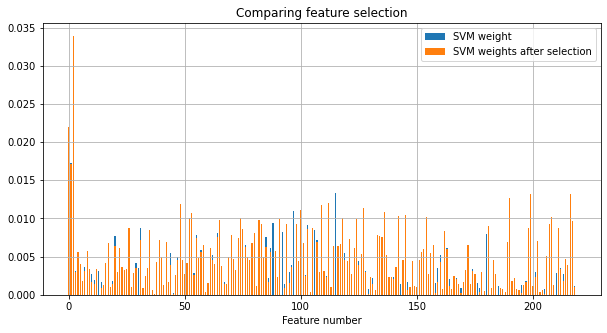

caracteristicas:  208
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.32009770367964


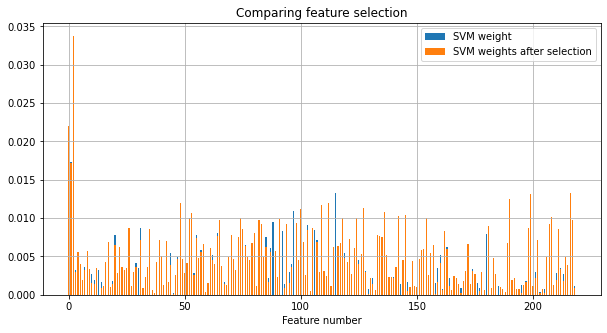

caracteristicas:  209
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.349605938847665


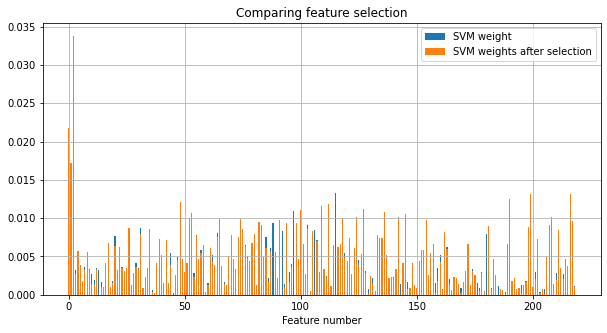

caracteristicas:  210
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.235985934024065


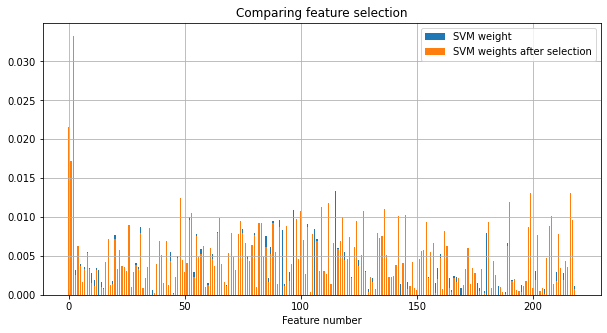

caracteristicas:  211
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.408094228589732


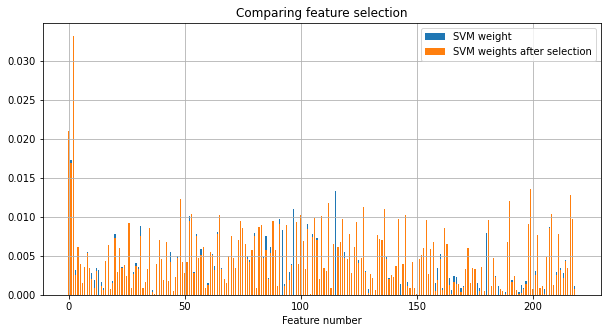

caracteristicas:  212
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.31824562418106


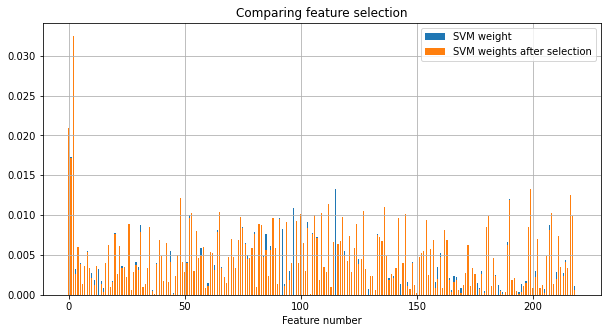

caracteristicas:  213
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.262542626583526


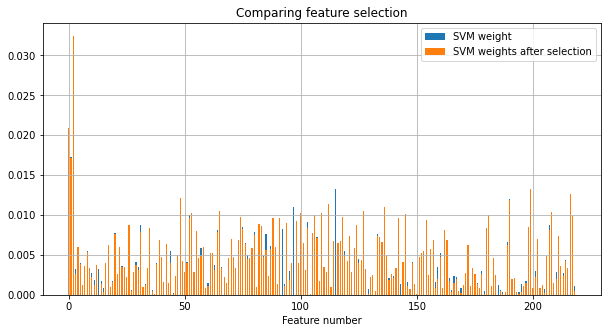

caracteristicas:  214
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.910158944540134


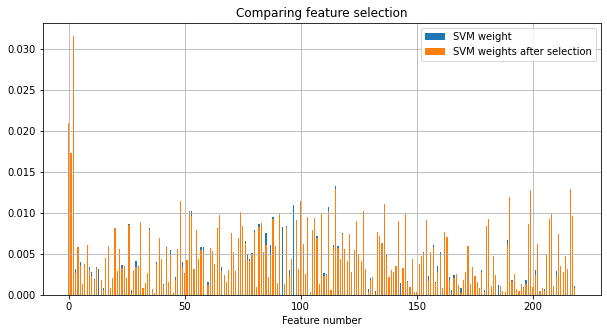

caracteristicas:  215
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -8.915734124707711


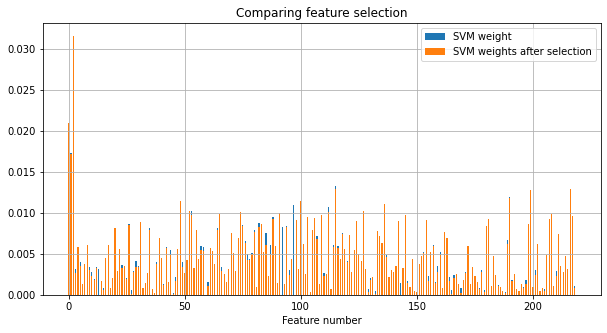

caracteristicas:  216
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.091874704516346


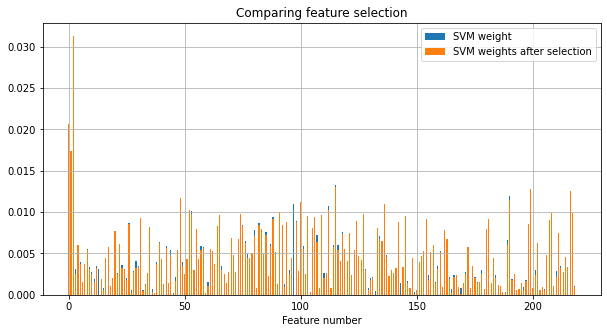

caracteristicas:  217
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.011059646623064


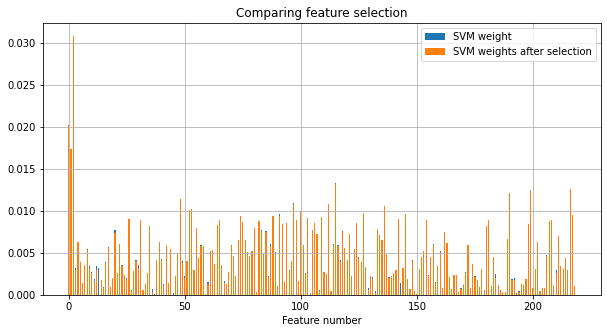

caracteristicas:  218
Classification accuracy without selecting features: -9.156655725429308
Classification accuracy after univariate feature selection: -9.059679527281673


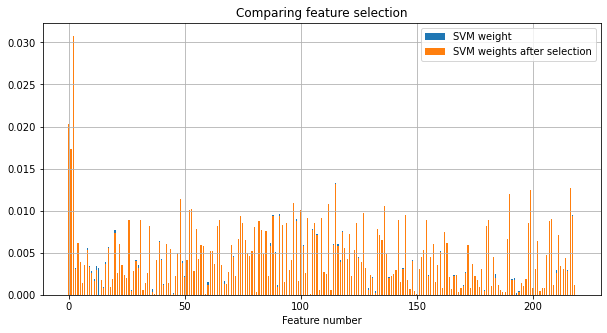

In [20]:
#Definir el numero de variables que seran usadas en la seleccion de cacteristicas
n_var = XS_REAL.shape[1]     # NUMERO DE VARIABLES
print(n_var)
score_maquinas=[]
for i in range(1,n_var-1):
    print("caracteristicas: ",i)
    val=seleccion(f_regression,i) #valor F anova
    score_maquinas.append([feature_names[i], abs(val)])

    
#     #print(len(score_maquinas))

#     plt.figure(1,figsize=(20,10))
#     plt.clf()
#     X_indices = np.arange(len(score_maquinas))
#     print(score_maquinas[i][1])
#     plt.bar(X_indices , score_maquinas[i][1], width=.5, label='score') #- .45
#     plt.title("'rendimiento maquinas'")
#     plt.xlabel('Feature number')
#     #plt.yticks(())
#     plt.grid()
#     plt.axis('tight')
#     plt.legend(loc='upper right')

#     plt.savefig(nombre_g, dpi=300)
#     plt.show()     


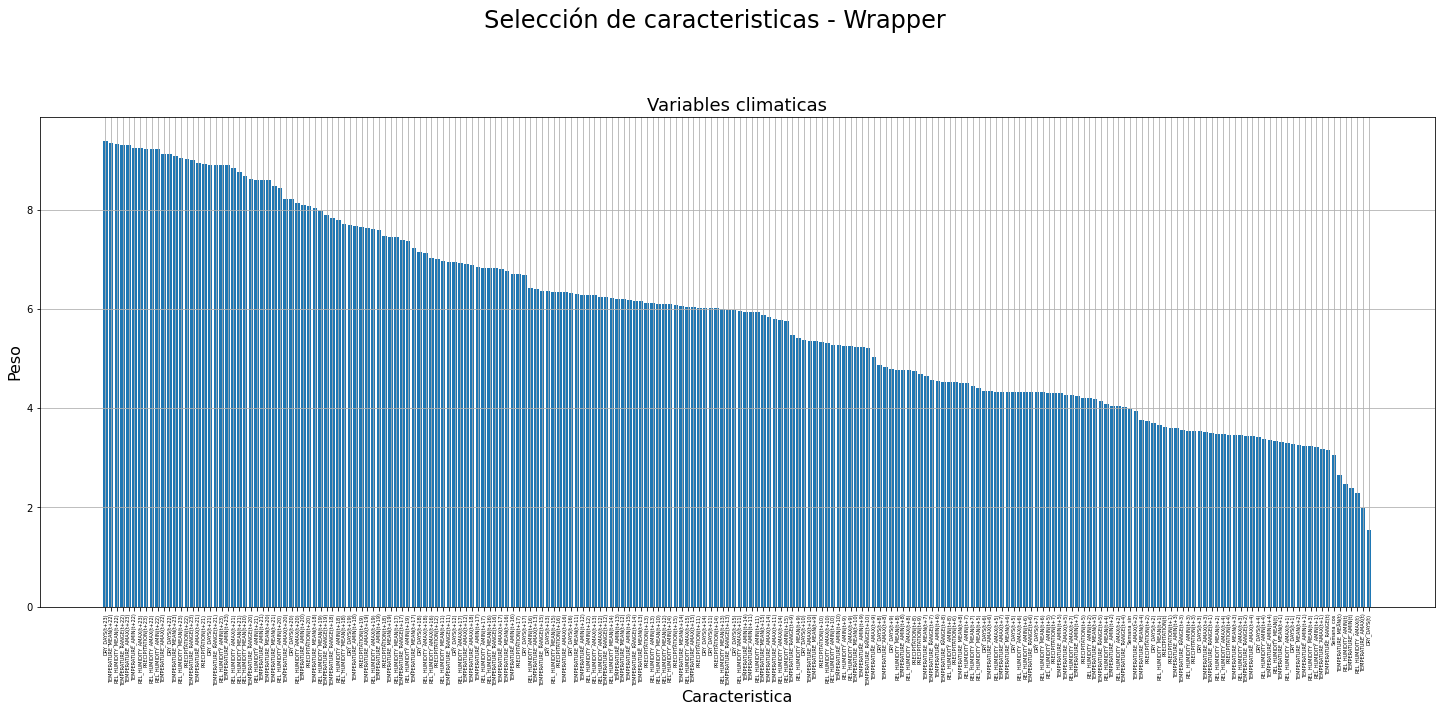

218


['DRY_DAYS(t+23)',
 'TEMPERATURE_MEAN(t+22)',
 'REL_HUMIDITY_MEAN(t+22)',
 'TEMPERATURE_RANGE(t+22)',
 'TEMPERATURE_AMAX(t+23)',
 'TEMPERATURE_AMIN(t+22)',
 'REL_HUMIDITY_AMAX(t+23)',
 'PRECIPITATION(t+23)',
 'REL_HUMIDITY_AMAX(t+22)',
 'REL_HUMIDITY_AMIN(t+22)',
 'TEMPERATURE_AMAX(t+22)',
 'DRY_DAYS(t+22)',
 'TEMPERATURE_MEAN(t+23)',
 'REL_HUMIDITY_MEAN(t+23)',
 'PRECIPITATION(t+22)',
 'TEMPERATURE_RANGE(t+23)',
 'TEMPERATURE_AMAX(t+21)',
 'PRECIPITATION(t+21)',
 'DRY_DAYS(t+21)',
 'TEMPERATURE_RANGE(t+21)',
 'REL_HUMIDITY_AMIN(t+23)',
 'TEMPERATURE_AMIN(t+23)',
 'REL_HUMIDITY_AMAX(t+21)',
 'REL_HUMIDITY_MEAN(t+21)',
 'REL_HUMIDITY_MEAN(t+20)',
 'TEMPERATURE_RANGE(t+20)',
 'REL_HUMIDITY_AMIN(t+21)',
 'TEMPERATURE_AMIN(t+21)',
 'TEMPERATURE_MEAN(t+20)',
 'TEMPERATURE_MEAN(t+21)',
 'REL_HUMIDITY_AMIN(t+20)',
 'TEMPERATURE_AMAX(t+20)',
 'DRY_DAYS(t+20)',
 'REL_HUMIDITY_AMAX(t+20)',
 'TEMPERATURE_AMIN(t+20)',
 'PRECIPITATION(t+20)',
 'TEMPERATURE_MEAN(t+18)',
 'REL_HUMIDITY_MEAN(t+19)',
 

In [21]:
score_maquinas_orden = sorted(score_maquinas, key = lambda x: x[1], reverse=True)
df_score_maquinas_orden = pd.DataFrame(score_maquinas_orden)
df_score_maquinas_orden

df_score_maquinas_orden.to_csv(PATH_O + 'caracteristicas_Wrapper_ordenado.csv', index=True)

x_g = df_score_maquinas_orden[0]
y_g = df_score_maquinas_orden[1]

plt.figure(1,figsize=(25,9))

plt.y_pos = np.arange(len(df_score_maquinas_orden))
plt.bar(x_g, y_g)
X_indices = np.arange(len(df_score_maquinas_orden))
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Wrapper', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.xticks(X_indices, x_g, rotation='vertical', fontsize = 5)
# ax.set_xscale('log')
#ax.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'Wrapper_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()

caracteristicas_select=[]
print(len(score_maquinas_orden))
for i in range(0, len(score_maquinas_orden)):
    if score_maquinas_orden[i][1]>6.5:
        caracteristicas_select.append(score_maquinas_orden[i][0])

caracteristicas_select


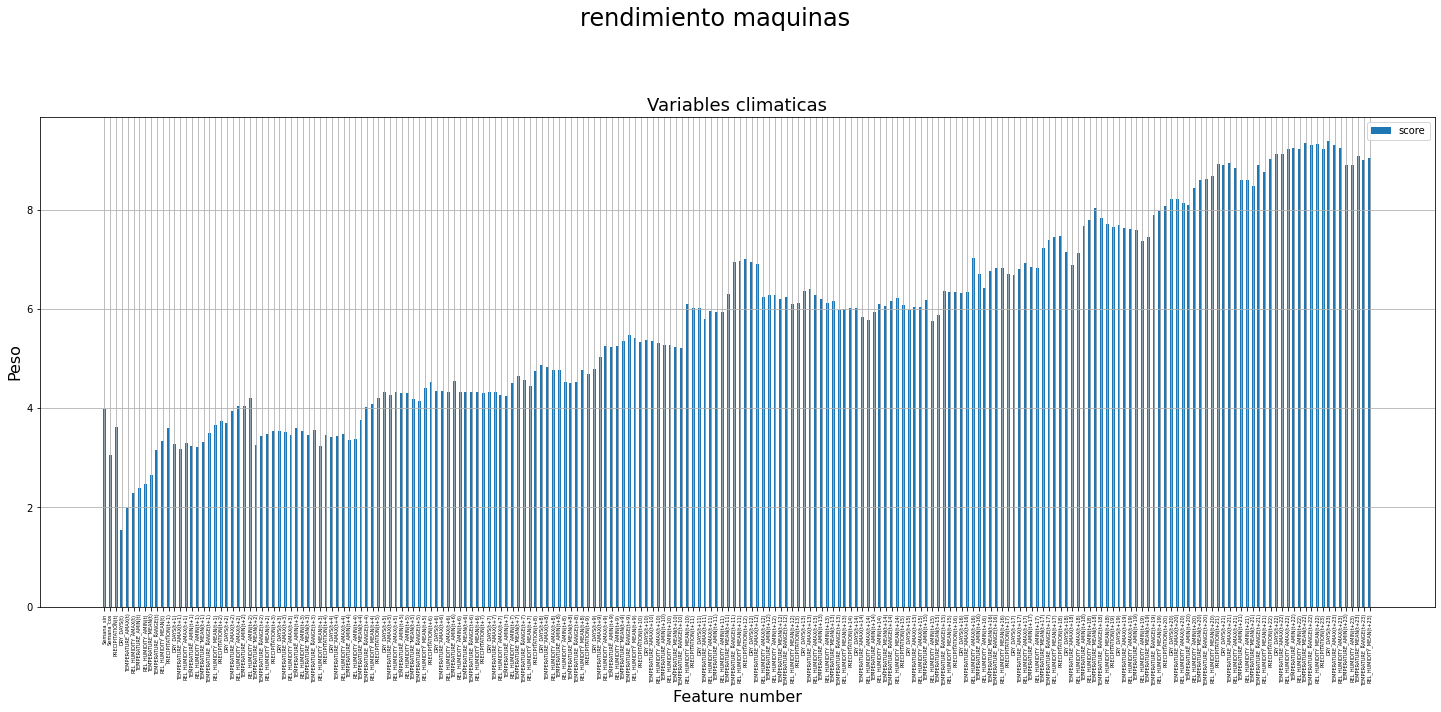

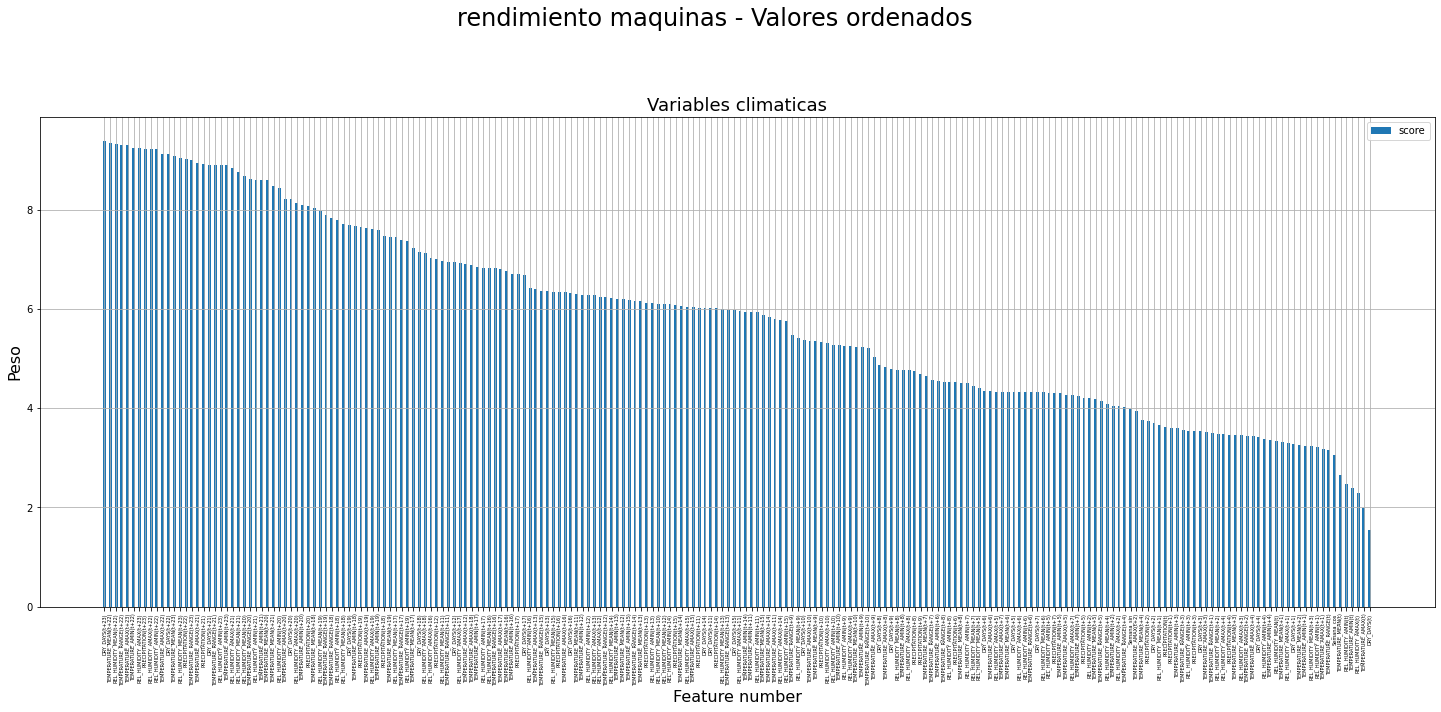

In [22]:
#print(len(score_maquinas))

df_score_maquinas = pd.DataFrame(score_maquinas)

plt.figure(1,figsize=(25,9))
plt.clf()
X_indices = np.arange(len(score_maquinas))
features = df_score_maquinas[0]
plt.bar(X_indices , df_score_maquinas[1], width=.5, label='score') #- .45
plt.xticks(X_indices, features, rotation='vertical', fontsize = 5)
plt.suptitle('rendimiento maquinas', y=1.05, fontsize = 24)
plt.title(title_string, fontsize=18)
plt.xlabel('Feature number', fontsize = 16)
plt.ylabel('Peso', fontsize = 16)
#plt.yticks(())
plt.grid()
plt.axis('tight')
plt.legend(loc='upper right')

plt.savefig(PATH_O + 'Wrapper_No_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show() 

# GRAFICAR LOS DATOS OBTENIDOS EN FORMA ORDENADA


plt.figure(1,figsize=(25,9))
plt.clf()
X_indices = np.arange(len(df_score_maquinas_orden[0]))
features = df_score_maquinas_orden[0]
plt.bar(X_indices , df_score_maquinas_orden[1], width=.5, label='score') #- .45
plt.xticks(X_indices, features, rotation='vertical', fontsize = 5)
plt.suptitle('rendimiento maquinas - Valores ordenados', y=1.05, fontsize = 24)
plt.title(title_string, fontsize=18)
plt.xlabel('Feature number', fontsize = 16)
plt.ylabel('Peso', fontsize = 16)
#plt.yticks(())
plt.grid()
plt.axis('tight')
plt.legend(loc='upper right')

plt.savefig(PATH_O + 'Wrapper_ordenado_01.jpg', dpi=100, bbox_inches='tight')
plt.show() 

In [23]:
## mutual_info_regression

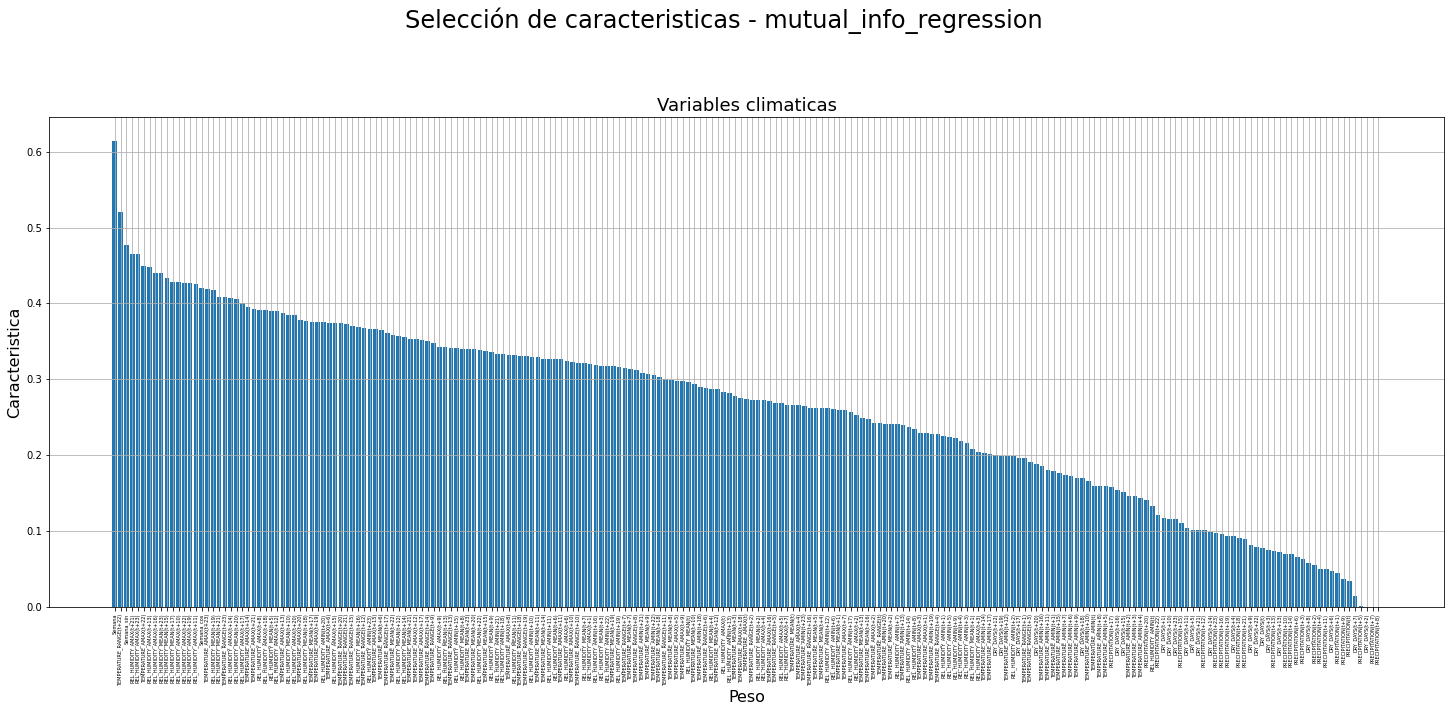

['DRY_DAYS(t+23)',
 'TEMPERATURE_MEAN(t+22)',
 'REL_HUMIDITY_MEAN(t+22)',
 'TEMPERATURE_RANGE(t+22)',
 'TEMPERATURE_AMAX(t+23)',
 'TEMPERATURE_AMIN(t+22)',
 'REL_HUMIDITY_AMAX(t+23)',
 'PRECIPITATION(t+23)',
 'REL_HUMIDITY_AMAX(t+22)',
 'REL_HUMIDITY_AMIN(t+22)',
 'TEMPERATURE_AMAX(t+22)',
 'DRY_DAYS(t+22)',
 'TEMPERATURE_MEAN(t+23)',
 'REL_HUMIDITY_MEAN(t+23)',
 'PRECIPITATION(t+22)',
 'TEMPERATURE_RANGE(t+23)',
 'TEMPERATURE_AMAX(t+21)',
 'PRECIPITATION(t+21)',
 'DRY_DAYS(t+21)',
 'TEMPERATURE_RANGE(t+21)',
 'REL_HUMIDITY_AMIN(t+23)',
 'TEMPERATURE_AMIN(t+23)',
 'REL_HUMIDITY_AMAX(t+21)',
 'REL_HUMIDITY_MEAN(t+21)',
 'REL_HUMIDITY_MEAN(t+20)',
 'TEMPERATURE_RANGE(t+20)',
 'REL_HUMIDITY_AMIN(t+21)',
 'TEMPERATURE_AMIN(t+21)',
 'TEMPERATURE_MEAN(t+20)',
 'TEMPERATURE_MEAN(t+21)',
 'REL_HUMIDITY_AMIN(t+20)',
 'TEMPERATURE_AMAX(t+20)',
 'DRY_DAYS(t+20)',
 'REL_HUMIDITY_AMAX(t+20)',
 'TEMPERATURE_AMIN(t+20)',
 'PRECIPITATION(t+20)',
 'TEMPERATURE_MEAN(t+18)',
 'REL_HUMIDITY_MEAN(t+19)',
 

In [24]:
n=n_var-1 #numero caracteristicas
# Feature extraction
test = SelectKBest(score_func = mutual_info_regression, k=n) #cambiar score_func y k <- mejor segun grafica arriba
fit = test.fit(x, y)

# Summarize scores
np.set_printoptions(precision=3)
scores = test.scores_
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature,score in zip(mask, feature_names,scores):
    if bool:
        new_features.append([feature,score])

CR1 = sorted(new_features, key = lambda x: x[1], reverse=True)
df_CR1 = pd.DataFrame(CR1)        
#print(f'{n} caracteristicas: ',CR)

df_CR1

#features = fit.transform(x)
# Summarize selected features
#print(features[0:5,:])





plt.figure(1,figsize=(25,9))
#ax = plt.gca()
plt.y_pos = np.arange(len(df_CR1))
X_indices = np.arange(len(df_CR1[0]))
features = df_CR1[0]
score_feature = df_CR1[1]
plt.bar(features, score_feature)
plt.xticks(X_indices, features, rotation='vertical', fontsize = 5)
plt.xlabel('Peso', fontsize = 16)
plt.ylabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - mutual_info_regression', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
# plt.xscale('log')
# plt.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'Mutual_info_regression_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()
df_CR1 
AAA = df_CR1

for i in range (0, len(CR1)):
    if CR1[i][1]>0.35:
        caracteristicas_select.append(CR1[i][0])
caracteristicas_select

In [25]:
df_CR1.to_csv(PATH_O + 'caracteristicas_mutual_regresion.csv', index=True)

In [26]:
## f_classif

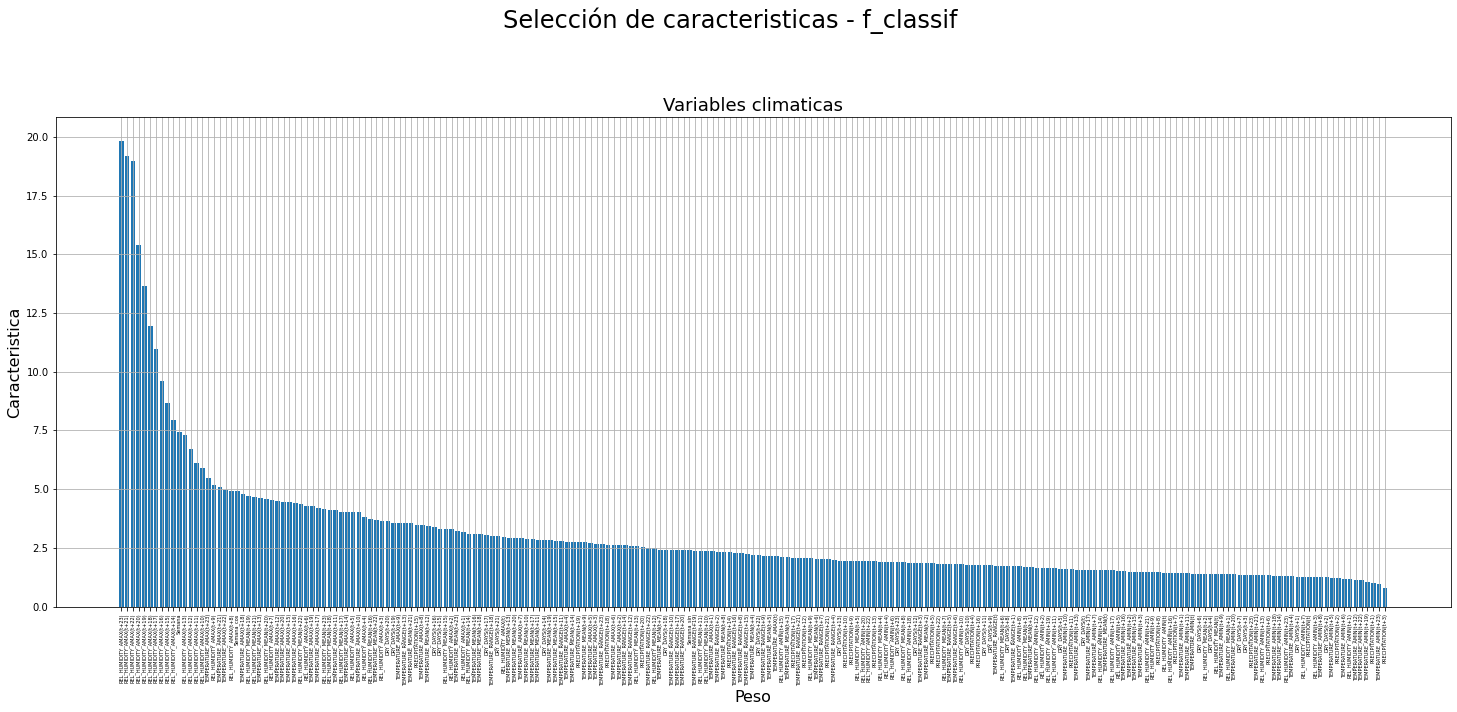

['DRY_DAYS(t+23)',
 'TEMPERATURE_MEAN(t+22)',
 'REL_HUMIDITY_MEAN(t+22)',
 'TEMPERATURE_RANGE(t+22)',
 'TEMPERATURE_AMAX(t+23)',
 'TEMPERATURE_AMIN(t+22)',
 'REL_HUMIDITY_AMAX(t+23)',
 'PRECIPITATION(t+23)',
 'REL_HUMIDITY_AMAX(t+22)',
 'REL_HUMIDITY_AMIN(t+22)',
 'TEMPERATURE_AMAX(t+22)',
 'DRY_DAYS(t+22)',
 'TEMPERATURE_MEAN(t+23)',
 'REL_HUMIDITY_MEAN(t+23)',
 'PRECIPITATION(t+22)',
 'TEMPERATURE_RANGE(t+23)',
 'TEMPERATURE_AMAX(t+21)',
 'PRECIPITATION(t+21)',
 'DRY_DAYS(t+21)',
 'TEMPERATURE_RANGE(t+21)',
 'REL_HUMIDITY_AMIN(t+23)',
 'TEMPERATURE_AMIN(t+23)',
 'REL_HUMIDITY_AMAX(t+21)',
 'REL_HUMIDITY_MEAN(t+21)',
 'REL_HUMIDITY_MEAN(t+20)',
 'TEMPERATURE_RANGE(t+20)',
 'REL_HUMIDITY_AMIN(t+21)',
 'TEMPERATURE_AMIN(t+21)',
 'TEMPERATURE_MEAN(t+20)',
 'TEMPERATURE_MEAN(t+21)',
 'REL_HUMIDITY_AMIN(t+20)',
 'TEMPERATURE_AMAX(t+20)',
 'DRY_DAYS(t+20)',
 'REL_HUMIDITY_AMAX(t+20)',
 'TEMPERATURE_AMIN(t+20)',
 'PRECIPITATION(t+20)',
 'TEMPERATURE_MEAN(t+18)',
 'REL_HUMIDITY_MEAN(t+19)',
 

In [27]:
n=n_var-1 #numero caracteristicas
# Feature extraction
test = SelectKBest(score_func = f_classif, k=n) #cambiar score_func y k <- mejor segun grafica arriba
fit = test.fit(x, y)

# Summarize scores
np.set_printoptions(precision=3)
scores = test.scores_
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature,score in zip(mask, feature_names,scores):
    if bool:
        new_features.append([feature,score])

        
CR2 = sorted(new_features, key = lambda x: x[1], reverse=True)
df_CR2 = pd.DataFrame(CR2)        
#print(f'{n} caracteristicas: ',CR)
df_CR2

#print(f'{n} caracteristicas: ',sorted(new_features, key = lambda x: x[1], reverse=True))




plt.figure(1,figsize=(25,9))
#ax = plt.gca()
plt.y_pos = np.arange(len(df_CR2))
X_indices = np.arange(len(df_CR2[0]))
features = df_CR2[0]
score_feature = df_CR2[1]
plt.bar(features, score_feature)
plt.xticks(X_indices, features, rotation='vertical', fontsize = 5)
plt.xlabel('Peso', fontsize = 16)
plt.ylabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - f_classif', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
#plt.xscale('log')
#plt.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'f_classif_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()
df_CR2 
BBB = df_CR2 

for i in range (0, len(CR2)):
    if CR2[i][1]>5.0:
        caracteristicas_select.append(CR2[i][0])
caracteristicas_select

In [28]:
df_CR2.to_csv(PATH_O + 'caracteristicas_peso_f_clasif.csv', index=True)

In [29]:
## f_regression

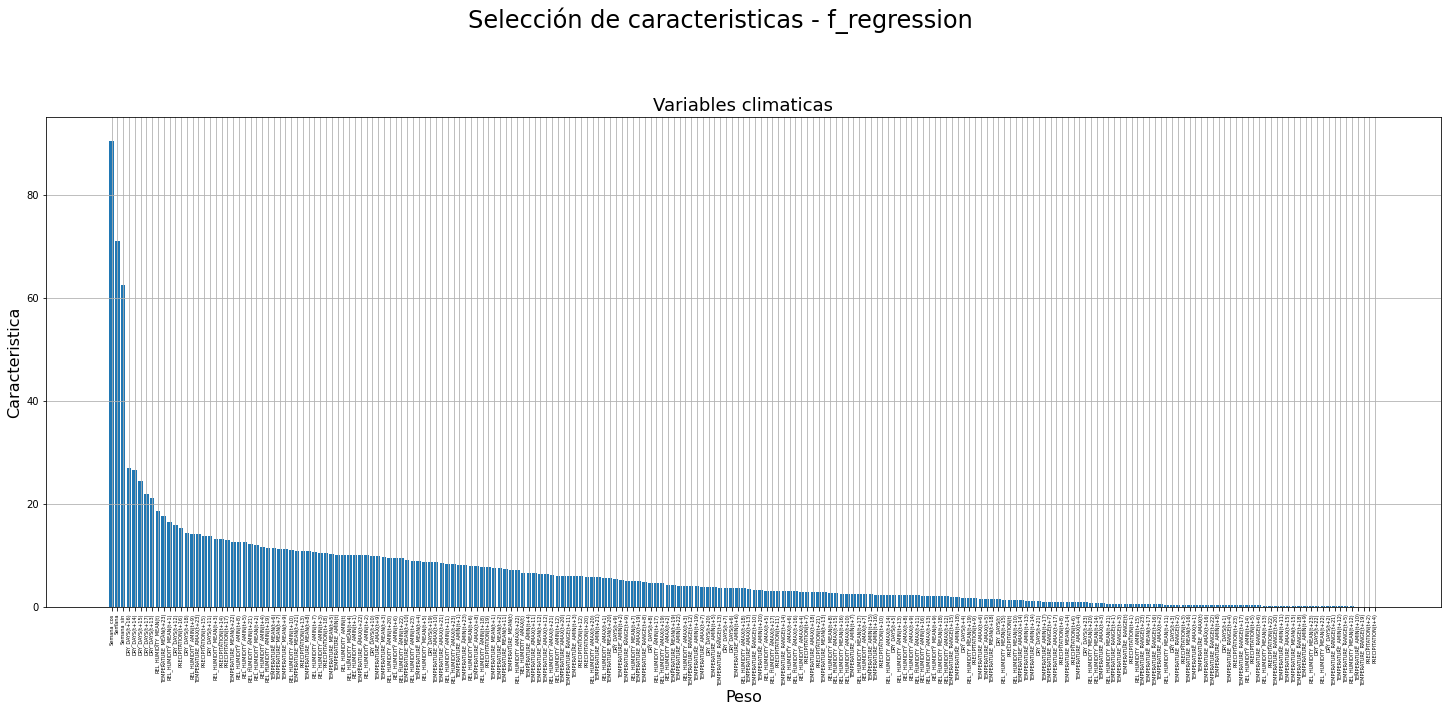

159
104


['DRY_DAYS(t+12)',
 'DRY_DAYS(t+13)',
 'DRY_DAYS(t+14)',
 'DRY_DAYS(t+15)',
 'DRY_DAYS(t+16)',
 'DRY_DAYS(t+17)',
 'DRY_DAYS(t+18)',
 'DRY_DAYS(t+19)',
 'DRY_DAYS(t+20)',
 'DRY_DAYS(t+21)',
 'DRY_DAYS(t+22)',
 'DRY_DAYS(t+23)',
 'PRECIPITATION(t+12)',
 'PRECIPITATION(t+16)',
 'PRECIPITATION(t+17)',
 'PRECIPITATION(t+18)',
 'PRECIPITATION(t+19)',
 'PRECIPITATION(t+20)',
 'PRECIPITATION(t+21)',
 'PRECIPITATION(t+22)',
 'PRECIPITATION(t+23)',
 'REL_HUMIDITY_AMAX(t+10)',
 'REL_HUMIDITY_AMAX(t+11)',
 'REL_HUMIDITY_AMAX(t+12)',
 'REL_HUMIDITY_AMAX(t+13)',
 'REL_HUMIDITY_AMAX(t+14)',
 'REL_HUMIDITY_AMAX(t+15)',
 'REL_HUMIDITY_AMAX(t+16)',
 'REL_HUMIDITY_AMAX(t+17)',
 'REL_HUMIDITY_AMAX(t+18)',
 'REL_HUMIDITY_AMAX(t+19)',
 'REL_HUMIDITY_AMAX(t+20)',
 'REL_HUMIDITY_AMAX(t+21)',
 'REL_HUMIDITY_AMAX(t+22)',
 'REL_HUMIDITY_AMAX(t+23)',
 'REL_HUMIDITY_AMAX(t+8)',
 'REL_HUMIDITY_AMAX(t+9)',
 'REL_HUMIDITY_AMIN(t+17)',
 'REL_HUMIDITY_AMIN(t+18)',
 'REL_HUMIDITY_AMIN(t+19)',
 'REL_HUMIDITY_AMIN(t+20)'

In [30]:
n=n_var-1 #numero caracteristicas
# Feature extraction
test = SelectKBest(score_func = f_regression, k=n) #cambiar score_func y k <- mejor segun grafica arriba
fit = test.fit(x, y)

# Summarize scores
np.set_printoptions(precision=3)
scores = test.scores_
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature,score in zip(mask, feature_names,scores):
    if bool:
        new_features.append([feature,score])

CR3 = sorted(new_features, key = lambda x: x[1], reverse=True)
df_CR3 = pd.DataFrame(CR3)        
#print(f'{n} caracteristicas: ',CR)
        
#print(f'{n} caracteristicas: ',sorted(new_features, key = lambda x: x[1], reverse=True))




plt.figure(1,figsize=(25,9))
X_indices = np.arange(len(df_CR3[0]))
#ax = plt.gca()
plt.y_pos = np.arange(len(df_CR3))
features = df_CR3[0]
score_feature = df_CR3[1]
plt.bar(features, score_feature)
plt.xlabel('Peso', fontsize = 16)
plt.ylabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - f_regression', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.xticks(X_indices, features, rotation='vertical', fontsize = 5)
plt.grid()
#ax.set_xscale('log')
#ax.invert_yaxis()
plt.savefig(PATH_O + 'f_regression_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()
df_CR3 
CCC = df_CR3

for i in range (0, len(CR3)):
    if CR3[i][1]>15.0:
        caracteristicas_select.append(CR3[i][0])

print(len(caracteristicas_select))
caracteristicas_select1 = set(caracteristicas_select)
print(len(caracteristicas_select1))


caracteristicas_select2 = sorted(list(caracteristicas_select1))

caracteristicas_select2

In [31]:
df_CR2.to_csv(PATH_O + 'caracteristicas_f_regression_ordenado.csv', index=True)

In [32]:
df_CR1.sort_values(0, inplace=True)
AAA1 = df_CR1

df_CR2.sort_values(0, inplace=True)
BBB1 = df_CR2

df_CR3.sort_values(0, inplace=True)
CCC1 = df_CR3

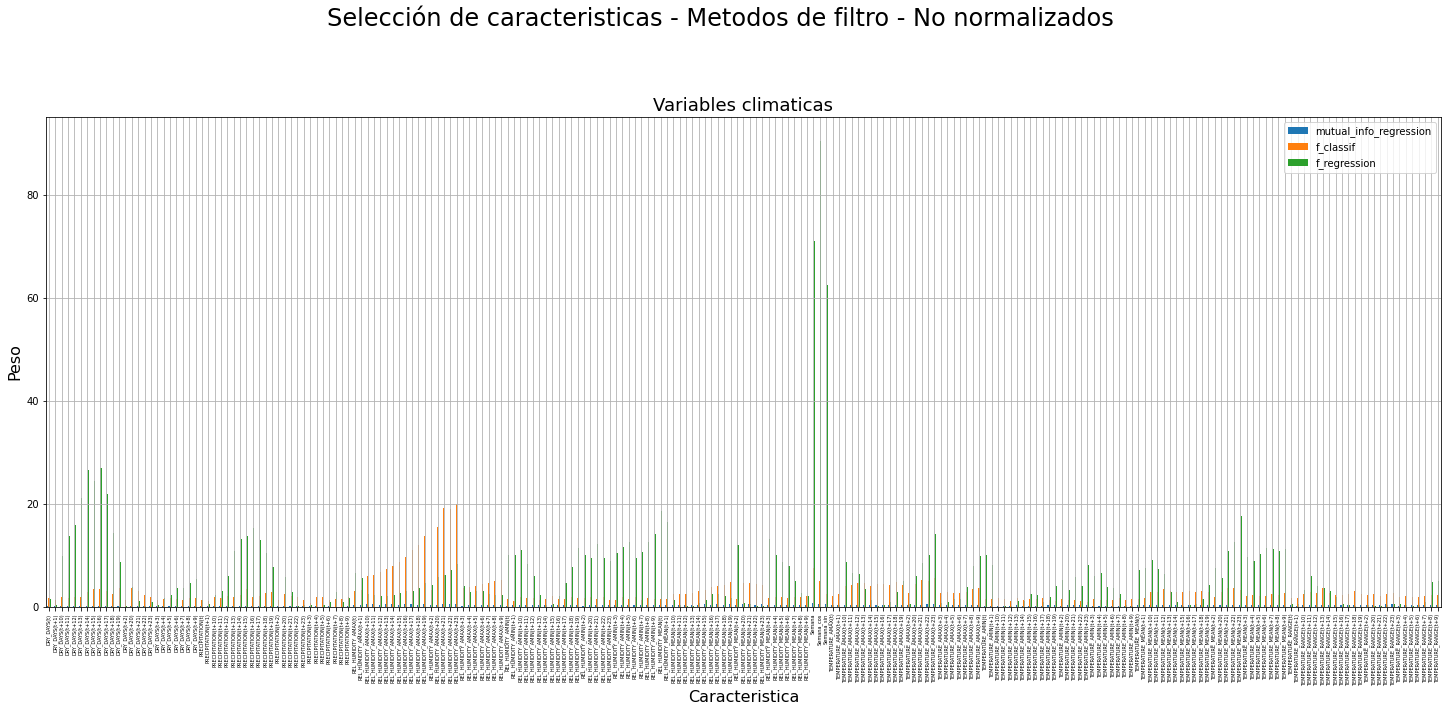

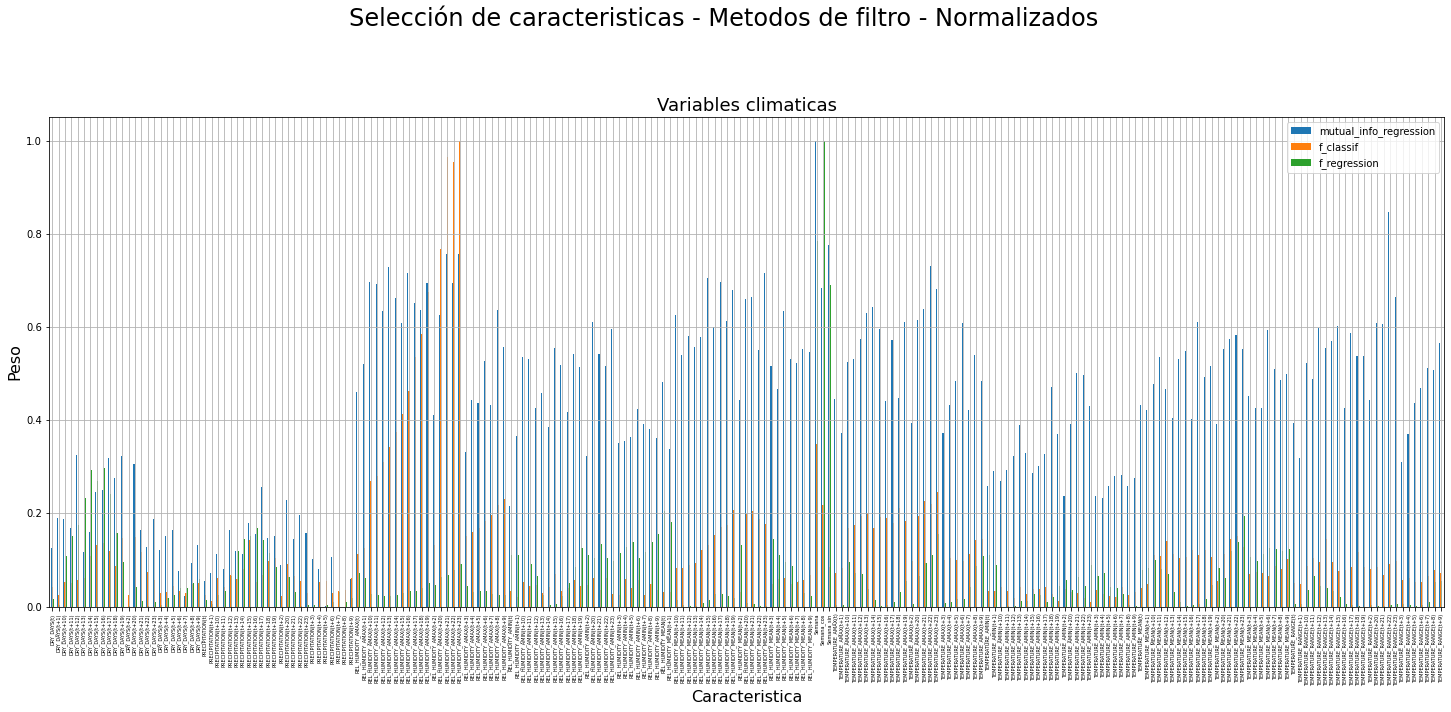

In [33]:
LLL1 = np.reshape(AAA1.values[:,0],(len(AAA1),1))
AAA1_V = np.reshape(AAA1.values[:,1],(len(AAA1),1))
AAA1_S = escalador(AAA1_V, np.amin(AAA1_V), np.amax(AAA1_V))
BBB1_V = np.reshape(BBB1.values[:,1],(len(AAA1),1))
BBB1_S = escalador(BBB1_V, np.amin(BBB1_V), np.amax(BBB1_V))
CCC1_V = np.reshape(CCC1.values[:,1],(len(AAA1),1))
CCC1_S = escalador(CCC1_V, np.amin(CCC1_V), np.amax(CCC1_V))
carac = np.append(LLL1,AAA1_V,axis=1)
carac = np.append(carac,BBB1_V,axis=1)
carac = np.append(carac,CCC1_V,axis=1)
Escal = AAA1_S + BBB1_S + CCC1_S

carac

Escalados = np.append(LLL1,Escal,axis=1)
Escalados

C0 = list(carac[:,0])
C1 = list(carac[:,1])
C2 = list(carac[:,2])
C3 = list(carac[:,3])



Caracteristicas_sin_escala = pd.DataFrame({'Caracteristica': C0, 'mutual_info_regression' : C1, 'f_classif' : C2, 'f_regression': C3})
Caracteristicas_sin_escala.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caracteristicas_sin_escala))
plt.xticks(X_indices, Caracteristicas_sin_escala['Caracteristica'], rotation='vertical', fontsize = 5)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Metodos de filtro - No normalizados', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-NO-Normalizados.jpg', dpi=100, bbox_inches='tight')
plt.show()

carac_s = np.append(LLL1,AAA1_S,axis=1)
carac_s = np.append(carac_s,BBB1_S,axis=1)
carac_s = np.append(carac_s,CCC1_S,axis=1)
C0_S = list(carac_s[:,0])
C1_S = list(carac_s[:,1])
C2_S = list(carac_s[:,2])
C3_S = list(carac_s[:,3])

Caracteristicas_escalado = pd.DataFrame({'Caracteristica': C0_S, 'mutual_info_regression' : C1_S, 'f_classif' : C2_S, 'f_regression': C3_S})
Caracteristicas_escalado.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caracteristicas_escalado))
plt.xticks(X_indices, Caracteristicas_escalado['Caracteristica'], rotation='vertical', fontsize = 5)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Metodos de filtro - Normalizados', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Normalizados.jpg', dpi=100, bbox_inches='tight')
plt.show()
#pd.concat([df_CR1,df_CR2,df_CR3], ignore_index=True, axis=1)

# limite_caracteristica = np.array(([np.amin(caracteristicas_v[:,0])],[np.amax(caracteristicas_v[:,0])]))
# scaled_feature[:,i]=escalador(caracteristicas_v[:,i],limite_caracteristica[0][i],limite_caracteristica[1][i])

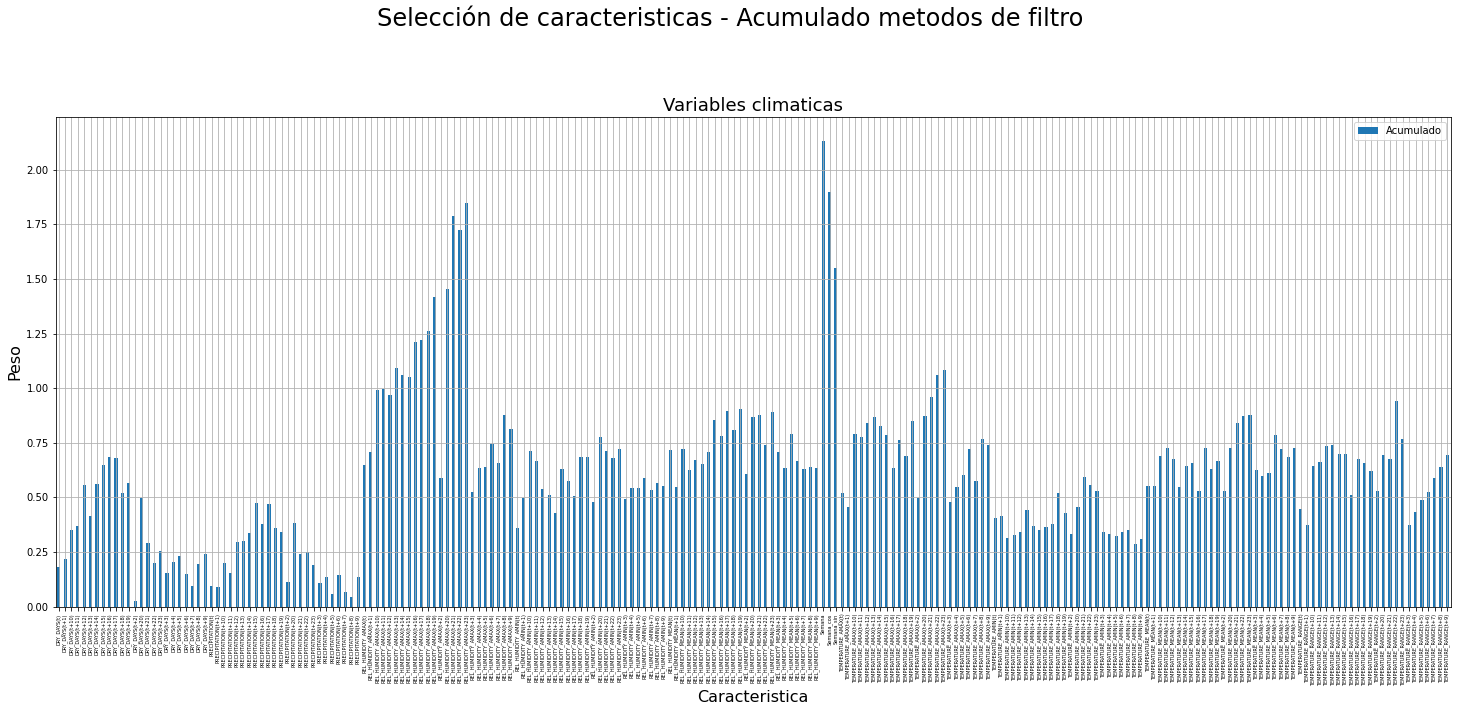

(145, 2)


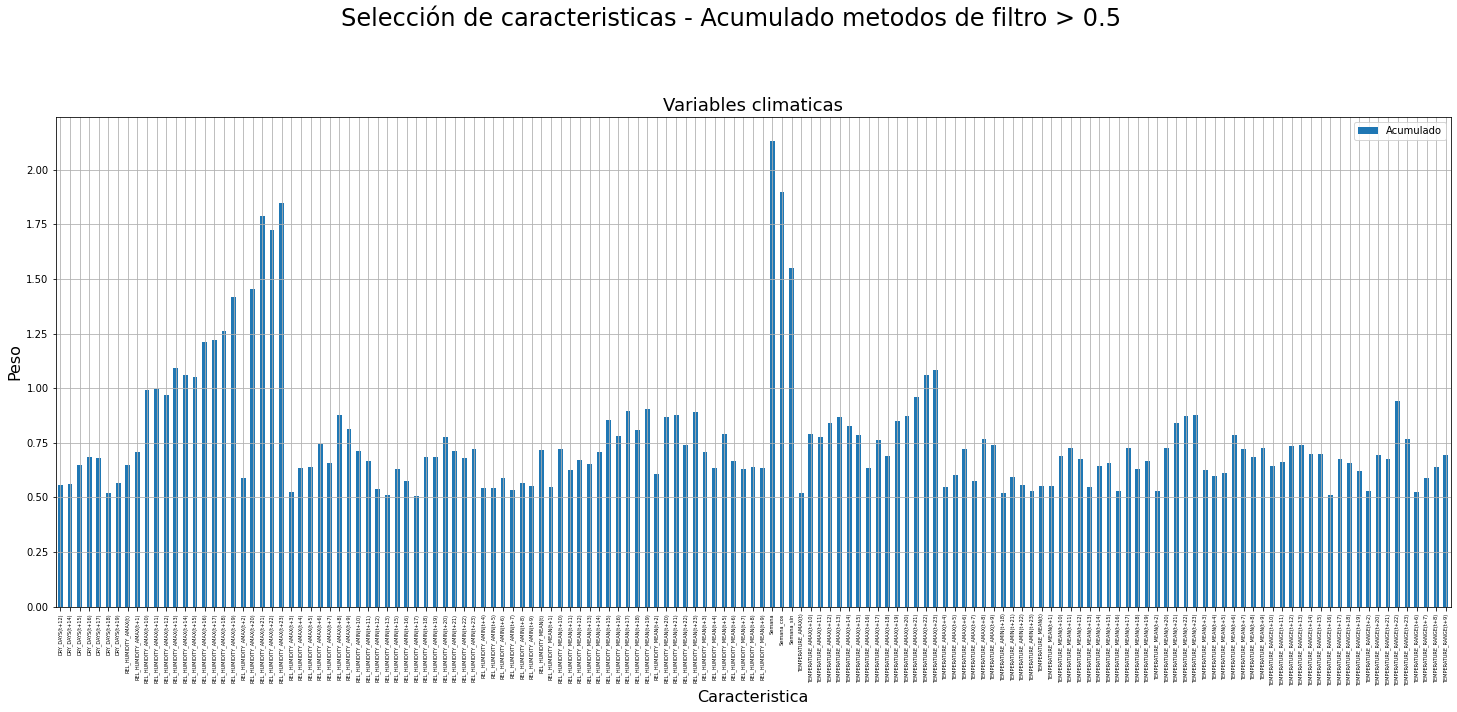

In [34]:
Escalados1 = list(Escalados[:,0])
Escalados2 = list(Escalados[:,1])
Caract_Escal = pd.DataFrame({'Caracteristica': Escalados1, 'Acumulado': Escalados2})
Caract_Escal

Caract_Escal.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caract_Escal))
plt.xticks(X_indices, Caract_Escal['Caracteristica'], rotation='vertical', fontsize = 5)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Acumulado metodos de filtro', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Acumulaos.jpg', dpi=100, bbox_inches='tight')
plt.show()

Caract_Escal_Filtado = Caract_Escal[Caract_Escal['Acumulado']>0.5]
print(Caract_Escal_Filtado.shape)

Caract_Escal_Filtado.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caract_Escal_Filtado))
plt.xticks(X_indices, Caract_Escal_Filtado['Caracteristica'], rotation='vertical', fontsize = 5)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Acumulado metodos de filtro > 0.5', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Acumulados_mas_05.jpg', dpi=100, bbox_inches='tight')
plt.show()
#Caract_Escal_Filtado

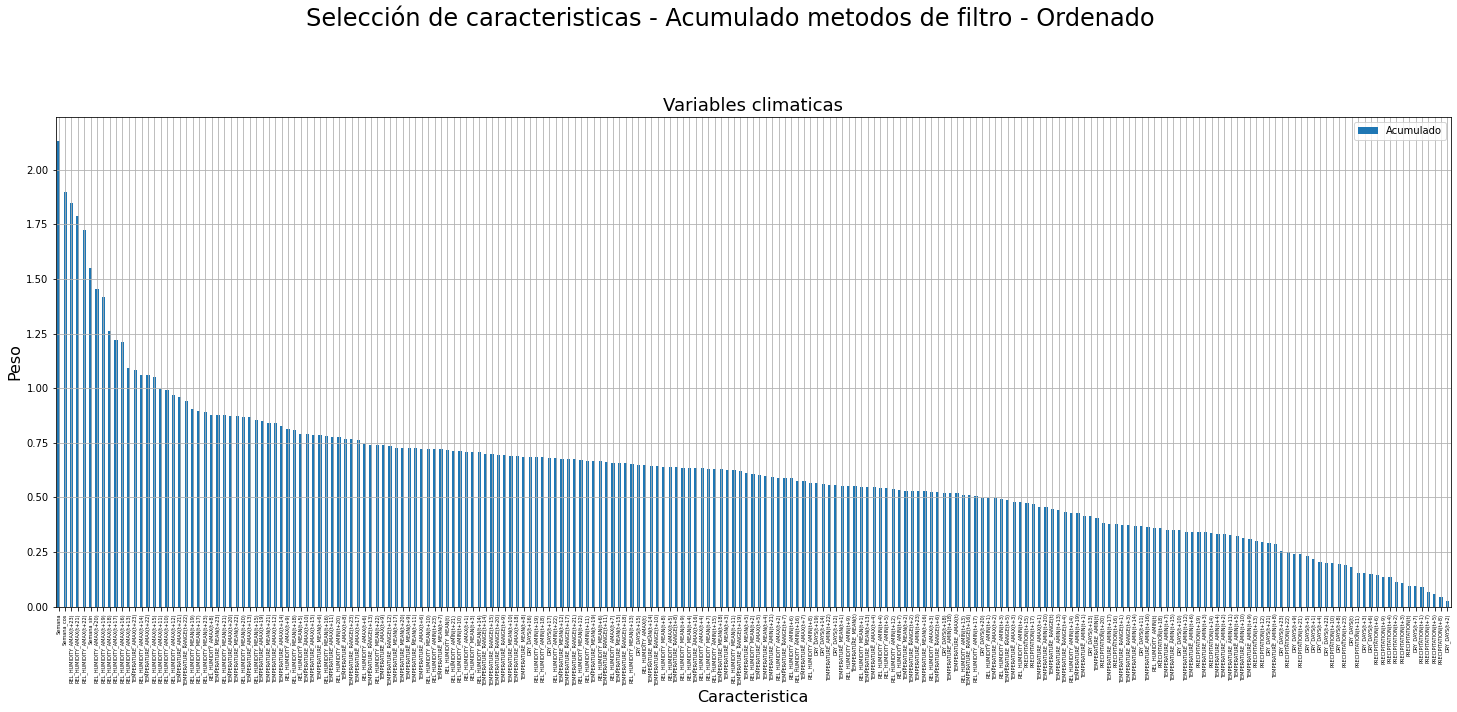

In [35]:

Caract_Escal_ORDEN = Caract_Escal.sort_values('Acumulado',ascending=False)


Caract_Escal_ORDEN.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caract_Escal_ORDEN))
plt.xticks(X_indices, Caract_Escal_ORDEN['Caracteristica'], rotation='vertical', fontsize = 5)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Acumulado metodos de filtro - Ordenado', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Acumulados_Ordenados.jpg', dpi=100, bbox_inches='tight')
plt.show()

Caract_Escal_ORDEN.to_csv(PATH_O + 'caracteristicas_filtro_acumulado_ordenado.csv', index=True)

In [36]:
# for i in range (0,len(Escalados)):
#     if (Escalados[[i],[1]]>=0.5):
#         print(Escalados[[i],[0]], "\t\t\t\t", Escalados[[i],[1]])

In [37]:
# Escalados = Escalados[Escalados[:,1].argsort(),]
# #print(Escalados)
# Escalados = Escalados[::-1]
# #print(Escalados)
# Caracteristicas_orden = list(Escalados[:,0])
# #print(Caracteristicas_orden)
# Data_orden = df[Caracteristicas_orden]
# Data_orden




In [38]:
# caracteristicas_s = pd.concat([df_CR1,df_CR2,df_CR3], ignore_index=True, axis=1)
# caracteristicas_s



In [39]:
# feature_name = caracteristicas_s[2]
# del caracteristicas_s[2]
# del caracteristicas_s[4]
# caracteristicas_s.set_index([0],inplace=True)
# caracteristicas_s=caracteristicas_s.rename(columns={1: "mutual_info_regression", 3: "f_classif", 5:"f_regression"})
# caracteristicas_s.to_csv(PATH_O + "caracterisitcas_ordenadas.csv", index=True)
# caracteristicas_s

In [40]:
# caracteristicas_v = caracteristicas_s.values

# #Crear una matriz con los limites para el esclalado de los datos
# limite_caracteristica = np.array(([np.amin(caracteristicas_v[:,0])],[np.amax(caracteristicas_v[:,0])]))

# for i in range(1,len(caracteristicas_v[1,:])):
#     limite_caracteristica = np.insert(limite_caracteristica, limite_caracteristica.shape[1], [np.amin(caracteristicas_v[:,i]), np.amax(caracteristicas_v[:,i])], axis=1)


# scaled_feature = np.zeros((len(caracteristicas_v), len(caracteristicas_v[0])))
# for i in range(0,len(caracteristicas_v[1,:])):
#     scaled_feature[:,i]=escalador(caracteristicas_v[:,i],limite_caracteristica[0][i],limite_caracteristica[1][i])

# caracteristicas_v = pd.DataFrame(scaled_feature)

# caracteristicas_v = pd.concat([feature_name,caracteristicas_v], ignore_index=True, axis=1)
# caracteristicas_v.set_index([0],inplace=True)
# caracteristicas_v=caracteristicas_v.rename(columns={1: "mutual_info_regression", 2: "f_classif", 3:"f_regression"})
# caracteristicas_v.to_csv(PATH_O + "caracterisitcas_ord_normal.csv", index=True)
# caracteristicas_v
# acumulado = caracteristicas_v['mutual_info_regression']+caracteristicas_v['f_classif']+caracteristicas_v['f_regression']
# acumulado
# # acumulado.plot.bar(figsize = (15,5))
# # # X_indices = np.arange(len(acumulado))
# # # plt.xticks(X_indices, acumulado[0], rotation='vertical', fontsize = 8)
# # plt.ylabel('Peso', fontsize = 16)
# # plt.xlabel('Caracteristica', fontsize = 16)
# # plt.title('Selección de caracteristicas - Acumulado metodos de filtro Alejo', fontsize = 24) 
# # plt.grid()
# # # plt.savefig(PATH_O + 'acumulados_16.jpg', dpi=300)
# # plt.show()

In [41]:
# caracteristicas_s.plot.barh(figsize = (10,55))

In [42]:
# caracteristicas_v.plot.barh(figsize = (10,55))

In [43]:

#para capturar las caracteristicas deseadas
#caracteristicas_v.loc[['ONI(t+15)', 'ONI(t+11)', 'ONI(t+7)', 'ONI(t+3)', 'MEI(t+15)', 'MEI(t+11)', 'MEI(t+7)', 'MEI(t+3)', 'SST4(t+15)', 'SST4(t+11)', 'SST4(t+7)', 'SST4(t+3)', 'TNI(t+15)', 'TNI(t+11)', 'TNI(t+7)', 'TNI(t+3)', 'SST3(t+15)', 'SST3(t+11)', 'SST3(t+7)', 'SST3(t+3)', 'SST3.4(t+15)', 'SST3.4(t+11)', 'SST3.4(t+7)', 'SST3.4(t+3)', 'SST1+2(t+15)', 'SST1+2(t+11)', 'SST1+2(t+7)', 'SST1+2(t+3)', 'TEMPERATURE_AMAX(t+15)', 'TEMPERATURE_AMAX(t+14)', 'TEMPERATURE_AMAX(t+13)', 'TEMPERATURE_AMAX(t+12)', 'TEMPERATURE_AMAX(t+11)', 'TEMPERATURE_AMAX(t+10)', 'TEMPERATURE_AMAX(t+9)', 'TEMPERATURE_AMAX(t+8)', 'TEMPERATURE_AMAX(t+7)', 'TEMPERATURE_AMAX(t+6)', 'TEMPERATURE_AMAX(t+5)', 'TEMPERATURE_AMAX(t+4)', 'TEMPERATURE_AMAX(t+3)', 'TEMPERATURE_AMAX(t+2)', 'TEMPERATURE_AMAX(t+1)', 'TEMPERATURE_AMAX(t)', 'TEMPERATURE_MEAN(t+15)', 'TEMPERATURE_MEAN(t+14)', 'TEMPERATURE_MEAN(t+13)', 'TEMPERATURE_MEAN(t+12)', 'TEMPERATURE_MEAN(t+11)', 'TEMPERATURE_MEAN(t+10)', 'TEMPERATURE_MEAN(t+9)', 'TEMPERATURE_MEAN(t+8)', 'TEMPERATURE_MEAN(t+7)', 'TEMPERATURE_MEAN(t+6)', 'TEMPERATURE_MEAN(t+5)', 'TEMPERATURE_MEAN(t+4)', 'TEMPERATURE_MEAN(t+3)', 'TEMPERATURE_MEAN(t+2)', 'TEMPERATURE_MEAN(t+1)', 'TEMPERATURE_MEAN(t)', 'TEMPERATURE_RANGE(t+15)', 'TEMPERATURE_RANGE(t+14)', 'TEMPERATURE_RANGE(t+13)', 'TEMPERATURE_RANGE(t+12)', 'TEMPERATURE_RANGE(t+11)', 'TEMPERATURE_RANGE(t+10)', 'TEMPERATURE_RANGE(t+9)', 'TEMPERATURE_RANGE(t+8)', 'TEMPERATURE_RANGE(t+7)', 'TEMPERATURE_RANGE(t+6)', 'TEMPERATURE_RANGE(t+5)', 'TEMPERATURE_RANGE(t+4)', 'TEMPERATURE_RANGE(t+3)', 'TEMPERATURE_RANGE(t+2)', 'TEMPERATURE_RANGE(t+1)', 'TEMPERATURE_RANGE(t)', 'REL_HUMIDITY_AMAX(t+15)', 'REL_HUMIDITY_AMAX(t+14)', 'REL_HUMIDITY_AMAX(t+13)', 'REL_HUMIDITY_AMAX(t+12)', 'REL_HUMIDITY_AMAX(t+11)', 'REL_HUMIDITY_AMAX(t+10)', 'REL_HUMIDITY_AMAX(t+9)', 'REL_HUMIDITY_AMAX(t+8)', 'REL_HUMIDITY_AMAX(t+7)', 'REL_HUMIDITY_AMAX(t+6)', 'REL_HUMIDITY_AMAX(t+5)', 'REL_HUMIDITY_AMAX(t+4)', 'REL_HUMIDITY_AMAX(t+3)', 'REL_HUMIDITY_AMAX(t+2)', 'REL_HUMIDITY_AMAX(t+1)', 'REL_HUMIDITY_AMAX(t)',  'REL_HUMIDITY_MEAN(t+15)', 'REL_HUMIDITY_MEAN(t+14)', 'REL_HUMIDITY_MEAN(t+13)', 'REL_HUMIDITY_MEAN(t+12)', 'REL_HUMIDITY_MEAN(t+11)', 'REL_HUMIDITY_MEAN(t+10)', 'REL_HUMIDITY_MEAN(t+9)', 'REL_HUMIDITY_MEAN(t+8)', 'REL_HUMIDITY_MEAN(t+7)', 'REL_HUMIDITY_MEAN(t+6)', 'REL_HUMIDITY_MEAN(t+5)', 'REL_HUMIDITY_MEAN(t+4)', 'REL_HUMIDITY_MEAN(t+3)', 'REL_HUMIDITY_MEAN(t+2)', 'REL_HUMIDITY_MEAN(t+1)', 'REL_HUMIDITY_MEAN(t)', 'DENGUE(t+15)', 'DENGUE(t+14)', 'DENGUE(t+13)', 'DENGUE(t+12)', 'DENGUE(t+11)', 'DENGUE(t+10)', 'DENGUE(t+9)', 'DENGUE(t+8)', 'DENGUE(t+7)', 'DENGUE(t+6)', 'DENGUE(t+5)', 'DENGUE(t+4)', 'DENGUE(t+3)', 'DENGUE(t+2)', 'DENGUE(t+1)', 'DENGUE(t)']]


In [44]:
#df_CR3.to_csv(PATH_O + 'caracteristicas_f_regresion.csv', index=True)

In [45]:
# caracteristicas = pd.concat([df_CR1,df_CR2,df_CR3], ignore_index=True, axis=1)
# caracteristicas.to_csv(nombre_a, index=True)
# caracteristicas

In [46]:
# caracteristicas.to_csv(PATH_O + 'caracteristicas_TODAS_CARACTERISTICAS.csv', index=True)